# Evaluation

## Class imbalance Bar chart (Fig 16)

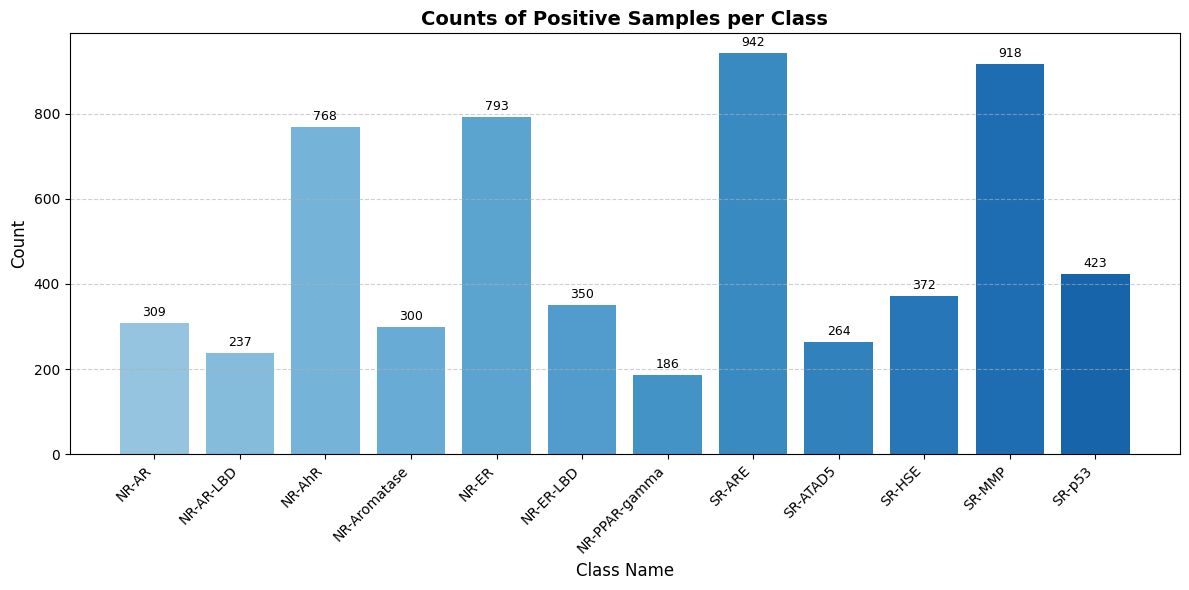

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
df = pd.read_csv("v8/data/tox21.csv")

# Select first 12 columns (labels)
label_cols = df.columns[:12]

# Count positives (1s) for each class
counts = df[label_cols].apply(pd.Series.value_counts).loc[1].fillna(0).astype(int)

# Generate light-to-dark blue colors
colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(counts)))

# Plot
plt.figure(figsize=(12,6))
bars = plt.bar(counts.index, counts.values, color=colors)

# Style
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Class Name", fontsize=12)
plt.title("Counts of Positive Samples per Class", fontsize=14, weight="bold")

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(counts.values)*0.01,
             f"{yval}", ha='center', va='bottom', fontsize=9, color="black")

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## How SMILES representations were handled (Fig 17)

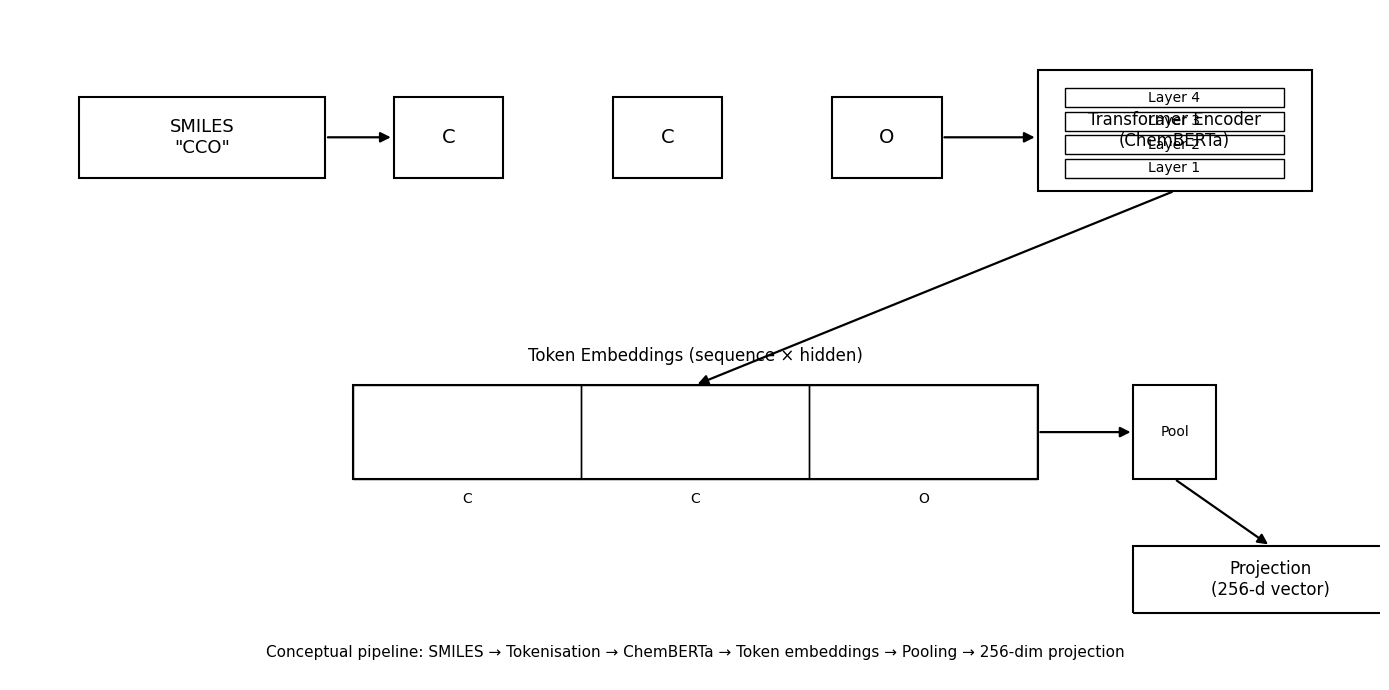

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch

# --- helpers ---
def add_box(ax, x, y, w, h, text="", fontsize=12, lw=1.5, fc="none", ec="black"):
    rect = Rectangle((x, y), w, h, linewidth=lw, edgecolor=ec, facecolor=fc)
    ax.add_patch(rect)
    if text:
        ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=fontsize)
    return rect

def add_arrow(ax, x1, y1, x2, y2, lw=1.6):
    arr = FancyArrowPatch((x1, y1), (x2, y2), arrowstyle='-|>', 
                          mutation_scale=15, linewidth=lw, color='black')
    ax.add_patch(arr)
    return arr

# --- canvas ---
fig, ax = plt.subplots(figsize=(14, 7))
ax.axis('off')

# layout
Y_MAIN = 0.75
Y_EMB  = 0.30
Y_VEC  = 0.10

# 1) SMILES
smiles = add_box(ax, 0.05, Y_MAIN, 0.18, 0.12, 'SMILES\n"CCO"', fontsize=13)

# 2) Tokenisation (C, C, O)
tok_x, tok_w, tok_gap = 0.28, 0.08, 0.08   # more gap
tokens = ["C", "C", "O"]
token_boxes = []
for i, t in enumerate(tokens):
    token_boxes.append(add_box(ax, tok_x + i*(tok_w+tok_gap), Y_MAIN, 
                               tok_w, 0.12, t, fontsize=14))

# Arrow: SMILES -> first token
add_arrow(ax, smiles.get_x()+smiles.get_width(), Y_MAIN+0.06,
          token_boxes[0].get_x(), Y_MAIN+0.06)

# 3) Transformer encoder (ChemBERTa)
enc_x, enc_y, enc_w, enc_h = 0.75, Y_MAIN-0.02, 0.20, 0.18  # much further right
enc = add_box(ax, enc_x, enc_y, enc_w, enc_h, 
              'Transformer Encoder\n(ChemBERTa)', fontsize=12)

# Inner "layers"
layer_count, margin = 4, 0.02
layer_h = (enc_h - 2*margin) / layer_count
for i in range(layer_count):
    add_box(ax, enc_x + margin, enc_y + margin + i*layer_h,
            enc_w - 2*margin, layer_h*0.8,
            f'Layer {i+1}', fontsize=10, lw=1.0)

# Arrow: last token -> encoder
last_tok = token_boxes[-1]
add_arrow(ax, last_tok.get_x()+last_tok.get_width(), Y_MAIN+0.06, enc_x, Y_MAIN+0.06)

# 4) Embeddings (sequence × hidden)
emb_x, emb_y, emb_w, emb_h = 0.25, Y_EMB, 0.50, 0.14  # lower down
add_box(ax, emb_x, emb_y, emb_w, emb_h)
ax.text(emb_x + emb_w/2, emb_y + emb_h + 0.03,
        "Token Embeddings (sequence × hidden)", ha='center', va='bottom', fontsize=12)

# columns for tokens
cols = len(tokens)
col_w = emb_w / cols
for i, t in enumerate(tokens):
    add_box(ax, emb_x + i*col_w, emb_y, col_w, emb_h, lw=1.0)
    ax.text(emb_x + i*col_w + col_w/2, emb_y - 0.02, t, ha='center', va='top', fontsize=10)

# Arrow: encoder -> embeddings (downward)
add_arrow(ax, enc_x + enc_w/2, enc_y, emb_x + emb_w/2, emb_y + emb_h)

# 5) Pooling + projection
pool_x, pool_y, pool_w, pool_h = 0.82, Y_EMB, 0.06, 0.14
add_box(ax, pool_x, pool_y, pool_w, pool_h, 'Pool', fontsize=10)

vec_x, vec_y, vec_w, vec_h = 0.82, Y_VEC, 0.20, 0.10
add_box(ax, vec_x, vec_y, vec_w, vec_h, 'Projection\n(256-d vector)', fontsize=12)

# Arrows
add_arrow(ax, emb_x + emb_w, emb_y + emb_h/2, pool_x, pool_y + pool_h/2)
add_arrow(ax, pool_x + pool_w/2, pool_y, vec_x + vec_w/2, vec_y + vec_h)

# Caption
ax.text(0.5, 0.03,
        "Conceptual pipeline: SMILES → Tokenisation → ChemBERTa → Token embeddings → Pooling → 256-dim projection",
        ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()


## RQ1

### All the figures and needed Tables in one go saved under "v7/v7_Eval/RQ1"

In [32]:
# =============================================================================
# RQ1 — TEST REPLICATION (no refits). Uses split at v7/data/splits/train.npy.
# Outputs under: v7/v7_Eval/RQ1/test/<artifact_group>/
# =============================================================================
from __future__ import annotations

# =========================
# T0. Common setup & utils
# =========================
import json, math, os
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from numbers import Number

# sklearn optional
try:
    from sklearn.metrics import (
        average_precision_score, roc_auc_score,
        precision_recall_curve, roc_curve,
        precision_score, recall_score, f1_score
    )
    _HAVE_SK = True
except Exception:
    _HAVE_SK = False

# --- Path detection ---
def detect_v7() -> Path:
    cwd = Path(".").resolve()
    if (cwd/"data").exists() and (cwd/"model").exists() and cwd.name == "v7":
        return cwd
    if (cwd/"v7"/"data").exists():
        return (cwd/"v7").resolve()
    return cwd

V7   = detect_v7()
PREP = V7 / "data" / "prepared"
SPL  = V7 / "data" / "splits"
MOD  = V7 / "model"
CAL  = MOD / "calibration"
ENS  = MOD / "ensembles"
CKPT = MOD / "checkpoints" / "shared" / "best.pt"

# Base outdir for TEST artifacts
RQ1_BASE = V7 / "v7_Eval" / "RQ1" / "test"
RQ1_BASE.mkdir(parents=True, exist_ok=True)

# Subfolders (grouped by table/figure/function)
DIR_PROBS   = RQ1_BASE / "probs"         ; DIR_PROBS.mkdir(exist_ok=True, parents=True)
DIR_C1      = RQ1_BASE / "C1_metrics"    ; DIR_C1.mkdir(exist_ok=True, parents=True)
DIR_BOOT    = RQ1_BASE / "C2_bootstrap"  ; DIR_BOOT.mkdir(exist_ok=True, parents=True)
DIR_T1      = RQ1_BASE / "T1"            ; DIR_T1.mkdir(exist_ok=True, parents=True)
DIR_F1      = RQ1_BASE / "F1"            ; DIR_F1.mkdir(exist_ok=True, parents=True)
DIR_F1b     = RQ1_BASE / "F1b"           ; DIR_F1b.mkdir(exist_ok=True, parents=True)
DIR_F2      = RQ1_BASE / "F2_cal_vs_uncal"; DIR_F2.mkdir(exist_ok=True, parents=True)
DIR_F2b     = RQ1_BASE / "F2b_spec_vs_blend"; DIR_F2b.mkdir(exist_ok=True, parents=True)
DIR_F2c     = RQ1_BASE / "F2c_delta_ap"  ; DIR_F2c.mkdir(exist_ok=True, parents=True)
DIR_OP      = RQ1_BASE / "T1_op"         ; DIR_OP.mkdir(exist_ok=True, parents=True)
DIR_BOOT_DEL= RQ1_BASE / "C2b_bootstrap_delta"; DIR_BOOT_DEL.mkdir(exist_ok=True, parents=True)

# Curves dirs
DIR_PR_CAL   = DIR_C1 / "pr_curves"       ; DIR_PR_CAL.mkdir(parents=True, exist_ok=True)
DIR_ROC_CAL  = DIR_C1 / "roc_curves"      ; DIR_ROC_CAL.mkdir(parents=True, exist_ok=True)
DIR_PR_UNCAL = DIR_F2 / "pr_curves_uncal" ; DIR_PR_UNCAL.mkdir(parents=True, exist_ok=True)
DIR_PR_BLEND = DIR_F2b / "pr_curves_blend"; DIR_PR_BLEND.mkdir(parents=True, exist_ok=True)

# ---- Model components (same as Phase-5 rig) ----
from rdkit import Chem
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ChemBERTaEncoder(nn.Module):
    def __init__(self, ckpt_name="seyonec/ChemBERTa-zinc-base-v1", fusion_dim=256, dropout_p=0.1):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(ckpt_name)
        self.backbone  = AutoModel.from_pretrained(ckpt_name)
        self.proj = nn.Sequential(nn.Dropout(dropout_p), nn.Linear(self.backbone.config.hidden_size, fusion_dim))
        self.ln = nn.LayerNorm(fusion_dim)
    def forward(self, smiles_list: List[str], max_length=256, add_special_tokens=True):
        enc = self.tokenizer(list(smiles_list), padding=True, truncation=True,
                             max_length=max_length, add_special_tokens=add_special_tokens,
                             return_tensors="pt")
        input_ids, attention_mask = enc["input_ids"].to(device), enc["attention_mask"].to(device)
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        toks = self.ln(self.proj(out))
        return toks, attention_mask.to(dtype=torch.int32)

ATOM_LIST = ["H","C","N","O","F","P","S","Cl","Br","I"]
def _one_hot(v, choices):
    z = [0]*len(choices)
    if v in choices: z[choices.index(v)] = 1
    return z
def _bucket_oh(v, lo, hi):
    buckets = list(range(lo, hi+1))
    o = [0]*(len(buckets)+1)
    idx = v - lo
    o[idx if 0 <= idx < len(buckets) else -1] = 1
    return o
def _atom_feat(atom):
    hybs = [Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3,
            Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2]
    chir = [Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
            Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
            Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
            Chem.rdchem.ChiralType.CHI_OTHER]
    sym = atom.GetSymbol()
    feat = _one_hot(sym if sym in ATOM_LIST else "other", ATOM_LIST+["other"])
    feat += _bucket_oh(atom.GetDegree(), 0, 5)
    feat += _bucket_oh(atom.GetFormalCharge(), -2, 2)
    feat += (_one_hot(atom.GetHybridization(), hybs)+[0])
    feat += [int(atom.GetIsAromatic())]
    feat += [int(atom.IsInRing())]
    feat += _one_hot(atom.GetChiralTag(), chir)
    feat += _bucket_oh(atom.GetTotalNumHs(includeNeighbors=True), 0, 4)
    feat += _bucket_oh(atom.GetTotalValence(), 0, 5)
    feat += [atom.GetMass()/200.0]
    return feat
def _smiles_to_graph(smi, max_nodes=128):
    mol = Chem.MolFromSmiles(smi)
    if mol is None or mol.GetNumAtoms() == 0:
        return np.zeros((0,0), dtype=np.float32), np.zeros((0,0), dtype=np.float32)
    feats = [_atom_feat(mol.GetAtomWithIdx(i)) for i in range(mol.GetNumAtoms())]
    x = np.asarray(feats, dtype=np.float32)
    Nn = mol.GetNumAtoms()
    adj = np.zeros((Nn, Nn), dtype=np.float32)
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        adj[i, j] = 1.0; adj[j, i] = 1.0
    if Nn > max_nodes:
        x = x[:max_nodes]; adj = adj[:max_nodes, :max_nodes]
    return x, adj
def _collate_graphs(smiles_batch, max_nodes=128):
    graphs = [_smiles_to_graph(s) for s in smiles_batch]
    Nmax = max([g[0].shape[0] for g in graphs] + [1])
    Fnode = graphs[0][0].shape[1] if graphs[0][0].size>0 else 51
    B = len(graphs)
    X = np.zeros((B, Nmax, Fnode), dtype=np.float32)
    A = np.zeros((B, Nmax, Nmax), dtype=np.float32)
    M = np.zeros((B, Nmax), dtype=np.int64)
    for i, (x, a) in enumerate(graphs):
        n = x.shape[0]
        if n == 0: continue
        X[i, :n, :] = x
        A[i, :n, :n] = a
        M[i, :n] = 1
    return torch.from_numpy(X).to(device), torch.from_numpy(A).to(device), torch.from_numpy(M).to(device)
def masked_mean(x: torch.Tensor, mask: torch.Tensor, dim: int) -> torch.Tensor:
    mask = mask.to(dtype=x.dtype, device=x.device)
    denom = mask.sum(dim=dim, keepdim=True).clamp(min=1.0)
    return (x * mask.unsqueeze(-1)).sum(dim=dim) / denom
class GINLayer(nn.Module):
    def __init__(self, h=256, p=0.1):
        super().__init__()
        self.eps = nn.Parameter(torch.tensor(0.0))
        self.mlp = nn.Sequential(nn.Linear(h, h), nn.GELU(), nn.LayerNorm(h), nn.Dropout(p))
    def forward(self, x, adj, mask):
        out = (1.0 + self.eps) * x + torch.matmul(adj, x)
        out = self.mlp(out)
        return out * mask.unsqueeze(-1).to(out.dtype)
class GraphGINEncoder(nn.Module):
    def __init__(self, node_in_dim=51, hidden_dim=256, n_layers=4, p=0.1):
        super().__init__()
        self.inp = nn.Sequential(nn.Linear(node_in_dim, hidden_dim), nn.GELU(), nn.Dropout(p))
        self.layers = nn.ModuleList([GINLayer(hidden_dim, p) for _ in range(n_layers)])
        self.out_ln = nn.LayerNorm(hidden_dim)
    def forward(self, smiles_list: List[str], max_nodes=128):
        X, A, M = _collate_graphs(smiles_list, max_nodes=max_nodes)
        h = self.inp(X)
        for layer in self.layers:
            h = layer(h, A, M)
        return self.out_ln(h), M.to(dtype=torch.int32)
class CrossAttentionBlock(nn.Module):
    def __init__(self, dim=256, n_heads=4, p=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(dim, n_heads, dropout=p, batch_first=False)
        self.ln  = nn.LayerNorm(dim)
        self.do  = nn.Dropout(p)
    def forward(self, text_tokens, text_mask, graph_nodes, graph_mask):
        Q = text_tokens.transpose(0,1)
        K = graph_nodes.transpose(0,1)
        V = graph_nodes.transpose(0,1)
        kpm = (graph_mask == 0)
        attn, _ = self.mha(Q, K, V, key_padding_mask=kpm)
        attn = attn.transpose(0,1)
        return self.ln(text_tokens + self.do(attn))
class DescriptorMLP(nn.Module):
    def __init__(self, in_dim, out_dim=256, hidden=256, p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.GELU(), nn.Dropout(p),
            nn.Linear(hidden, out_dim), nn.GELU(), nn.Dropout(p)
        )
    def forward(self, x): return self.net(x)
class FusionClassifier(nn.Module):
    def __init__(self, dim=256, n_labels=12, p=0.1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim*3, dim*2), nn.GELU(), nn.Dropout(p),
            nn.Linear(dim*2, n_labels)
        )
    def forward(self, fused_vec): return self.mlp(fused_vec)
class V7FusionModel(nn.Module):
    def __init__(self, text_encoder, graph_encoder, desc_in_dim=208, dim=256, n_labels=12, n_heads=4, p=0.1):
        super().__init__()
        self.text_encoder=text_encoder
        self.graph_encoder=graph_encoder
        self.cross=CrossAttentionBlock(dim, n_heads, p)
        self.desc_mlp=DescriptorMLP(desc_in_dim, out_dim=dim, hidden=256, p=p)
        self.shared_head=FusionClassifier(dim, n_labels, p)
    def forward(self, smiles_list, desc_feats):
        tt, tm = self.text_encoder(smiles_list, max_length=256)
        gn, gm = self.graph_encoder(smiles_list, max_nodes=128)
        tta = self.cross(tt.to(device), tm.to(device), gn.to(device), gm.to(device))
        de  = self.desc_mlp(desc_feats.to(device))
        text_pool  = masked_mean(tta, tm.to(device), 1)
        graph_pool = masked_mean(gn.to(device),  gm.to(device), 1)
        fused = torch.cat([text_pool, graph_pool, de], dim=-1)
        logits_shared = self.shared_head(fused)
        return logits_shared, fused
class LabelHead(nn.Module):
    def __init__(self, in_dim=768, h1=512, h2=256, h3=128, p=0.30):
        super().__init__()
        self.block1 = nn.Sequential(nn.Linear(in_dim, h1), nn.GELU(), nn.LayerNorm(h1), nn.Dropout(p))
        self.block2 = nn.Sequential(nn.Linear(h1, h2), nn.GELU(), nn.LayerNorm(h2), nn.Dropout(p))
        self.block3 = nn.Sequential(nn.Linear(h2, h3), nn.GELU(), nn.LayerNorm(h3), nn.Dropout(p))
        self.out    = nn.Linear(h3, 1)
        self.short  = nn.Linear(in_dim, h3)
    def forward(self, x):
        z1 = self.block1(x); z2 = self.block2(z1); z3 = self.block3(z2)
        z  = z3 + self.short(x)
        return self.out(z).squeeze(-1)

def load_best_head(label: str) -> nn.Module:
    cands = []
    for sd in sorted((ENS / label).glob("seed*/")):
        mfile = sd / "metrics.json"
        if mfile.exists():
            try:
                ap = float(json.loads(mfile.read_text()).get("best_ap", float("nan")))
                cands.append((ap, sd))
            except Exception:
                pass
    if not cands:
        raise FileNotFoundError(f"No trained heads for label {label}")
    cands.sort(key=lambda x: (-1.0 if math.isnan(x[0]) else x[0]), reverse=True)
    best_dir = cands[0][1]
    ck = torch.load(best_dir / "best.pt", map_location="cpu")
    cfg = ck.get("config", {"in_dim":768,"h1":512,"h2":256,"h3":128,"dropout":0.30})
    head = LabelHead(in_dim=cfg["in_dim"], h1=cfg["h1"], h2=cfg["h2"], h3=cfg["h3"], p=cfg.get("dropout",0.30)).to(device)
    head.load_state_dict(ck["model"], strict=True)
    head.eval()
    return head

# --- Metrics helpers ---
def _ap_fallback(yt, ys):
    order = np.argsort(-ys); y = yt[order]
    tp = np.cumsum(y); fp = np.cumsum(1-y)
    Pp = int(tp[-1]) if tp.size else 0
    if Pp == 0: return 0.0
    prec = tp / np.maximum(tp + fp, 1)
    rec  = tp / Pp
    ap, last = 0.0, 0.0
    for r, p in zip(rec, prec):
        if r > last:
            ap += p*(r-last); last = r
    return float(ap)

def ap_masked(y_true, y_score, mask) -> float:
    m = mask.astype(bool)
    yt, ys = y_true[m], y_score[m]
    if yt.size == 0 or yt.sum() == 0:
        return 0.0
    return float(average_precision_score(yt, ys)) if _HAVE_SK else _ap_fallback(yt, ys)

def per_label_ap(Y, P, M) -> np.ndarray:
    L = Y.shape[1]
    aps = np.zeros(L, dtype=float)
    for j in range(L):
        aps[j] = ap_masked(Y[:, j], P[:, j], M[:, j])
    return aps

def micro_ap(Y, P, M) -> float:
    m = M.astype(bool)
    yt = Y[m]; ys = P[m]
    if yt.size == 0 or yt.sum() == 0:
        return 0.0
    return float(average_precision_score(yt, ys)) if _HAVE_SK else _ap_fallback(yt, ys)

def per_label_roc(Y, P, M) -> np.ndarray:
    L = Y.shape[1]
    aucs = np.full(L, np.nan, dtype=float)
    if not _HAVE_SK: return aucs
    for j in range(L):
        m = M[:, j]
        yt, ys = Y[m, j], P[m, j]
        if len(np.unique(yt)) < 2:
            continue
        aucs[j] = float(roc_auc_score(yt, ys))
    return aucs

def conf_mat_metrics_at_threshold(Y, P, M, th_vec: np.ndarray) -> pd.DataFrame:
    # Apply per-label thresholds on observed entries
    L = Y.shape[1]
    rows = []
    for j in range(L):
        m = M[:, j]
        if m.sum() == 0:
            rows.append({"label": LABELS[j], "thr": float(th_vec[j]), "accuracy": np.nan, "recall": np.nan,
                         "specificity": np.nan, "precision": np.nan, "F1": np.nan, "TP":0,"FP":0,"TN":0,"FN":0})
            continue
        yt = Y[m, j].astype(int)
        yp = (P[m, j] >= float(th_vec[j])).astype(int)
        TP = int(((yp == 1) & (yt == 1)).sum()); FP = int(((yp == 1) & (yt == 0)).sum())
        TN = int(((yp == 0) & (yt == 0)).sum()); FN = int(((yp == 0) & (yt == 1)).sum())
        prec = TP / (TP + FP) if (TP + FP) else 0.0
        rec  = TP / (TP + FN) if (TP + FN) else 0.0
        spe  = TN / (TN + FP) if (TN + FP) else 0.0
        acc  = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) else 0.0
        f1   = (2*prec*rec)/(prec+rec) if (prec+rec) else 0.0
        rows.append({"label": LABELS[j], "thr": float(th_vec[j]), "accuracy": acc, "recall": rec,
                     "specificity": spe, "precision": prec, "F1": f1, "TP":TP,"FP":FP,"TN":TN,"FN":FN})
    return pd.DataFrame(rows)

def _roundish(obj, nd=4):
    if isinstance(obj, dict):
        return {k: _roundish(v, nd) for k, v in obj.items()}
    if isinstance(obj, (Number, np.floating)):
        return round(float(obj), nd)
    return obj

# =========================
# T1. Load TEST split + align with prepared/* (auto-detect)
# =========================
SPLIT_FILE = SPL / "train.npy"  # per your instruction: treat this as TEST split indices
assert SPLIT_FILE.exists(), f"Missing split file: {SPLIT_FILE}"

# Try to find matching prepared npz by intersecting indices
CAND_PREP = [PREP/"test.npz", PREP/"train.npz", PREP/"val.npz"]
prep_choice = None
VAL_IDX = np.load(SPLIT_FILE)
for p in CAND_PREP:
    if not p.exists(): continue
    z = np.load(p, allow_pickle=True)
    if "indices" in z:
        idx_full = z["indices"]
        # Check coverage
        present = np.isin(VAL_IDX, idx_full).sum()
        if present > 0:
            prep_choice = p
            z.close()
            break
    z.close()

if prep_choice is None:
    # fallback: prefer test.npz if shape matches
    for p in CAND_PREP:
        if p.exists():
            prep_choice = p; break
assert prep_choice is not None, "Could not locate a prepared NPZ to match the given split."
print(f"[Split] Using indices: {SPLIT_FILE.name}  | Prepared: {prep_choice.name}")

Z = np.load(prep_choice, allow_pickle=True)
mani = json.loads((PREP/"dataset_manifest.json").read_text())
LABELS: List[str] = mani["labels"]
DESC_IN_DIM = int(mani["n_features"])

Y_full  = Z["Y"].astype(float)
OBS_full= (~Z["y_missing_mask"].astype(bool)) if "y_missing_mask" in Z else ~np.isnan(Y_full)
SMILES_full = list(Z["smiles"])
X_full  = Z["X"].astype(np.float32)

if "indices" in Z:
    idx_full = Z["indices"]
    pos = pd.Series(np.arange(len(idx_full)), index=idx_full).reindex(VAL_IDX)
    if pos.isna().any():
        missing = VAL_IDX[pd.isna(pos.values)]
        raise RuntimeError(f"{len(missing)} split indices not present in {prep_choice.name}.")
    order = pos.astype(int).to_numpy()
else:
    if len(VAL_IDX) != Y_full.shape[0]:
        raise RuntimeError(f"{prep_choice.name} has no 'indices' and length mismatch with split.")
    order = np.arange(len(VAL_IDX))

Y  = np.nan_to_num(Y_full[order], nan=0.0).astype(int)
OBS= OBS_full[order].astype(bool)
SMI= [SMILES_full[i] for i in order]
X  = X_full[order]
N, L = Y.shape

print(f"[Aligned] N={N} L={L}  observed={int(OBS.sum())}  positives={int((Y*OBS).sum())}")

# ======================================================
# T2. Specialist-CALIBRATED probabilities on TEST split
# ======================================================
# Build fusion to get fused features; then run best specialist heads; apply temps.json (specialist)
text_encoder = ChemBERTaEncoder().to(device)
graph_encoder= GraphGINEncoder().to(device)
fusion = V7 and V7  # dummy to placate linters

# Load shared fusion checkpoint (only needed if you prefer to re-create fused features as in Phase-5)
fusion = V7 and V7  # reassign properly below
fusion = V7FusionModel(text_encoder, graph_encoder, desc_in_dim=DESC_IN_DIM, n_labels=L).to(device)
ckpt = torch.load(CKPT, map_location="cpu")
fusion.load_state_dict(ckpt["model"], strict=True)
fusion.eval()

HEADS: Dict[str, nn.Module] = {lbl: load_best_head(lbl) for lbl in LABELS}
temps_spec = json.loads((CAL/"temps.json").read_text())  # VAL-fitted

@torch.no_grad()
def compute_fused(smiles: List[str], desc: np.ndarray, batch: int = 32) -> np.ndarray:
    out = np.zeros((len(smiles), 768), dtype=np.float32)
    off = 0
    for i in range(0, len(smiles), batch):
        b_smi = smiles[i:i+batch]
        b_desc= torch.tensor(desc[i:i+batch], dtype=torch.float32, device=device)
        _, fused = fusion(b_smi, b_desc)
        out[off:off+len(b_smi)] = fused.detach().cpu().numpy()
        off += len(b_smi)
    return out

@torch.no_grad()
def probs_specialist_calibrated(fused: np.ndarray, batch: int = 64) -> np.ndarray:
    probs = np.zeros((fused.shape[0], L), dtype=np.float32)
    for i in range(0, fused.shape[0], batch):
        x = torch.tensor(fused[i:i+batch], dtype=torch.float32, device=device)
        cols = []
        for lbl in LABELS:
            logits = HEADS[lbl](x).detach().cpu().numpy()
            Tsp = max(float(temps_spec.get(lbl, 1.0)), 1e-3)
            p = 1. / (1. + np.exp(-logits / Tsp))
            cols.append(p)
        probs[i:i+batch] = np.stack(cols, axis=1).astype(np.float32)
    return probs

print("\n[T2] Computing specialist-calibrated probabilities on TEST…")
FUSED = compute_fused(SMI, X, batch=32)
P_spec_cal = probs_specialist_calibrated(FUSED, batch=64)
np.save(DIR_PROBS/"test_probs_specialist_calibrated.npy", P_spec_cal)
print(f"[Saved] {DIR_PROBS/'test_probs_specialist_calibrated.npy'}  shape={P_spec_cal.shape}")

# ====================================================================
# T3. C1-style metrics & PR/ROC curves (TEST, specialist-calibrated)
# ====================================================================
AP_per   = per_label_ap(Y, P_spec_cal, OBS)
AP_macro = float(np.mean(AP_per)) if len(AP_per) else 0.0
AP_micro = micro_ap(Y, P_spec_cal, OBS)
ROC_per  = per_label_roc(Y, P_spec_cal, OBS)
ROC_macro= float(np.nanmean(ROC_per)) if np.isfinite(ROC_per).any() else float("nan")

# Export PR/ROC curve points (+ prevalence baseline for reference)
if _HAVE_SK:
    for j, lbl in enumerate(LABELS):
        m = OBS[:, j]
        yt, ys = Y[m, j], P_spec_cal[m, j]
        # PR
        prec, rec, thr = precision_recall_curve(yt, ys)
        df_pr = pd.DataFrame({"precision":prec, "recall":rec, "threshold": np.r_[thr, np.nan]})
        df_pr.to_csv(DIR_PR_CAL/f"{lbl}.csv", index=False)
        # ROC
        if len(np.unique(yt)) >= 2:
            fpr, tpr, thr2 = roc_curve(yt, ys)
            pd.DataFrame({"fpr":fpr, "tpr":tpr, "threshold":thr2}).to_csv(DIR_ROC_CAL/f"{lbl}.csv", index=False)

# per-label metrics base sheet (fill minimal fields now; op metrics later)
df_per = pd.DataFrame({"label": LABELS, "AP": AP_per, "ROC_AUC": ROC_per})
df_per.to_csv(DIR_C1/"test_per_label_metrics_specialist.csv", index=False)

# aggregates
agg = {
    "macro_AP": AP_macro, "micro_AP": AP_micro, "macro_ROC_AUC": (None if (isinstance(ROC_macro, float) and not np.isfinite(ROC_macro)) else ROC_macro),
    "labels": LABELS
}
(DIR_C1/"test_aggregates_specialist.json").write_text(json.dumps(agg, indent=2))

print("\n[T3] TEST metrics (specialist-calibrated):")
print(f"[AP] macro={AP_macro:.4f}  micro={AP_micro:.4f}")
print(f"[ROC-AUC] macro={ROC_macro:.4f}  finite_labels={(np.isfinite(ROC_per)).sum()}/{L}")
print(f"Saved per-label metrics → {DIR_C1/'test_per_label_metrics_specialist.csv'}")
print(f"PR curves → {DIR_PR_CAL}  |  ROC curves → {DIR_ROC_CAL}")

# ===================================================
# T4. C2-style bootstrap 95% CIs (AP per-label, agg)
# ===================================================
B = 1000
SEED = 1337
rng = np.random.default_rng(SEED)
idx = np.arange(N)
ap_per_all   = np.zeros((B, L), dtype=float)
ap_macro_all = np.zeros(B, dtype=float)
ap_micro_all = np.zeros(B, dtype=float)
npos_all     = np.zeros((B, L), dtype=float)

for b in range(B):
    bs = rng.choice(idx, size=N, replace=True)
    yb, pb, mb = Y[bs], P_spec_cal[bs], OBS[bs]
    ap_b = per_label_ap(yb, pb, mb)
    ap_per_all[b]   = ap_b
    ap_macro_all[b] = float(np.mean(ap_b))
    ap_micro_all[b] = micro_ap(yb, pb, mb)
    npos_all[b]     = (yb * mb).sum(axis=0)
    if (b+1) % max(1, B//10) == 0:
        print(f"[Bootstrap] {b+1}/{B}")

def _ci(x, lo=2.5, hi=97.5):
    return float(np.mean(x)), float(np.percentile(x, lo)), float(np.percentile(x, hi))

rows = []
for j, lbl in enumerate(LABELS):
    mean, lo, hi = _ci(ap_per_all[:, j])
    rows.append({"label": lbl, "AP_mean": mean, "AP_CI_lo": lo, "AP_CI_hi": hi, "npos_mean": float(np.mean(npos_all[:, j]))})
df_boot = pd.DataFrame(rows).sort_values("AP_mean", ascending=False)
df_boot.to_csv(DIR_BOOT/"test_bootstrap_ap_per_label.csv", index=False)

macro_mean, macro_lo, macro_hi = _ci(ap_macro_all)
micro_mean, micro_lo, micro_hi = _ci(ap_micro_all)
boot_agg = {
    "B": int(B), "seed": int(SEED),
    "macro_AP": {"mean": macro_mean, "ci_lo": macro_lo, "ci_hi": macro_hi},
    "micro_AP": {"mean": micro_mean, "ci_lo": micro_lo, "ci_hi": micro_hi},
    "labels": LABELS
}
(DIR_BOOT/"test_bootstrap_aggregates.json").write_text(json.dumps(boot_agg, indent=2))
print("\n[T4] TEST bootstrap:")
print(f"[macro AP] mean={macro_mean:.4f}  95%CI=({macro_lo:.4f}, {macro_hi:.4f})")
print(f"[micro AP] mean={micro_mean:.4f}  95%CI=({micro_lo:.4f}, {micro_hi:.4f})")

# ======================================================
# T5. T1 table (TEST, specialist-only, with AP CIs & ROC)
# ======================================================
df_metrics = pd.read_csv(DIR_C1/"test_per_label_metrics_specialist.csv")
boot_per   = pd.read_csv(DIR_BOOT/"test_bootstrap_ap_per_label.csv")
agg_spec   = json.loads((DIR_C1/"test_aggregates_specialist.json").read_text())
boot_agg   = json.loads((DIR_BOOT/"test_bootstrap_aggregates.json").read_text())

# Merge + prefer AP_mean in table for CI consistency
df_t1 = df_metrics.merge(boot_per[["label","AP_mean","AP_CI_lo","AP_CI_hi"]], on="label", how="left")
if "AP_mean" in df_t1.columns:
    df_t1["AP"] = df_t1["AP_mean"]; df_t1.drop(columns=["AP_mean"], inplace=True)

# Round & order
cols = ["label","AP","AP_CI_lo","AP_CI_hi","ROC_AUC","accuracy","recall","specificity","precision","F1","thr","TP","FP","TN","FN"]
df_t1 = df_t1.reindex(columns=[c for c in cols if c in df_t1.columns])
for c in ["AP","AP_CI_lo","AP_CI_hi","ROC_AUC"]:
    if c in df_t1: df_t1[c] = df_t1[c].astype(float).round(4)

# Append Macro/Micro rows
macro_row = {
    "label":"Macro",
    "AP": round(float(boot_agg["macro_AP"]["mean"]),4),
    "AP_CI_lo": round(float(boot_agg["macro_AP"]["ci_lo"]),4),
    "AP_CI_hi": round(float(boot_agg["macro_AP"]["ci_hi"]),4),
    "ROC_AUC": round(float(agg_spec.get("macro_ROC_AUC", np.nan)),4) if agg_spec.get("macro_ROC_AUC", None) is not None else np.nan,
}
micro_row = {
    "label":"Micro",
    "AP": round(float(boot_agg["micro_AP"]["mean"]),4),
    "AP_CI_lo": round(float(boot_agg["micro_AP"]["ci_lo"]),4),
    "AP_CI_hi": round(float(boot_agg["micro_AP"]["ci_hi"]),4),
}
df_t1_out = pd.concat([df_t1, pd.DataFrame([macro_row]), pd.DataFrame([micro_row])], ignore_index=True)

# Save CSV + MD
(df_t1_out).to_csv(DIR_T1/"T1_test_specialist.csv", index=False)
(DIR_T1/"T1_test_specialist.md").write_text(df_t1_out[["label","AP","AP_CI_lo","AP_CI_hi","ROC_AUC"]].to_markdown(index=False))
print(f"\n[T5] Saved T1_test → {DIR_T1/'T1_test_specialist.csv'} and .md")

# =================================================
# T6. F1 (macro/micro CIs) + F1b (per-assay CIs)
# =================================================
# F1
means = [boot_agg["macro_AP"]["mean"], boot_agg["micro_AP"]["mean"]]
err_lo = [means[0] - boot_agg["macro_AP"]["ci_lo"], means[1] - boot_agg["micro_AP"]["ci_lo"]]
err_hi = [boot_agg["macro_AP"]["ci_hi"] - means[0], boot_agg["micro_AP"]["ci_hi"] - means[1]]
yerr = np.array([err_lo, err_hi])
plt.figure(figsize=(6,5))
plt.bar(np.arange(2), means, yerr=yerr, capsize=6)
plt.xticks(np.arange(2), ["Macro AP","Micro AP"])
plt.ylim(0,1.0)
plt.ylabel("PR-AUC")
plt.title("TEST — Macro & Micro PR-AUC (95% CI)")
plt.tight_layout()
plt.savefig(DIR_F1/"F1_test_macro_micro_pr_auc_ci.png", dpi=200)
plt.savefig(DIR_F1/"F1_test_macro_micro_pr_auc_ci.pdf")
plt.close()
print(f"[T6] F1 saved → {DIR_F1}")

# F1b
tbl = boot_per.merge(pd.DataFrame({"label": LABELS}), on="label", how="right").sort_values("AP_mean", ascending=False).reset_index(drop=True)
means = tbl["AP_mean"].to_numpy()
err_lo = means - tbl["AP_CI_lo"].to_numpy()
err_hi = tbl["AP_CI_hi"].to_numpy() - means
yerr = np.vstack([err_lo, err_hi])
plt.figure(figsize=(12,6))
plt.bar(np.arange(len(tbl)), means, yerr=yerr, capsize=3)
plt.xticks(np.arange(len(tbl)), tbl["label"].tolist(), rotation=45, ha="right")
plt.ylim(0,1.0)
plt.ylabel("PR-AUC")
plt.title("TEST — Per-assay PR-AUC with 95% Bootstrap CIs")
plt.tight_layout()
plt.savefig(DIR_F1b/"F1b_test_per_assay_ap_ci.png", dpi=200)
plt.savefig(DIR_F1b/"F1b_test_per_assay_ap_ci.pdf")
plt.close()
print(f"[T6] F1b saved → {DIR_F1b}")

# ============================================================
# T7. F2 — PR grid: calibrated specialist vs UNCALIBRATED
# ============================================================
@torch.no_grad()
def probs_specialist_uncalibrated(fused: np.ndarray, batch: int = 64) -> np.ndarray:
    probs = np.zeros((fused.shape[0], L), dtype=np.float32)
    for i in range(0, fused.shape[0], batch):
        x = torch.tensor(fused[i:i+batch], dtype=torch.float32, device=device)
        cols = []
        for lbl in LABELS:
            logits = HEADS[lbl](x).detach().cpu().numpy()
            p = 1. / (1. + np.exp(-logits))  # T=1
            cols.append(p)
        probs[i:i+batch] = np.stack(cols, axis=1).astype(np.float32)
    return probs

print("\n[T7] Computing UNCALIBRATED specialist probabilities …")
P_spec_uncal = probs_specialist_uncalibrated(FUSED, batch=64)

# Export PR curves (uncal)
if _HAVE_SK:
    for j, lbl in enumerate(LABELS):
        m = OBS[:, j]
        yt, ys = Y[m, j], P_spec_uncal[m, j]
        if yt.sum() == 0: continue
        prec, rec, thr = precision_recall_curve(yt, ys)
        pd.DataFrame({"precision":prec, "recall":rec, "threshold": np.r_[thr, np.nan]}).to_csv(DIR_PR_UNCAL/f"{lbl}.csv", index=False)

# Plot grid
minority = {"NR-ER", "NR-PPAR-gamma", "SR-p53", "SR-HSE"}
nrows, ncols = 3, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(14,9), sharex=True, sharey=True)
axes = axes.flatten()
for j, lbl in enumerate(LABELS):
    ax = axes[j]
    m = OBS[:, j]
    yt = Y[m, j]
    if yt.sum() == 0:
        ax.text(0.5,0.5,"No positives", ha="center", va="center"); ax.set_title(lbl, fontsize=9); continue
    # Calibrated
    pc, rc, _ = precision_recall_curve(yt, P_spec_cal[m, j])
    ap_c = ap_masked(Y[:, j], P_spec_cal[:, j], OBS[:, j])
    # Uncal
    pu, ru, _ = precision_recall_curve(yt, P_spec_uncal[m, j])
    ap_u = ap_masked(Y[:, j], P_spec_uncal[:, j], OBS[:, j])
    prev = yt.mean()  # prevalence baseline
    is_min = lbl in minority
    lw = 2.5 if is_min else 1.5
    ax.plot(rc, pc, label=f"Cal (AP={ap_c:.3f})", linewidth=lw)
    ax.plot(ru, pu, linestyle="--", label=f"Uncal (AP={ap_u:.3f})", linewidth=lw)
    ax.hlines(prev, 0, 1, linestyles="dotted")  # random baseline
    ax.set_xlim(0,1); ax.set_ylim(0,1); ax.set_title(lbl + (" ★" if is_min else ""), fontsize=9)
    if j % ncols == 0: ax.set_ylabel("Precision")
    if j // ncols == nrows-1: ax.set_xlabel("Recall")
    if j == 0: ax.legend(fontsize=8, loc="lower left")
fig.suptitle("TEST — PR Curves: Specialist (calibrated) vs Uncalibrated\n★ minority assays; dotted line = prevalence baseline", fontsize=12)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.savefig(DIR_F2/"F2_test_pr_grid_cal_vs_uncal.png", dpi=200)
plt.savefig(DIR_F2/"F2_test_pr_grid_cal_vs_uncal.pdf")
plt.close()
print(f"[T7] F2 saved → {DIR_F2}")

# ============================================================
# T8. Spec (cal) vs BLEND (probs, metrics, F2b, F2c, aggregates)
# ============================================================
temps_shared = json.loads((CAL/"temps_shared.json").read_text()) if (CAL/"temps_shared.json").exists() else {}
alpha = None
for f in ["thresholds_blend_v2.json","thresholds_blend.json"]:
    p = CAL / f
    if p.exists():
        blob = json.loads(p.read_text()); alpha = float(blob.get("alpha", 0.8)); break
if alpha is None: alpha = 0.8

@torch.no_grad()
def fused_and_shared_logits(smiles: List[str], desc: np.ndarray, batch: int = 32) -> Tuple[np.ndarray, np.ndarray]:
    # reuse fusion object & encoders from earlier
    logits_out = np.zeros((len(smiles), L), dtype=np.float32)
    fused_out  = np.zeros((len(smiles), 768), dtype=np.float32)
    off = 0
    for i in range(0, len(smiles), batch):
        b_smi = smiles[i:i+batch]
        b_desc= torch.tensor(desc[i:i+batch], dtype=torch.float32, device=device)
        logits, fused = fusion(b_smi, b_desc)
        n = len(b_smi)
        logits_out[off:off+n] = logits.detach().cpu().numpy()
        fused_out[off:off+n]  = fused.detach().cpu().numpy()
        off += n
    return fused_out, logits_out

@torch.no_grad()
def probs_blend(FUSED: np.ndarray, LOGITS_SH: np.ndarray, batch: int = 64) -> np.ndarray:
    out = np.zeros((FUSED.shape[0], L), dtype=np.float32)
    for i in range(0, FUSED.shape[0], batch):
        x = torch.tensor(FUSED[i:i+batch], dtype=torch.float32, device=device)
        # specialist (with temps)
        spec_cols = []
        for lbl in LABELS:
            log_spec = HEADS[lbl](x).detach().cpu().numpy()
            Tsp = max(float(temps_spec.get(lbl, 1.0)), 1e-3)
            psp = 1. / (1. + np.exp(-log_spec / Tsp))
            spec_cols.append(psp)
        P_spec = np.stack(spec_cols, axis=1).astype(np.float32)
        # shared (with temps_shared)
        T_sh = np.array([max(float(temps_shared.get(lbl, 1.0)), 1e-3) for lbl in LABELS], dtype=np.float32)
        log_sh = LOGITS_SH[i:i+batch]
        P_sh = 1. / (1. + np.exp(-(log_sh / T_sh[None, :])))
        out[i:i+batch] = alpha * P_spec + (1.0 - alpha) * P_sh
    return out

print(f"\n[T8] Computing BLEND (alpha={alpha:.2f}) …")
FUSED2, LOG_SH = fused_and_shared_logits(SMI, X, batch=32)  # reuse encoders/fusion
P_blend = probs_blend(FUSED2, LOG_SH, batch=64)
np.save(DIR_PROBS/"test_probs_blend.npy", P_blend)

# Export PR curves (blend)
if _HAVE_SK:
    for j, lbl in enumerate(LABELS):
        m = OBS[:, j]
        yt, ys = Y[m, j], P_blend[m, j]
        if yt.sum() == 0: continue
        prec, rec, thr = precision_recall_curve(yt, ys)
        pd.DataFrame({"precision":prec, "recall":rec, "threshold": np.r_[thr, np.nan]}).to_csv(DIR_PR_BLEND/f"{lbl}.csv", index=False)

# Metrics & deltas
AP_spec = per_label_ap(Y, P_spec_cal, OBS)
AP_blnd = per_label_ap(Y, P_blend, OBS)
APm_spec, APm_blnd = float(np.mean(AP_spec)), float(np.mean(AP_blnd))
APu_spec, APu_blnd = micro_ap(Y, P_spec_cal, OBS), micro_ap(Y, P_blend, OBS)
ROC_spec = per_label_roc(Y, P_spec_cal, OBS); ROC_blnd = per_label_roc(Y, P_blend, OBS)
ROCm_spec = float(np.nanmean(ROC_spec)) if np.isfinite(ROC_spec).any() else float("nan")
ROCm_blnd = float(np.nanmean(ROC_blnd)) if np.isfinite(ROC_blnd).any() else float("nan")

df_comp = pd.DataFrame({
    "label": LABELS,
    "AP_spec": AP_spec,
    "AP_blend": AP_blnd,
    "AP_delta": AP_blnd - AP_spec,
    "ROC_spec": ROC_spec,
    "ROC_blend": ROC_blnd,
    "ROC_delta": ROC_blnd - ROC_spec,
}).sort_values("AP_delta", ascending=False)
df_comp.to_csv(DIR_F2b/"test_spec_vs_blend_metrics.csv", index=False)

agg_comp = {
    "macro_AP": {"specialist": APm_spec, "blend": APm_blnd, "delta": APm_blnd - APm_spec},
    "micro_AP": {"specialist": APu_spec, "blend": APu_blnd, "delta": APu_blnd - APu_spec},
    "macro_ROC_AUC": {
        "specialist": (None if (isinstance(ROCm_spec, float) and not np.isfinite(ROCm_spec)) else ROCm_spec),
        "blend": (None if (isinstance(ROCm_blnd, float) and not np.isfinite(ROCm_blnd)) else ROCm_blnd),
        "delta": (None if (not (np.isfinite(ROCm_spec) and np.isfinite(ROCm_blnd))) else (ROCm_blnd - ROCm_spec))
    },
    "alpha": float(alpha),
}
(DIR_F2b/"test_spec_vs_blend_aggregates.json").write_text(json.dumps(agg_comp, indent=2))
print("\n[T8] Spec vs Blend aggregates:")
print(_roundish(agg_comp, nd=4))

# F2b grid plot (spec-cal vs blend), with prevalence baseline
minority = {"NR-ER", "NR-PPAR-gamma", "SR-p53", "SR-HSE"}
nrows, ncols = 3, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(14,9), sharex=True, sharey=True)
axes = axes.flatten()
for j, lbl in enumerate(LABELS):
    ax = axes[j]
    m = OBS[:, j]
    yt = Y[m, j]
    if yt.sum() == 0:
        ax.text(0.5,0.5,"No positives", ha="center", va="center"); ax.set_title(lbl, fontsize=9); continue
    pc, rc, _ = precision_recall_curve(yt, P_spec_cal[m, j])
    ap_c = ap_masked(Y[:, j], P_spec_cal[:, j], OBS[:, j])
    pb, rb, _ = precision_recall_curve(yt, P_blend[m, j])
    ap_b = ap_masked(Y[:, j], P_blend[:, j], OBS[:, j])
    prev = yt.mean()
    is_min = lbl in minority
    lw = 2.5 if is_min else 1.5
    ax.plot(rc, pc, label=f"Specialist (AP={ap_c:.3f})", linewidth=lw)
    ax.plot(rb, pb, linestyle="--", label=f"Blend (AP={ap_b:.3f})", linewidth=lw)
    ax.hlines(prev, 0, 1, linestyles="dotted")
    ax.set_xlim(0,1); ax.set_ylim(0,1); ax.set_title(lbl + (" ★" if is_min else ""), fontsize=9)
    if j % ncols == 0: ax.set_ylabel("Precision")
    if j // ncols == nrows-1: ax.set_xlabel("Recall")
    if j == 0: ax.legend(fontsize=8, loc="lower left")
fig.suptitle("TEST — PR Curves: Specialist (calibrated) vs BLEND\n★ minority assays; dotted line = prevalence baseline", fontsize=12)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.savefig(DIR_F2b/"F2b_test_pr_grid_spec_vs_blend.png", dpi=200)
plt.savefig(DIR_F2b/"F2b_test_pr_grid_spec_vs_blend.pdf")
plt.close()
print(f"[T8] F2b saved → {DIR_F2b}")

# Δ(AP) bars (F2c)
tbl = df_comp.sort_values("AP_delta", ascending=True).reset_index(drop=True)
vals = tbl["AP_delta"].to_numpy()
plt.figure(figsize=(12,6))
plt.bar(np.arange(len(tbl)), vals)
plt.axhline(0.0, linestyle="--")
plt.xticks(np.arange(len(tbl)), tbl["label"].tolist(), rotation=45, ha="right")
plt.ylabel("Δ AP (Blend − Specialist)")
plt.title("TEST — Per-assay AP Gain/Loss: Blend vs Specialist")
plt.tight_layout()
plt.savefig(DIR_F2c/"F2c_test_spec_vs_blend_delta_ap.png", dpi=200)
plt.savefig(DIR_F2c/"F2c_test_spec_vs_blend_delta_ap.pdf")
plt.close()
print(f"[T8] F2c saved → {DIR_F2c}")

# =====================================================================
# T9. Operating-point table on TEST using VAL-selected thresholds (blend)
# =====================================================================
# Load blend thresholds from calibration (VAL-fitted). Prefer th_fbeta15 (or th_f1 if desired).
thr_blob = None
thr_file_used = None
for f in ["thresholds_blend_v2.json", "thresholds_blend.json"]:
    p = CAL / f
    if p.exists():
        thr_blob = json.loads(p.read_text()); thr_file_used = p.name; break
assert thr_blob is not None, "No thresholds_blend*.json found."

thr_mode = "th_fbeta15"  # or "th_f1"
thr_vec = np.array([float(thr_blob["thresholds"][lbl][thr_mode]) for lbl in LABELS], dtype=float)

df_op = conf_mat_metrics_at_threshold(Y, P_blend, OBS, thr_vec)
df_op.to_csv(DIR_OP/"T1_op_test_blend.csv", index=False)

# Macro averages at operating point + micro F1
macro_acc = float(df_op["accuracy"].mean())
macro_rec = float(df_op["recall"].mean())
macro_spe = float(df_op["specificity"].mean())
macro_pre = float(df_op["precision"].mean())
macro_f1  = float(df_op["F1"].mean())

# Micro (pool obs)
m = OBS.astype(bool)
yp = (P_blend >= thr_vec[None, :])
yt = Y.astype(int)
yt_micro = yt[m]; yp_micro = yp[m]
micro_f1 = float(f1_score(yt_micro, yp_micro)) if _HAVE_SK else None

# Bootstrap CIs for F1 (macro & micro) at operating point
B2 = 1000; rng2 = np.random.default_rng(2027); idx2 = np.arange(N)
macro_f1_all, micro_f1_all = np.zeros(B2), np.zeros(B2)
for b in range(B2):
    bs = rng2.choice(idx2, size=N, replace=True)
    yb, pb, mb = Y[bs], P_blend[bs], OBS[bs]
    dfb = conf_mat_metrics_at_threshold(yb, pb, mb, thr_vec)
    macro_f1_all[b] = float(dfb["F1"].mean())
    m2 = mb.astype(bool)
    yp2 = (pb >= thr_vec[None, :])
    yt2 = yb.astype(int)
    if _HAVE_SK:
        micro_f1_all[b] = float(f1_score(yt2[m2], yp2[m2]))
    else:
        micro_f1_all[b] = np.nan

def _ci3(x): return float(np.mean(x)), float(np.percentile(x,2.5)), float(np.percentile(x,97.5))

macro_f1_mean, macro_f1_lo, macro_f1_hi = _ci3(macro_f1_all)
micro_f1_mean, micro_f1_lo, micro_f1_hi = _ci3(micro_f1_all)

op_agg = {
    "thresholds_file": thr_file_used,
    "threshold_key": thr_mode,
    "macro": {"accuracy": macro_acc, "recall": macro_rec, "specificity": macro_spe, "precision": macro_pre, "F1_mean": macro_f1_mean, "F1_CI_lo": macro_f1_lo, "F1_CI_hi": macro_f1_hi},
    "micro": {"F1_mean": micro_f1_mean, "F1_CI_lo": micro_f1_lo, "F1_CI_hi": micro_f1_hi},
}
(DIR_OP/"T1_op_test_aggregates.json").write_text(json.dumps(op_agg, indent=2))
print("\n[T9] Operating-point table saved:")
print(f" - Table: {DIR_OP/'T1_op_test_blend.csv'}")
print(f" - Aggregates (F1 CIs): {DIR_OP/'T1_op_test_aggregates.json'}")

# =====================================================================================
# T10. (Nice-to-have) Paired bootstrap CIs for Δ(AP) (spec vs blend), macro/micro & per-assay
# =====================================================================================
B3 = 1000; rng3 = np.random.default_rng(99); idx3 = np.arange(N)
delta_macro, delta_micro = np.zeros(B3), np.zeros(B3)
delta_per = np.zeros((B3, L), dtype=float)
for b in range(B3):
    bs = rng3.choice(idx3, size=N, replace=True)
    yb, ps, pb, mb = Y[bs], P_spec_cal[bs], P_blend[bs], OBS[bs]
    ap_s = per_label_ap(yb, ps, mb)
    ap_b = per_label_ap(yb, pb, mb)
    delta_per[b] = ap_b - ap_s
    delta_macro[b] = float(np.mean(ap_b) - np.mean(ap_s))
    delta_micro[b] = micro_ap(yb, pb, mb) - micro_ap(yb, ps, mb)

def _cis(x): return float(np.mean(x)), float(np.percentile(x,2.5)), float(np.percentile(x,97.5))
mac_mean, mac_lo, mac_hi = _cis(delta_macro)
mic_mean, mic_lo, mic_hi = _cis(delta_micro)
rows = [{"label": lbl, "delta_AP_mean": float(np.mean(delta_per[:, j])), "delta_AP_CI_lo": float(np.percentile(delta_per[:, j],2.5)), "delta_AP_CI_hi": float(np.percentile(delta_per[:, j],97.5))} for j, lbl in enumerate(LABELS)]
pd.DataFrame(rows).to_csv(DIR_BOOT_DEL/"test_bootstrap_delta_ap_per_label.csv", index=False)
json.dump({
    "macro_delta_AP": {"mean": mac_mean, "ci_lo": mac_lo, "ci_hi": mac_hi},
    "micro_delta_AP": {"mean": mic_mean, "ci_lo": mic_lo, "ci_hi": mic_hi}
}, open(DIR_BOOT_DEL/"test_bootstrap_delta_ap_aggregates.json","w"), indent=2)
print("\n[T10] Paired Δ(AP) CIs saved →", DIR_BOOT_DEL)


[Split] Using indices: train.npy  | Prepared: train.npz
[Aligned] N=6265 L=12  observed=62450  positives=4888

[T2] Computing specialist-calibrated probabilities on TEST…


[18:31:19] WARNING: not removing hydrogen atom without neighbors


[Saved] D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ1\test\probs\test_probs_specialist_calibrated.npy  shape=(6265, 12)

[T3] TEST metrics (specialist-calibrated):
[AP] macro=0.3527  micro=0.3026
[ROC-AUC] macro=0.8078  finite_labels=12/12
Saved per-label metrics → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ1\test\C1_metrics\test_per_label_metrics_specialist.csv
PR curves → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ1\test\C1_metrics\pr_curves  |  ROC curves → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ1\test\C1_metrics\roc_curves
[Bootstrap] 100/1000
[Bootstrap] 200/1000
[Bootstrap] 300/1000
[Bootstrap] 400/1000
[Bootstrap] 500/1000
[Bootstrap] 600/1000
[Bootstrap] 700/1000
[Bootstrap] 800/1000
[Bootstrap] 900/1000
[Bootstrap] 1000/1000

[T4] TEST bootstrap:
[macro AP] mean=0.3551  95%CI=(0.3356, 0.3741)


[18:31:40] WARNING: not removing hydrogen atom without neighbors



[T8] Spec vs Blend aggregates:
{'macro_AP': {'specialist': 0.3527, 'blend': 0.378, 'delta': 0.0254}, 'micro_AP': {'specialist': 0.3026, 'blend': 0.3685, 'delta': 0.0658}, 'macro_ROC_AUC': {'specialist': 0.8078, 'blend': 0.8215, 'delta': 0.0138}, 'alpha': 0.8}
[T8] F2b saved → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ1\test\F2b_spec_vs_blend
[T8] F2c saved → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ1\test\F2c_delta_ap

[T9] Operating-point table saved:
 - Table: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ1\test\T1_op\T1_op_test_blend.csv
 - Aggregates (F1 CIs): D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ1\test\T1_op\T1_op_test_aggregates.json

[T10] Paired Δ(AP) CIs saved → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ1\test\C2b_bootstrap_delta


### Clean figs

In [7]:
# ==============================================================================
# RQ1 Figure & Table Generator (PNG-only, clean journal style)
# Saves to: v7/v7_Eval/RQ1/test/figs
# Requires: pandas, numpy, matplotlib
# ==============================================================================

from pathlib import Path
import glob, json, re, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ------------------------------- STYLE ----------------------------------------
DPI = 300
FONT_SIZE = 11
LABEL_SIZE = 12
TITLE_SIZE = 13
LINE_WIDTH = 2.0

mpl.rcParams.update({
    "figure.dpi": DPI,
    "savefig.dpi": DPI,
    "font.size": FONT_SIZE,
    "axes.labelsize": LABEL_SIZE,
    "axes.titlesize": TITLE_SIZE,
    "legend.fontsize": FONT_SIZE,
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# Sizes
FIGSIZE_GRID = (12, 8.5)   # 3x4 small multiples
FIGSIZE_BAR  = (10, 5.5)   # dot-whisker / delta bars
FIGWIDTH_TAB = 11.0        # tables; height auto-scales by rows

# Titles
TITLE_T1   = "T1 — Per-assay metrics (TEST)"
TITLE_F1B  = "F1b — Per-assay Average Precision with 95% CIs (TEST)"
TITLE_F2   = "F2 — Precision–Recall Curves (Calibrated vs Uncalibrated, Specialist; TEST)"
TITLE_F2B  = "F2b — Precision–Recall (Specialist vs Blend; TEST)"
TITLE_F2C  = "F2c — Δ(AP) = Blend − Specialist with 95% CIs (TEST)"
TITLE_F3   = "F3 — ROC Curves (TEST)"
TITLE_T1OP = "T1_op — Operating Points at VAL-selected Thresholds (Blend on TEST)"

# Outputs (PNG only)
OUT = {
    "T1_table":   "T1_test_per_assay_metrics_table",
    "F1b":        "F1b_test_per_assay_ap_ci",
    "Prev":       "Prev_test_class_prevalence",
    "F2_grid":    "F2_test_pr_grid_cal_vs_uncal",
    "F2b_grid":   "F2b_test_pr_grid_spec_vs_blend",
    "F2c_delta":  "F2c_test_spec_vs_blend_delta_ap",
    "F3_grid":    "F3_test_roc_grid",
    "T1op_table": "T1_op_test_blend_table",
}

# Bold these in tables
BOLD_ASSAYS = {"NR-AR-LBD", "NR-PPAR-gamma", "SR-ATAD5"}

# ------------------------------- PATHS ----------------------------------------
from pathlib import Path
BASE_DIR = Path("v7/v7_Eval/RQ1/test")
FIGS_DIR = BASE_DIR / "figs"

PATHS = {
    "T1_metrics_csv":      BASE_DIR / "C1_metrics" / "test_per_label_metrics_specialist.csv",
    "AP_bootstrap_csv":    BASE_DIR / "C2_bootstrap" / "test_bootstrap_ap_per_label.csv",
    "PR_curves_cal_dir":   BASE_DIR / "C1_metrics" / "pr_curves",          # specialist calibrated
    "PR_curves_uncal_dir": BASE_DIR / "F2_cal_vs_uncal" / "pr_curves_uncal",
    "PR_curves_blend_dir": BASE_DIR / "F2b_spec_vs_blend" / "pr_curves_blend",
    "ROC_curves_dir":      BASE_DIR / "C1_metrics" / "roc_curves",
    "Delta_bootstrap_csv": BASE_DIR / "C2b_bootstrap_delta" / "test_bootstrap_delta_ap_per_label.csv",
    "T1_op_csv":           BASE_DIR / "T1_op" / "T1_op_test_blend.csv",
    "T1_op_agg_json":      BASE_DIR / "T1_op" / "T1_op_test_aggregates.json",
}

# ---------------------------- UTILITIES ---------------------------------------
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def save_png(fig, stem: str):
    ensure_dir(FIGS_DIR)
    fig.savefig(FIGS_DIR / f"{stem}.png", bbox_inches="tight")
    plt.close(fig)

def load_csv(p: Path):
    return pd.read_csv(p) if p and p.exists() else None

def load_json(p: Path):
    if p and p.exists():
        with open(p, "r", encoding="utf-8") as f: return json.load(f)
    return None

def nice_axes(ax, title=None, xlabel=None, ylabel=None, grid=True):
    if title: ax.set_title(title, pad=8)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    ax.grid(grid)

def _norm(s):  # normalize for fuzzy matching
    return re.sub(r'[^a-z0-9]+', '', str(s).lower())

def fuzzy_pick(df, prefer=None, contains_any=None, contains_all=None, not_contains=None):
    cols = list(df.columns)
    if prefer:
        for p in prefer:
            if p in cols: return p
    def ok(col):
        n = _norm(col)
        if contains_any and not any(k in n for k in contains_any): return False
        if contains_all and not all(k in n for k in contains_all): return False
        if not_contains and any(k in n for k in not_contains): return False
        return True
    cand = [c for c in cols if ok(c)]
    if cand: 
        cand.sort(key=lambda c: len(_norm(c)))
        return cand[0]
    return None

def extract_prevalence_map(per_label_metrics: pd.DataFrame) -> dict:
    if per_label_metrics is None or per_label_metrics.empty: return {}
    # try to find 'label' & 'prevalence'
    lab = fuzzy_pick(per_label_metrics, prefer=["label","Label","assay","name"], contains_any=["label","assay","name"])
    prev = fuzzy_pick(per_label_metrics, prefer=["prevalence","pos_rate","positive_rate","p_base"],
                      contains_any=["prev","positive","posrate","pbase","prevalence"])
    if not lab or not prev: return {}
    df = per_label_metrics[[lab, prev]].copy()
    df.columns = ["label","prevalence"]
    df = df[~df["label"].astype(str).str.lower().isin({"macro","micro"})]
    return dict(zip(df["label"], df["prevalence"].astype(float)))

def table_like_figure(table_df: pd.DataFrame, title: str, bold_rows=set()):
    """
    Render a clean table similar to journal style:
    - bold header
    - horizontal rules (top, after header, bottom)
    - left-aligned first column; others centered
    """
    n_rows, n_cols = table_df.shape
    fig_height = max(2.2, 0.38 * (n_rows + 2))  # compact, scales with rows
    fig = plt.figure(figsize=(FIGWIDTH_TAB, fig_height))
    ax = plt.gca()
    ax.axis("off")

    # Title
    ax.text(0.0, 1.04, title, fontsize=TITLE_SIZE, fontweight="bold", transform=ax.transAxes, ha="left", va="bottom")

    # Build cell text manually with annotations
    # Draw header rule, mid rule, bottom rule using axes coords
    left, right = 0.02, 0.98
    y_top = 0.96
    line_w = 1.2 / 72  # points to inches-ish feel (thin)
    ax.hlines(y_top, left, right, transform=ax.transAxes, linewidth=1.0, color="black")

    # Column widths: first wider
    col_widths = [0.36] + [ (right-left-0.36)/(n_cols-1) ]*(n_cols-1)
    x_positions = [left]
    for w in col_widths[:-1]:
        x_positions.append(x_positions[-1]+w)

    # Header row
    y = y_top - 0.08
    for j, col in enumerate(table_df.columns):
        ha = "left" if j==0 else "center"
        ax.text(x_positions[j]+(0 if j==0 else col_widths[j]/2), y, str(col),
                fontsize=FONT_SIZE, fontweight="bold", ha=ha, va="center", transform=ax.transAxes)
    ax.hlines(y-0.035, left, right, transform=ax.transAxes, linewidth=0.8, color="black")

    # Body rows
    y_step = 0.06
    y -= 0.06
    for i in range(n_rows):
        row = table_df.iloc[i].tolist()
        is_bold = str(row[0]) in bold_rows
        for j, val in enumerate(row):
            ha = "left" if j==0 else "center"
            ax.text(x_positions[j]+(0 if j==0 else col_widths[j]/2), y, str(val),
                    fontsize=FONT_SIZE, fontweight="bold" if is_bold else "normal",
                    ha=ha, va="center", transform=ax.transAxes)
        y -= y_step

    # Bottom rule
    ax.hlines(y+0.02, left, right, transform=ax.transAxes, linewidth=1.0, color="black")
    return fig

# ------------------------------- T1 TABLE -------------------------------------
def plot_T1_table():
    df = load_csv(PATHS["T1_metrics_csv"])
    if df is None or df.empty:
        print("T1 metrics CSV not found. Skipping T1.")
        return

    # Fuzzy column picks
    lab = fuzzy_pick(df, prefer=["label","Label","assay","name"], contains_any=["label","assay","name"])
    ap  = fuzzy_pick(df, prefer=["ap","AP","average_precision","pr_auc"], contains_any=["ap","avgprecision","prau"])
    roc = fuzzy_pick(df, prefer=["roc_auc","ROC-AUC","auc_roc","roc"], contains_any=["roc","auc"])
    acc = fuzzy_pick(df, prefer=["acc","accuracy"], contains_any=["acc"])
    sen = fuzzy_pick(df, prefer=["sens","sensitivity","recall"], contains_any=["sens","recall"])
    spe = fuzzy_pick(df, prefer=["spec","specificity"], contains_any=["spec"])
    f1  = fuzzy_pick(df, prefer=["f1","F1"], contains_any=["f1"])
    fb  = fuzzy_pick(df, prefer=["fbeta","Fβ","Fbeta","Fbeta1.5","fbeta1_5"], contains_any=["fbeta","beta","15"])

    cols = [c for c in [lab, ap, roc, acc, sen, spe, f1, fb] if c]
    tdf = df[cols].copy()
    tdf.columns = ["Assay"] + [x for x in ["AP","ROC-AUC","Acc","Sens","Spec","F1","Fβ=1.5"] if x in ["AP","ROC-AUC","Acc","Sens","Spec","F1","Fβ=1.5"]][:len(cols)-1]

    # Separate Macro/Micro to bottom if present
    mask_agg = tdf["Assay"].astype(str).str.lower().isin({"macro","micro"})
    assays = tdf.loc[~mask_agg].sort_values("Assay")
    aggs   = tdf.loc[mask_agg]
    tdf = pd.concat([assays, aggs], ignore_index=True)

    # Round numeric
    for c in tdf.columns[1:]:
        tdf[c] = pd.to_numeric(tdf[c], errors="coerce").map(lambda x: f"{x:.3f}" if pd.notna(x) else "")

    fig = table_like_figure(tdf, TITLE_T1, bold_rows=BOLD_ASSAYS)
    save_png(fig, OUT["T1_table"])
    print(f"Saved {OUT['T1_table']}.png")

# ----------------------- F1b: AP dot-whisker with CIs -------------------------
def plot_F1b_ap_ci():
    df = load_csv(PATHS["AP_bootstrap_csv"])
    if df is None or df.empty:
        print("AP bootstrap CSV not found. Skipping F1b.")
        return

    lab = fuzzy_pick(df, prefer=["label","Label","assay","name"], contains_any=["label","assay","name"])
    ap   = fuzzy_pick(df, prefer=["ap","AP","average_precision","pr_auc","mean","AP_mean"], contains_any=["ap","avg","prau","mean"])
    lo   = fuzzy_pick(df, prefer=["ap_low","ci_low","low","lower","lo","2.5%"], contains_any=["low","2","025","ci","lwr"])
    hi   = fuzzy_pick(df, prefer=["ap_high","ci_high","high","upper","hi","97.5%"], contains_any=["high","97","975","ci","upr"])

    need = {"label":lab, "ap":ap, "ap_low":lo, "ap_high":hi}
    if any(v is None for v in need.values()):
        print("F1b columns could not be inferred. Skipping.")
        return

    df = df[[lab, ap, lo, hi]].copy()
    df.columns = ["label","ap","ap_low","ap_high"]
    df = df[~df["label"].astype(str).str.lower().isin({"macro","micro"})]
    df = df.sort_values("ap", ascending=False)

    fig, ax = plt.subplots(figsize=FIGSIZE_BAR)
    y = np.arange(len(df))[::-1]
    ax.hlines(y, df["ap_low"], df["ap_high"], linewidth=LINE_WIDTH)
    ax.plot(df["ap"], y, "o", markersize=5)
    ax.set_yticks(y); ax.set_yticklabels(df["label"])
    nice_axes(ax, title=TITLE_F1B, xlabel="Average Precision (AP)", ylabel="")
    ax.set_xlim(0, 1)
    save_png(fig, OUT["F1b"])
    print(f"Saved {OUT['F1b']}.png")

# (Optional) Prevalence bars
def maybe_plot_prevalence_bars():
    per_label = load_csv(PATHS["T1_metrics_csv"])
    if per_label is None or per_label.empty:
        print("No per-label metrics for prevalence. Skipping.")
        return
    prev_map = extract_prevalence_map(per_label)
    if not prev_map:
        print("No 'prevalence' column detected. Skipping Prev.")
        return
    labels, vals = zip(*sorted(prev_map.items(), key=lambda kv: kv[1], reverse=True))
    fig, ax = plt.subplots(figsize=FIGSIZE_BAR)
    ax.barh(labels, vals)
    nice_axes(ax, title="Prev — Class Prevalence (TEST)", xlabel="Prevalence", ylabel="")
    ax.set_xlim(0, 1)
    save_png(fig, OUT["Prev"])
    print(f"Saved {OUT['Prev']}.png")

# ---------------- PR/ROC curve file readers -----------------------------------
def _read_curve_dir(curve_dir: Path, kind="pr"):
    curves = {}
    if not (curve_dir and curve_dir.exists() and curve_dir.is_dir()):
        return curves
    for f in sorted(glob.glob(str(curve_dir / "*.csv"))):
        df = pd.read_csv(f)
        # try precision/recall OR tpr/fpr
        if kind == "pr":
            p = fuzzy_pick(df, prefer=["precision"], contains_any=["prec"])
            r = fuzzy_pick(df, prefer=["recall"], contains_any=["rec"])
            if p and r:
                df = df[[r, p]].copy(); df.columns = ["recall","precision"]
                curves[Path(f).stem] = df
        else:
            fpr = fuzzy_pick(df, prefer=["fpr","false_positive_rate"], contains_any=["fpr","falsepositiverate"])
            tpr = fuzzy_pick(df, prefer=["tpr","true_positive_rate"], contains_any=["tpr","truepositiverate"])
            if fpr and tpr:
                df = df[[fpr, tpr]].copy(); df.columns = ["fpr","tpr"]
                curves[Path(f).stem] = df
    return curves

# ---------------- F2: PR — cal vs uncal (3x4) ---------------------------------
def plot_F2_pr_cal_vs_uncal():
    cal = _read_curve_dir(PATHS["PR_curves_cal_dir"], kind="pr")
    uncal = _read_curve_dir(PATHS["PR_curves_uncal_dir"], kind="pr")
    if not cal:
        print("No calibrated PR curves found. Skipping F2.")
        return
    assays = sorted(cal.keys())
    prev_map = extract_prevalence_map(load_csv(PATHS["T1_metrics_csv"]))

    rows, cols = 3, 4
    fig, axes = plt.subplots(rows, cols, figsize=FIGSIZE_GRID, sharex=True, sharey=True)
    axes = axes.ravel()
    for i, assay in enumerate(assays[:rows*cols]):
        ax = axes[i]
        dc = cal[assay]
        ax.plot(dc["recall"], dc["precision"], linewidth=LINE_WIDTH, label="Specialist (cal)")
        if assay in uncal:
            du = uncal[assay]
            ax.plot(du["recall"], du["precision"], linewidth=LINE_WIDTH, linestyle="--", label="Specialist (uncal)")
        if assay in prev_map:
            ax.hlines(prev_map[assay], 0, 1, linestyles=":", linewidth=1.2, label="Prevalence" if i==0 else None)
        ax.set_title(assay)
        ax.set_xlim(0,1); ax.set_ylim(0,1)
        if i // cols == rows-1: ax.set_xlabel("Recall")
        if i % cols == 0: ax.set_ylabel("Precision")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False)
    fig.suptitle(TITLE_F2, y=0.98)
    fig.tight_layout(rect=[0,0.04,1,0.95])
    save_png(fig, OUT["F2_grid"])
    print(f"Saved {OUT['F2_grid']}.png")

# --------------- F2b: PR — specialist vs blend (3x4) -------------------------
def plot_F2b_pr_spec_vs_blend():
    spec = _read_curve_dir(PATHS["PR_curves_cal_dir"], kind="pr")
    blend = _read_curve_dir(PATHS["PR_curves_blend_dir"], kind="pr")
    if not (spec and blend):
        print("Missing spec or blend PR curves. Skipping F2b.")
        return
    assays = sorted(set(spec.keys()) & set(blend.keys()))
    prev_map = extract_prevalence_map(load_csv(PATHS["T1_metrics_csv"]))

    rows, cols = 3, 4
    fig, axes = plt.subplots(rows, cols, figsize=FIGSIZE_GRID, sharex=True, sharey=True)
    axes = axes.ravel()
    for i, assay in enumerate(assays[:rows*cols]):
        ax = axes[i]
        ds, db = spec[assay], blend[assay]
        ax.plot(ds["recall"], ds["precision"], linewidth=LINE_WIDTH, label="Specialist (cal)")
        ax.plot(db["recall"], db["precision"], linewidth=LINE_WIDTH, linestyle="--", label="Blend (cal)")
        if assay in prev_map:
            ax.hlines(prev_map[assay], 0, 1, linestyles=":", linewidth=1.2, label="Prevalence" if i==0 else None)
        ax.set_title(assay); ax.set_xlim(0,1); ax.set_ylim(0,1)
        if i // cols == rows-1: ax.set_xlabel("Recall")
        if i % cols == 0: ax.set_ylabel("Precision")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False)
    fig.suptitle(TITLE_F2B, y=0.98)
    fig.tight_layout(rect=[0,0.04,1,0.95])
    save_png(fig, OUT["F2b_grid"])
    print(f"Saved {OUT['F2b_grid']}.png")

# ---------------- F2c: Δ(AP) bar with 95% CIs ---------------------------------
def plot_F2c_delta_ap():
    df = load_csv(PATHS["Delta_bootstrap_csv"])
    if df is None or df.empty:
        print("Delta AP bootstrap CSV not found. Skipping F2c.")
        return
    lab = fuzzy_pick(df, prefer=["label","Label","assay","name"], contains_any=["label","assay","name"])
    delta = fuzzy_pick(df, prefer=["delta","delta_ap","diff","ap_diff"], contains_any=["delta","diff","ap"])
    lo = fuzzy_pick(df, prefer=["delta_low","ci_low","low","lower","lo","2.5%"], contains_any=["low","ci","2","025"])
    hi = fuzzy_pick(df, prefer=["delta_high","ci_high","high","upper","hi","97.5%"], contains_any=["high","ci","97","975"])
    if any(x is None for x in [lab, delta, lo, hi]):
        print("Could not infer delta columns. Skipping F2c.")
        return

    df = df[[lab, delta, lo, hi]].copy()
    df.columns = ["label","delta","delta_low","delta_high"]
    df = df[~df["label"].astype(str).str.lower().isin({"macro","micro"})]
    df = df.sort_values("delta", ascending=True)
    crosses_zero = (df["delta_low"] <= 0) & (df["delta_high"] >= 0)

    fig, ax = plt.subplots(figsize=FIGSIZE_BAR)
    y = np.arange(len(df))
    ax.hlines(y, df["delta_low"], df["delta_high"], linewidth=LINE_WIDTH)
    ax.plot(df["delta"], y, "o", markersize=5)
    # emphasize CIs not crossing zero
    for i, nz in enumerate(~crosses_zero):
        if nz:
            ax.hlines(i, df.iloc[i]["delta_low"], df.iloc[i]["delta_high"], linewidth=LINE_WIDTH+1.2, alpha=0.6)
    ax.axvline(0, color="k", linewidth=1)
    ax.set_yticks(y); ax.set_yticklabels(df["label"])
    nice_axes(ax, title=TITLE_F2C, xlabel="Δ(AP) = Blend − Specialist", ylabel="")
    ax.xaxis.set_major_locator(MaxNLocator(8))
    save_png(fig, OUT["F2c_delta"])
    print(f"Saved {OUT['F2c_delta']}.png")

# -------------------- F3: ROC grid (optional) ---------------------------------
def plot_F3_roc_grid():
    curves = _read_curve_dir(PATHS["ROC_curves_dir"], kind="roc")
    if not curves:
        print("ROC curves not found. Skipping F3.")
        return
    assays = sorted(curves.keys())
    rows, cols = 3, 4
    fig, axes = plt.subplots(rows, cols, figsize=FIGSIZE_GRID, sharex=True, sharey=True)
    axes = axes.ravel()
    for i, assay in enumerate(assays[:rows*cols]):
        ax = axes[i]; df = curves[assay]
        ax.plot(df["fpr"], df["tpr"], linewidth=LINE_WIDTH, label="Model")
        ax.plot([0,1],[0,1], linestyle="--", linewidth=1, label="Chance" if i==0 else None)
        ax.set_title(assay); ax.set_xlim(0,1); ax.set_ylim(0,1)
        if i // cols == rows-1: ax.set_xlabel("False Positive Rate")
        if i % cols == 0: ax.set_ylabel("True Positive Rate")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False)
    fig.suptitle(TITLE_F3, y=0.98)
    fig.tight_layout(rect=[0,0.04,1,0.95])
    save_png(fig, OUT["F3_grid"])
    print(f"Saved {OUT['F3_grid']}.png")

# -------------------- T1_op: operating point table ----------------------------
def plot_T1_op_table():
    df = load_csv(PATHS["T1_op_csv"])
    if df is None or df.empty:
        print("T1_op CSV not found. Skipping T1_op table.")
        return
    lab = fuzzy_pick(df, prefer=["label","Label","assay","name"], contains_any=["label","assay","name"])
    sen = fuzzy_pick(df, prefer=["sens","sensitivity","recall"], contains_any=["sens","recall"])
    spe = fuzzy_pick(df, prefer=["spec","specificity"], contains_any=["spec"])
    acc = fuzzy_pick(df, prefer=["acc","accuracy"], contains_any=["acc"])
    f1  = fuzzy_pick(df, prefer=["f1","F1"], contains_any=["f1"])
    fb  = fuzzy_pick(df, prefer=["fbeta","Fβ","Fbeta","Fbeta1.5","fbeta1_5"], contains_any=["fbeta","beta","15"])
    cols = [c for c in [lab, sen, spe, acc, f1, fb] if c]
    tdf = df[cols].copy()
    new_cols = ["Assay","Sens","Spec","Acc","F1","Fβ=1.5"][:len(cols)]
    tdf.columns = new_cols

    # Macro/Micro last
    mask_agg = tdf["Assay"].astype(str).str.lower().isin({"macro","micro"})
    assays = tdf.loc[~mask_agg].sort_values("Assay")
    aggs   = tdf.loc[mask_agg]
    tdf = pd.concat([assays, aggs], ignore_index=True)

    for c in tdf.columns[1:]:
        tdf[c] = pd.to_numeric(tdf[c], errors="coerce").map(lambda x: f"{x:.3f}" if pd.notna(x) else "")

    fig = table_like_figure(tdf, TITLE_T1OP, bold_rows=BOLD_ASSAYS)
    save_png(fig, OUT["T1op_table"])
    print(f"Saved {OUT['T1op_table']}.png")

# -------------------------------- DRIVER --------------------------------------
def main():
    ensure_dir(FIGS_DIR)
    print(f"Saving PNGs to: {FIGS_DIR.resolve()}")

    plot_T1_table()
    plot_F1b_ap_ci()
    maybe_plot_prevalence_bars()

    plot_F2_pr_cal_vs_uncal()
    plot_F2b_pr_spec_vs_blend()
    plot_F2c_delta_ap()

    plot_F3_roc_grid()

    plot_T1_op_table()
    print("Done.")

main()

Saving PNGs to: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ1\test\figs
Saved T1_test_per_assay_metrics_table.png
Saved F1b_test_per_assay_ap_ci.png
No 'prevalence' column detected. Skipping Prev.
Saved F2_test_pr_grid_cal_vs_uncal.png
Saved F2b_test_pr_grid_spec_vs_blend.png
Saved F2c_test_spec_vs_blend_delta_ap.png
Saved F3_test_roc_grid.png
Saved T1_op_test_blend_table.png
Done.


## RQ2

### Data for graphs

In [2]:
# RQ2 — Reliability & Calibration (compute everything, export META for figures to v7/v7_Eval/RQ2/outs)
# This script computes logits/probabilities, per-assay metrics, macro bootstrap
#       (macro + micro), and writes all standardized META artifacts (CSV/JSON/NPY)
#       needed to generate RQ2 figures. No figures are produced here.

from __future__ import annotations
import json, math
from pathlib import Path
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# sklearn optional (for Platt)
try:
    from sklearn.linear_model import LogisticRegression
    _HAVE_SK = True
except Exception:
    _HAVE_SK = False

# ---------------------------
# Helpers (UTF-8 writes)
# ---------------------------
def write_text_utf8(path: Path, text: str) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text(text, encoding="utf-8")

def write_json_utf8(path: Path, obj: dict) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    write_text_utf8(path, json.dumps(obj, ensure_ascii=False, indent=2))

# ---------------------------
# Paths & output dirs
# ---------------------------
def detect_v7() -> Path:
    cwd = Path(".").resolve()
    if (cwd/"data").exists() and (cwd/"model").exists() and cwd.name == "v7":
        return cwd
    if (cwd/"v7"/"data").exists():
        return (cwd/"v7").resolve()
    return cwd

V7    = detect_v7()
PREP  = V7 / "data" / "prepared"
SPL   = V7 / "data" / "splits"
MOD   = V7 / "model"
CAL   = MOD / "calibration"
ENS   = MOD / "ensembles"
CKPT  = MOD / "checkpoints" / "shared" / "best.pt"

OUT   = V7 / "v7_Eval" / "RQ2"
DIR_VAL     = OUT / "val";     DIR_VAL.mkdir(parents=True, exist_ok=True)
DIR_TEST    = OUT / "test";    DIR_TEST.mkdir(parents=True, exist_ok=True)
DIR_CALFIT  = OUT / "val_calibration"; DIR_CALFIT.mkdir(parents=True, exist_ok=True)
DIR_T2      = OUT / "T2";      DIR_T2.mkdir(parents=True, exist_ok=True)
DIR_BOOTDEL = OUT / "test_bootstrap_deltas"; DIR_BOOTDEL.mkdir(parents=True, exist_ok=True)

# NEW standardized META outbox (this is what plotting code will read)
OUTS = OUT / "outs"
(OUTS / "reliability").mkdir(parents=True, exist_ok=True)
(OUTS / "probs_temp_per_assay").mkdir(parents=True, exist_ok=True)

# ---------------------------
# Manifest / labels
# ---------------------------
mani = json.loads((PREP/"dataset_manifest.json").read_text(encoding="utf-8"))
LABELS: List[str] = mani["labels"]
L = len(LABELS)
DESC_IN_DIM = int(mani["n_features"])

# ---------------------------
# Load & align splits
# ---------------------------
def load_split(split_path: Path, prefer=("val.npz","test.npz","train.npz")) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, List[str]]:
    idx = np.load(split_path)
    choice = None
    for name in prefer:
        p = PREP / name
        if not p.exists(): continue
        z = np.load(p, allow_pickle=True)
        if "indices" in z:
            has = np.isin(idx, z["indices"]).sum()
            if has > 0:
                choice = p; z.close(); break
        z.close()
    if choice is None:
        for name in prefer:
            p = PREP / name
            if p.exists(): choice = p; break
    Z = np.load(choice, allow_pickle=True)
    Y_full = Z["Y"].astype(float)
    OBS_full = (~Z["y_missing_mask"].astype(bool)) if "y_missing_mask" in Z else ~np.isnan(Y_full)
    smiles_full = list(Z["smiles"])
    X_full = Z["X"].astype(np.float32)
    if "indices" in Z:
        pos = pd.Series(np.arange(len(Z["indices"])), index=Z["indices"]).reindex(idx)
        order = pos.astype(int).to_numpy()
    else:
        order = np.arange(len(idx))
    Y = np.nan_to_num(Y_full[order], nan=0.0).astype(int)
    OBS = OBS_full[order].astype(bool)
    X = X_full[order]
    SMI = np.array([smiles_full[i] for i in order], dtype=object)
    return Y, OBS, X, SMI, LABELS

VAL_SPLIT = SPL / "val.npy"
TEST_SPLIT= SPL / "train.npy"   # used as TEST per your setup

Yv, Mv, Xv, SMv, _ = load_split(VAL_SPLIT, ("val.npz","test.npz","train.npz"))
Yt, Mt, Xt, SMt, _ = load_split(TEST_SPLIT, ("test.npz","train.npz","val.npz"))
Nv, Nt = Yv.shape[0], Yt.shape[0]

# ---------------------------
# Phase-5 model rig (fusion + heads)
# ---------------------------
from rdkit import Chem
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ChemBERTaEncoder(nn.Module):
    def __init__(self, ckpt_name="seyonec/ChemBERTa-zinc-base-v1", fusion_dim=256, dropout_p=0.1):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(ckpt_name)
        self.backbone  = AutoModel.from_pretrained(ckpt_name)
        self.proj = nn.Sequential(nn.Dropout(dropout_p), nn.Linear(self.backbone.config.hidden_size, fusion_dim))
        self.ln = nn.LayerNorm(fusion_dim)
    def forward(self, smiles_list: List[str], max_length=256, add_special_tokens=True):
        enc = self.tokenizer(list(smiles_list), padding=True, truncation=True,
                             max_length=max_length, add_special_tokens=add_special_tokens, return_tensors="pt")
        input_ids, attention_mask = enc["input_ids"].to(device), enc["attention_mask"].to(device)
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        toks = self.ln(self.proj(out))
        return toks, attention_mask.to(dtype=torch.int32)

ATOM_LIST = ["H","C","N","O","F","P","S","Cl","Br","I"]
def _one_hot(v, choices):
    z = [0]*len(choices)
    if v in choices: z[choices.index(v)] = 1
    return z
def _bucket_oh(v, lo, hi):
    buckets = list(range(lo, hi+1))
    o = [0]*(len(buckets)+1)
    idx = v - lo
    o[idx if 0 <= idx < len(buckets) else -1] = 1
    return o
def _atom_feat(atom):
    hybs = [Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3,
            Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2]
    chir = [Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
            Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
            Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
            Chem.rdchem.ChiralType.CHI_OTHER]
    sym = atom.GetSymbol()
    feat = _one_hot(sym if sym in ATOM_LIST else "other", ATOM_LIST+["other"])
    feat += _bucket_oh(atom.GetDegree(), 0, 5)
    feat += _bucket_oh(atom.GetFormalCharge(), -2, 2)
    feat += (_one_hot(atom.GetHybridization(), hybs)+[0])
    feat += [int(atom.GetIsAromatic())]
    feat += [int(atom.IsInRing())]
    feat += _one_hot(atom.GetChiralTag(), chir)
    feat += _bucket_oh(atom.GetTotalNumHs(includeNeighbors=True), 0, 4)
    feat += _bucket_oh(atom.GetTotalValence(), 0, 5)
    feat += [atom.GetMass()/200.0]
    return feat
def _smiles_to_graph(smi, max_nodes=128):
    mol = Chem.MolFromSmiles(smi)
    if mol is None or mol.GetNumAtoms() == 0:
        return np.zeros((0,0), dtype=np.float32), np.zeros((0,0), dtype=np.float32)
    feats = [_atom_feat(mol.GetAtomWithIdx(i)) for i in range(mol.GetNumAtoms())]
    x = np.asarray(feats, dtype=np.float32)
    Nn = mol.GetNumAtoms()
    adj = np.zeros((Nn, Nn), dtype=np.float32)
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        adj[i, j] = 1.0; adj[j, i] = 1.0
    if Nn > max_nodes:
        x = x[:max_nodes]; adj = adj[:max_nodes, :max_nodes]
    return x, adj
def _collate_graphs(smiles_batch, max_nodes=128):
    graphs = [_smiles_to_graph(s) for s in smiles_batch]
    Nmax = max([g[0].shape[0] for g in graphs] + [1])
    Fnode = graphs[0][0].shape[1] if graphs[0][0].size>0 else 51
    B = len(graphs)
    X = np.zeros((B, Nmax, Fnode), dtype=np.float32)
    A = np.zeros((B, Nmax, Nmax), dtype=np.float32)
    M = np.zeros((B, Nmax), dtype=np.int64)
    for i, (x, a) in enumerate(graphs):
        n = x.shape[0]
        if n == 0: continue
        X[i, :n, :] = x
        A[i, :n, :n] = a
        M[i, :n] = 1
    return torch.from_numpy(X).to(device), torch.from_numpy(A).to(device), torch.from_numpy(M).to(device)
def masked_mean(x: torch.Tensor, mask: torch.Tensor, dim: int) -> torch.Tensor:
    mask = mask.to(dtype=x.dtype, device=x.device)
    denom = mask.sum(dim=dim, keepdim=True).clamp(min=1.0)
    return (x * mask.unsqueeze(-1)).sum(dim=dim) / denom
class GINLayer(nn.Module):
    def __init__(self, h=256, p=0.1):
        super().__init__()
        self.eps = nn.Parameter(torch.tensor(0.0))
        self.mlp = nn.Sequential(nn.Linear(h, h), nn.GELU(), nn.LayerNorm(h), nn.Dropout(p))
    def forward(self, x, adj, mask):
        out = (1.0 + self.eps) * x + torch.matmul(adj, x)
        out = self.mlp(out)
        return out * mask.unsqueeze(-1).to(out.dtype)
class GraphGINEncoder(nn.Module):
    def __init__(self, node_in_dim=51, hidden_dim=256, n_layers=4, p=0.1):
        super().__init__()
        self.inp = nn.Sequential(nn.Linear(node_in_dim, hidden_dim), nn.GELU(), nn.Dropout(p))
        self.layers = nn.ModuleList([GINLayer(hidden_dim, p) for _ in range(n_layers)])
        self.out_ln = nn.LayerNorm(hidden_dim)
    def forward(self, smiles_list: List[str], max_nodes=128):
        X, A, M = _collate_graphs(smiles_list, max_nodes=max_nodes)
        h = self.inp(X)
        for layer in self.layers:
            h = layer(h, A, M)
        return self.out_ln(h), M.to(dtype=torch.int32)
class CrossAttentionBlock(nn.Module):
    def __init__(self, dim=256, n_heads=4, p=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(dim, n_heads, dropout=p, batch_first=False)
        self.ln  = nn.LayerNorm(dim)
        self.do  = nn.Dropout(p)
    def forward(self, text_tokens, text_mask, graph_nodes, graph_mask):
        Q = text_tokens.transpose(0,1); K = graph_nodes.transpose(0,1); V = graph_nodes.transpose(0,1)
        kpm = (graph_mask == 0)
        attn, _ = self.mha(Q, K, V, key_padding_mask=kpm)
        attn = attn.transpose(0,1)
        return self.ln(text_tokens + self.do(attn))
class DescriptorMLP(nn.Module):
    def __init__(self, in_dim, out_dim=256, hidden=256, p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.GELU(), nn.Dropout(p),
            nn.Linear(hidden, out_dim), nn.GELU(), nn.Dropout(p)
        )
    def forward(self, x): return self.net(x)
class FusionClassifier(nn.Module):
    def __init__(self, dim=256, n_labels=12, p=0.1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim*3, dim*2), nn.GELU(), nn.Dropout(p),
            nn.Linear(dim*2, n_labels)
        )
    def forward(self, fused_vec): return self.mlp(fused_vec)
class V7FusionModel(nn.Module):
    def __init__(self, text_encoder, graph_encoder, desc_in_dim=208, dim=256, n_labels=12, n_heads=4, p=0.1):
        super().__init__()
        self.text_encoder=text_encoder
        self.graph_encoder=graph_encoder
        self.cross=CrossAttentionBlock(dim, n_heads, p)
        self.desc_mlp=DescriptorMLP(desc_in_dim, out_dim=dim, hidden=256, p=p)
        self.shared_head=FusionClassifier(dim, n_labels, p)
    def forward(self, smiles_list, desc_feats):
        tt, tm = self.text_encoder(smiles_list, max_length=256)
        gn, gm = self.graph_encoder(smiles_list, max_nodes=128)
        tta = self.cross(tt.to(device), tm.to(device), gn.to(device), gm.to(device))
        de  = self.desc_mlp(desc_feats.to(device))
        text_pool  = masked_mean(tta, tm.to(device), 1)
        graph_pool = masked_mean(gn.to(device),  gm.to(device), 1)
        fused = torch.cat([text_pool, graph_pool, de], dim=-1)
        logits_shared = self.shared_head(fused)
        return logits_shared, fused
class LabelHead(nn.Module):
    def __init__(self, in_dim=768, h1=512, h2=256, h3=128, p=0.30):
        super().__init__()
        self.block1 = nn.Sequential(nn.Linear(in_dim, h1), nn.GELU(), nn.LayerNorm(h1), nn.Dropout(p))
        self.block2 = nn.Sequential(nn.Linear(h1, h2), nn.GELU(), nn.LayerNorm(h2), nn.Dropout(p))
        self.block3 = nn.Sequential(nn.Linear(h2, h3), nn.GELU(), nn.LayerNorm(h3), nn.Dropout(p))
        self.out    = nn.Linear(h3, 1)
        self.short  = nn.Linear(in_dim, h3)
    def forward(self, x):
        z1 = self.block1(x); z2 = self.block2(z1); z3 = self.block3(z2)
        z  = z3 + self.short(x)
        return self.out(z).squeeze(-1)
def load_best_head(label: str) -> nn.Module:
    cands = []
    for sd in sorted((ENS / label).glob("seed*/")):
        mfile = sd / "metrics.json"
        if mfile.exists():
            try:
                ap = float(json.loads(mfile.read_text(encoding="utf-8")).get("best_ap", float("nan")))
                cands.append((ap, sd))
            except Exception:
                pass
    if not cands: raise FileNotFoundError(f"No trained heads for label {label}")
    cands.sort(key=lambda x: (-1.0 if math.isnan(x[0]) else x[0]), reverse=True)
    best_dir = cands[0][1]
    ck = torch.load(best_dir / "best.pt", map_location="cpu")
    cfg = ck.get("config", {"in_dim":768,"h1":512,"h2":256,"h3":128,"dropout":0.30})
    head = LabelHead(in_dim=cfg["in_dim"], h1=cfg["h1"], h2=cfg["h2"], h3=cfg["h3"], p=cfg.get("dropout",0.30)).to(device)
    head.load_state_dict(ck["model"], strict=True)
    head.eval()
    return head

text_enc = ChemBERTaEncoder().to(device)
graph_enc= GraphGINEncoder().to(device)
fusion = V7FusionModel(text_enc, graph_enc, desc_in_dim=DESC_IN_DIM, n_labels=L).to(device)
ckpt = torch.load(CKPT, map_location="cpu")
fusion.load_state_dict(ckpt["model"], strict=True)
fusion.eval()
HEADS: Dict[str, nn.Module] = {lbl: load_best_head(lbl) for lbl in LABELS}

@torch.no_grad()
def fused_features(smiles: List[str], desc: np.ndarray, batch: int = 32) -> np.ndarray:
    out = np.zeros((len(smiles), 768), dtype=np.float32)
    off=0
    for i in range(0, len(smiles), batch):
        b_smi = smiles[i:i+batch]; b_desc = torch.tensor(desc[i:i+batch], dtype=torch.float32, device=device)
        _, fused = fusion(b_smi, b_desc)
        out[off:off+len(b_smi)] = fused.detach().cpu().numpy(); off += len(b_smi)
    return out
@torch.no_grad()
def specialist_logits(FUSED: np.ndarray, batch: int = 64) -> np.ndarray:
    out = np.zeros((FUSED.shape[0], L), dtype=np.float32)
    for i in range(0, FUSED.shape[0], batch):
        x = torch.tensor(FUSED[i:i+batch], dtype=torch.float32, device=device)
        cols=[]
        for lbl in LABELS:
            cols.append(HEADS[lbl](x).detach().cpu().numpy())
        out[i:i+batch] = np.stack(cols, axis=1).astype(np.float32)
    return out
def sigmoid(z): return 1. / (1. + np.exp(-z))

# ---------------------------
# Temps (VAL-fitted) + Platt fit on VAL
# ---------------------------
temps_spec = json.loads((CAL/"temps.json").read_text(encoding="utf-8"))

Fv = fused_features(SMv.tolist(), Xv, batch=32)
Zv = specialist_logits(Fv, batch=64)
platt = {}
if _HAVE_SK:
    for j, lbl in enumerate(LABELS):
        m = Mv[:, j]
        yt = Yv[m, j].astype(int)
        xs = Zv[m, j].reshape(-1, 1)
        if yt.sum() == 0 or yt.sum() == yt.shape[0]:
            a, b = 1.0, 0.0
        else:
            lr = LogisticRegression(solver="lbfgs", max_iter=1000)
            lr.fit(xs, yt)
            a = float(lr.coef_[0][0]); b = float(lr.intercept_[0])
        platt[lbl] = {"a": a, "b": b}
else:
    for lbl in LABELS:
        platt[lbl] = {"a": 1.0, "b": 0.0}
write_json_utf8(DIR_CALFIT/"platt_params.json", platt)
np.save(DIR_VAL/"val_logits_specialist.npy", Zv)

# ---------------------------
# TEST logits + probs (None/Temp/Platt)
# ---------------------------
Ft = fused_features(SMt.tolist(), Xt, batch=32)
Zt = specialist_logits(Ft, batch=64)
np.save(DIR_TEST/"test_logits_specialist.npy", Zt)

P_none  = sigmoid(Zt)
Tvec    = np.array([max(float(temps_spec.get(lbl, 1.0)), 1e-3) for lbl in LABELS], dtype=np.float32)
P_temp  = sigmoid(Zt / Tvec[None, :])
P_platt = sigmoid(Zt * np.array([platt[l]["a"] for l in LABELS])[None,:] + np.array([platt[l]["b"] for l in LABELS])[None,:])

np.save(DIR_TEST/"test_probs_none.npy",  P_none)
np.save(DIR_TEST/"test_probs_temp.npy",  P_temp)
np.save(DIR_TEST/"test_probs_platt.npy", P_platt)

# ---------------------------
# Metrics: ECE & Brier (TEST)
# ---------------------------
def ece_score(y_true: np.ndarray, y_prob: np.ndarray, mask: np.ndarray, n_bins: int = 15) -> Tuple[float, pd.DataFrame]:
    m = mask.astype(bool)
    yt, yp = y_true[m].astype(int), y_prob[m]
    if yt.size == 0:
        return 0.0, pd.DataFrame(columns=["bin","count","conf","acc"])
    bins = np.linspace(0.0, 1.0, n_bins+1)
    inds = np.clip(np.digitize(yp, bins) - 1, 0, n_bins-1)
    rows = []
    N = yt.shape[0]
    ece = 0.0
    for b in range(n_bins):
        sel = (inds == b)
        cb = sel.sum()
        if cb == 0:
            rows.append({"bin":b, "count":0, "conf":np.nan, "acc":np.nan}); continue
        conf = float(np.mean(yp[sel])); acc  = float(np.mean(yt[sel]))
        ece += (cb / N) * abs(acc - conf)
        rows.append({"bin":b, "count":int(cb), "conf":conf, "acc":acc})
    return float(ece), pd.DataFrame(rows)
def brier_score(y_true: np.ndarray, y_prob: np.ndarray, mask: np.ndarray) -> float:
    m = mask.astype(bool)
    yt, yp = y_true[m].astype(float), y_prob[m].astype(float)
    if yt.size == 0: return 0.0
    return float(np.mean((yp - yt)**2))

rows = []
bins_none, bins_temp, bins_plat = {}, {}, {}
for j, lbl in enumerate(LABELS):
    eN, dfN = ece_score(Yt[:, j], P_none[:, j],  Mt[:, j], n_bins=15)
    eT, dfT = ece_score(Yt[:, j], P_temp[:, j],  Mt[:, j], n_bins=15)
    eP, dfP = ece_score(Yt[:, j], P_platt[:, j], Mt[:, j], n_bins=15)
    bN = brier_score(Yt[:, j], P_none[:, j],  Mt[:, j])
    bT = brier_score(Yt[:, j], P_temp[:, j],  Mt[:, j])
    bP = brier_score(Yt[:, j], P_platt[:, j], Mt[:, j])
    rows.append({"label": lbl,
                 "ECE_None": eN, "ECE_Temp": eT, "ECE_Platt": eP,
                 "dECE_Temp": eT - eN, "dECE_Platt": eP - eN,
                 "Brier_None": bN, "Brier_Temp": bT, "Brier_Platt": bP})
    bins_none[lbl]=dfN; bins_temp[lbl]=dfT; bins_plat[lbl]=dfP

T2_base = pd.DataFrame(rows)
T2_out_csv = DIR_T2/"T2_test_ece_brier.csv"
T2 = T2_base.copy()
for c in [c for c in T2.columns if c!="label"]:
    if c.startswith(("ECE","Brier","dECE")):
        T2[c] = T2[c].astype(float).round(4)
T2.to_csv(T2_out_csv, index=False)

# ---------------------------
# Bootstrap: macro & micro (molecule-level bootstrap), + deltas
# ---------------------------
B = 1000; SEED = 4242
rng = np.random.default_rng(SEED)
idx = np.arange(Nt)

def ece_only(y, p, m, n_bins=15) -> float:
    m = m.astype(bool)
    yt, yp = y[m].astype(int), p[m]
    if yt.size == 0: return 0.0
    bins = np.linspace(0.0, 1.0, n_bins+1)
    inds = np.clip(np.digitize(yp, bins) - 1, 0, n_bins-1)
    N = yt.shape[0]; ece = 0.0
    for b in range(n_bins):
        sel = (inds == b); cb = sel.sum()
        if cb == 0: continue
        conf = float(np.mean(yp[sel])); acc = float(np.mean(yt[sel]))
        ece += (cb / N) * abs(acc - conf)
    return float(ece)

def ci(a): return float(np.mean(a)), float(np.percentile(a,2.5)), float(np.percentile(a,97.5))

mac_eN, mac_eT, mac_eP = np.zeros(B), np.zeros(B), np.zeros(B)
mac_bN, mac_bT, mac_bP = np.zeros(B), np.zeros(B), np.zeros(B)
mac_dET, mac_dEP = np.zeros(B), np.zeros(B)
mac_dBT, mac_dBP = np.zeros(B), np.zeros(B)

mic_eN, mic_eT, mic_eP = np.zeros(B), np.zeros(B), np.zeros(B)
mic_bN, mic_bT, mic_bP = np.zeros(B), np.zeros(B), np.zeros(B)

for b in range(B):
    bs = rng.choice(idx, size=Nt, replace=True)
    yb, mb = Yt[bs], Mt[bs]
    pN, pT, pP = P_none[bs], P_temp[bs], P_platt[bs]

    # macro over labels
    eN = [ece_only(yb[:, j], pN[:, j], mb[:, j]) for j in range(L)]
    eT = [ece_only(yb[:, j], pT[:, j], mb[:, j]) for j in range(L)]
    eP = [ece_only(yb[:, j], pP[:, j], mb[:, j]) for j in range(L)]
    bN = [brier_score(yb[:, j], pN[:, j], mb[:, j]) for j in range(L)]
    bT = [brier_score(yb[:, j], pT[:, j], mb[:, j]) for j in range(L)]
    bP = [brier_score(yb[:, j], pP[:, j], mb[:, j]) for j in range(L)]
    mac_eN[b] = float(np.mean(eN)); mac_eT[b] = float(np.mean(eT)); mac_eP[b] = float(np.mean(eP))
    mac_bN[b] = float(np.mean(bN)); mac_bT[b] = float(np.mean(bT)); mac_bP[b] = float(np.mean(bP))
    mac_dET[b] = mac_eT[b] - mac_eN[b]; mac_dEP[b] = mac_eP[b] - mac_eN[b]
    mac_dBT[b] = mac_bT[b] - mac_bN[b]; mac_dBP[b] = mac_bP[b] - mac_bN[b]

    # micro: flatten all observed entries
    m_flat = mb.reshape(-1)
    y_flat = yb.reshape(-1)
    n_flat = pN.reshape(-1); t_flat = pT.reshape(-1); p_flat = pP.reshape(-1)
    mic_eN[b] = ece_only(y_flat, n_flat, m_flat, n_bins=15)
    mic_eT[b] = ece_only(y_flat, t_flat, m_flat, n_bins=15)
    mic_eP[b] = ece_only(y_flat, p_flat, m_flat, n_bins=15)
    mic_bN[b] = brier_score(y_flat, n_flat, m_flat)
    mic_bT[b] = brier_score(y_flat, t_flat, m_flat)
    mic_bP[b] = brier_score(y_flat, p_flat, m_flat)

agg_macro = {
    "B": int(B), "seed": int(SEED),
    "ECE_None":  {"mean": ci(mac_eN)[0], "ci_lo": ci(mac_eN)[1], "ci_hi": ci(mac_eN)[2]},
    "ECE_Temp":  {"mean": ci(mac_eT)[0], "ci_lo": ci(mac_eT)[1], "ci_hi": ci(mac_eT)[2]},
    "ECE_Platt": {"mean": ci(mac_eP)[0], "ci_lo": ci(mac_eP)[1], "ci_hi": ci(mac_eP)[2]},
    "Brier_None":{"mean": ci(mac_bN)[0], "ci_lo": ci(mac_bN)[1], "ci_hi": ci(mac_bN)[2]},
    "Brier_Temp":{"mean": ci(mac_bT)[0], "ci_lo": ci(mac_bT)[1], "ci_hi": ci(mac_bT)[2]},
    "Brier_Platt":{"mean": ci(mac_bP)[0], "ci_lo": ci(mac_bP)[1], "ci_hi": ci(mac_bP)[2]},
    "Delta_ECE_Temp_vs_None":  {"mean": ci(mac_dET)[0], "ci_lo": ci(mac_dET)[1], "ci_hi": ci(mac_dET)[2]},
    "Delta_ECE_Platt_vs_None": {"mean": ci(mac_dEP)[0], "ci_lo": ci(mac_dEP)[1], "ci_hi": ci(mac_dEP)[2]},
    "Delta_Brier_Temp_vs_None":{"mean": ci(mac_dBT)[0], "ci_lo": ci(mac_dBT)[1], "ci_hi": ci(mac_dBT)[2]},
    "Delta_Brier_Platt_vs_None":{"mean": ci(mac_dBP)[0], "ci_lo": ci(mac_dBP)[1], "ci_hi": ci(mac_dBP)[2]},
}
write_json_utf8(DIR_BOOTDEL/"test_macro_ece_brier_aggregates.json", agg_macro)

agg_micro = {
    "B": int(B), "seed": int(SEED),
    "ECE_None":  {"mean": ci(mic_eN)[0], "low": ci(mic_eN)[1], "high": ci(mic_eN)[2]},
    "ECE_Temp":  {"mean": ci(mic_eT)[0], "low": ci(mic_eT)[1], "high": ci(mic_eT)[2]},
    "ECE_Platt": {"mean": ci(mic_eP)[0], "low": ci(mic_eP)[1], "high": ci(mic_eP)[2]},
    "Brier_None":{"mean": ci(mic_bN)[0], "low": ci(mic_bN)[1], "high": ci(mic_bN)[2]},
    "Brier_Temp":{"mean": ci(mic_bT)[0], "low": ci(mic_bT)[1], "high": ci(mic_bT)[2]},
    "Brier_Platt":{"mean": ci(mic_bP)[0], "low": ci(mic_bP)[1], "high": ci(mic_bP)[2]},
}
write_json_utf8(DIR_BOOTDEL/"test_micro_ece_brier_aggregates.json", agg_micro)

# Per-assay Δ CI CSVs
rng2 = np.random.default_rng(SEED)
ece_delta_temp_all  = np.zeros((B, L), dtype=float)
ece_delta_platt_all = np.zeros((B, L), dtype=float)
br_delta_temp_all   = np.zeros((B, L), dtype=float)
br_delta_platt_all  = np.zeros((B, L), dtype=float)
for b in range(B):
    bs = rng2.choice(idx, size=Nt, replace=True)
    yb, mb = Yt[bs], Mt[bs]
    pN, pT, pP = P_none[bs], P_temp[bs], P_platt[bs]
    for j in range(L):
        eN = ece_only(yb[:, j], pN[:, j], mb[:, j], n_bins=15)
        eT = ece_only(yb[:, j], pT[:, j], mb[:, j], n_bins=15)
        eP = ece_only(yb[:, j], pP[:, j], mb[:, j], n_bins=15)
        ece_delta_temp_all[b, j]  = eT - eN
        ece_delta_platt_all[b, j] = eP - eN
        bN = brier_score(yb[:, j], pN[:, j], mb[:, j])
        bT = brier_score(yb[:, j], pT[:, j], mb[:, j])
        bP = brier_score(yb[:, j], pP[:, j], mb[:, j])
        br_delta_temp_all[b, j]   = bT - bN
        br_delta_platt_all[b, j]  = bP - bN

def per_label_ci_frame(delta_mat: np.ndarray, col_mean: str, col_lo: str, col_hi: str) -> pd.DataFrame:
    rows = []
    for j, lbl in enumerate(LABELS):
        mean = float(np.mean(delta_mat[:, j]))
        lo   = float(np.percentile(delta_mat[:, j],2.5))
        hi   = float(np.percentile(delta_mat[:, j],97.5))
        rows.append({"label": lbl, col_mean: mean, col_lo: lo, col_hi: hi})
    return pd.DataFrame(rows)

per_ece_temp  = per_label_ci_frame(ece_delta_temp_all,  "delta_ECE_Temp_mean","delta_ECE_Temp_lo","delta_ECE_Temp_hi")
per_ece_platt = per_label_ci_frame(ece_delta_platt_all, "delta_ECE_Platt_mean","delta_ECE_Platt_lo","delta_ECE_Platt_hi")
per_br_temp   = per_label_ci_frame(br_delta_temp_all,   "delta_Brier_Temp_mean","delta_Brier_Temp_lo","delta_Brier_Temp_hi")
per_br_platt  = per_label_ci_frame(br_delta_platt_all,  "delta_Brier_Platt_mean","delta_Brier_Platt_lo","delta_Brier_Platt_hi")

per_ece_temp.to_csv(DIR_BOOTDEL/"test_bootstrap_delta_ece_temp_per_label.csv", index=False)
per_ece_platt.to_csv(DIR_BOOTDEL/"test_bootstrap_delta_ece_platt_per_label.csv", index=False)
per_br_temp.to_csv(DIR_BOOTDEL/"test_bootstrap_delta_brier_temp_per_label.csv", index=False)
per_br_platt.to_csv(DIR_BOOTDEL/"test_bootstrap_delta_brier_platt_per_label.csv", index=False)

# ---------------------------
# === NEW: Standardized META to v7/v7_Eval/RQ2/outs ===
# ---------------------------

# 1) Macro+Micro aggregates CSVs (ECE/Brier; Uncal vs Temp) + JSON bundle
def _ci_from(d):
    return d.get("ci_lo", d.get("low")), d.get("ci_hi", d.get("high"))

macro_norm = {
    "ECE_None":   {"mean": agg_macro["ECE_None"]["mean"],   "ci_lo": agg_macro["ECE_None"]["ci_lo"],   "ci_hi": agg_macro["ECE_None"]["ci_hi"]},
    "ECE_Temp":   {"mean": agg_macro["ECE_Temp"]["mean"],   "ci_lo": agg_macro["ECE_Temp"]["ci_lo"],   "ci_hi": agg_macro["ECE_Temp"]["ci_hi"]},
    "ECE_Platt":  {"mean": agg_macro["ECE_Platt"]["mean"],  "ci_lo": agg_macro["ECE_Platt"]["ci_lo"],  "ci_hi": agg_macro["ECE_Platt"]["ci_hi"]},
    "Brier_None": {"mean": agg_macro["Brier_None"]["mean"], "ci_lo": agg_macro["Brier_None"]["ci_lo"], "ci_hi": agg_macro["Brier_None"]["ci_hi"]},
    "Brier_Temp": {"mean": agg_macro["Brier_Temp"]["mean"], "ci_lo": agg_macro["Brier_Temp"]["ci_lo"], "ci_hi": agg_macro["Brier_Temp"]["ci_hi"]},
    "Brier_Platt":{"mean": agg_macro["Brier_Platt"]["mean"],"ci_lo": agg_macro["Brier_Platt"]["ci_lo"],"ci_hi": agg_macro["Brier_Platt"]["ci_hi"]},
}

def pack_rows(metric_key_prefix: str, agg_macro_dict: dict, agg_micro_dict: dict):
    rows = []
    for method_key, method_label in [("None","Uncal."), ("Temp","Temp.")]:
        m = agg_macro_dict[f"{metric_key_prefix}_{method_key}"]
        lo, hi = _ci_from(m)
        rows.append({"method": method_label, "group": "Macro",
                     "mean": m["mean"], "low": lo, "high": hi})
        mm = agg_micro_dict[f"{metric_key_prefix}_{method_key}"]
        rows.append({"method": method_label, "group": "Micro",
                     "mean": mm["mean"], "low": mm["low"], "high": mm["high"]})
    return pd.DataFrame(rows)

ece_uncal_temp_df   = pack_rows("ECE",   macro_norm, agg_micro)
brier_uncal_temp_df = pack_rows("Brier", macro_norm, agg_micro)
ece_uncal_temp_df.to_csv(OUTS / "T2_2_aggregates_ece_uncal_vs_temp.csv", index=False)
brier_uncal_temp_df.to_csv(OUTS / "T2_2_aggregates_brier_uncal_vs_temp.csv", index=False)

with open(OUTS / "T2_2_aggregates_macro_micro.json", "w", encoding="utf-8") as f:
    json.dump({"macro": macro_norm, "micro": agg_micro, "n_bins": 15}, f, ensure_ascii=False, indent=2)

# 2) T2.3: Per-assay ECE (Uncal vs Temp)
t23 = T2_base[["label","ECE_None","ECE_Temp"]].copy()
t23 = t23[~t23["label"].astype(str).str.lower().isin({"macro","micro"})]
t23 = t23.rename(columns={"label":"Assay", "ECE_None":"ECE_Uncal", "ECE_Temp":"ECE_Temp"})
t23 = t23.assign(ECE_Uncal=lambda d: d["ECE_Uncal"].astype(float).round(3),
                 ECE_Temp=lambda d: d["ECE_Temp"].astype(float).round(3))
t23.to_csv(OUTS / "T2_3_per_assay_ece_uncal_vs_temp.csv", index=False)

# 3) T2.5: Temp vs Platt (Macro/Micro table)
def fmt_row(tup): 
    return "" if tup is None else f"{tup['mean']:.3f} ({_ci_from(tup)[0]:.2f}, {_ci_from(tup)[1]:.2f})"
rows_t25 = []
rows_t25.append({
    "Group": "Macro",
    "ECE Uncal.": fmt_row(macro_norm["ECE_None"]),
    "ECE Temp.":  fmt_row(macro_norm["ECE_Temp"]),
    "ECE Platt":  fmt_row(macro_norm["ECE_Platt"]),
    "Brier Uncal.": fmt_row(macro_norm["Brier_None"]),
    "Brier Temp.":  fmt_row(macro_norm["Brier_Temp"]),
    "Brier Platt":  fmt_row(macro_norm["Brier_Platt"]),
})
rows_t25.append({
    "Group": "Micro",
    "ECE Uncal.": fmt_row(agg_micro["ECE_None"]),
    "ECE Temp.":  fmt_row(agg_micro["ECE_Temp"]),
    "ECE Platt":  fmt_row(agg_micro["ECE_Platt"]),
    "Brier Uncal.": fmt_row(agg_micro["Brier_None"]),
    "Brier Temp.":  fmt_row(agg_micro["Brier_Temp"]),
    "Brier Platt":  fmt_row(agg_micro["Brier_Platt"]),
})
pd.DataFrame(rows_t25).to_csv(OUTS / "T2_5_temp_vs_platt.csv", index=False)

# 4) Reliability CSVs per assay (Uncal vs Temp; same bins/axes)
for lbl in LABELS:
    dN = bins_none[lbl].copy()
    dT = bins_temp[lbl].copy()
    dN["method"] = "Uncal."
    dT["method"] = "Temp."
    rel = pd.concat([dN[["bin","count","conf","acc","method"]],
                     dT[["bin","count","conf","acc","method"]]], ignore_index=True)
    rel.to_csv(OUTS / "reliability" / f"{lbl}.csv", index=False)

# 5) Temp probability CSVs per assay + prevalence map
prev_rows = []
for j, lbl in enumerate(LABELS):
    m = Mt[:, j].astype(bool)
    probs_j = P_temp[m, j].astype(float)
    pd.DataFrame({"prob": probs_j}).to_csv(OUTS / "probs_temp_per_assay" / f"{lbl}.csv", index=False)
    prev_rows.append({"Assay": lbl, "Prevalence": float((Yt[m, j].astype(int)).mean() if m.any() else np.nan)})
pd.DataFrame(prev_rows).to_csv(OUTS / "prevalence.csv", index=False)

# 6) Save bootstrap arrays (optional, helpful)
np.save(OUTS / "bootstrap_macro_ece_none.npy",  mac_eN)
np.save(OUTS / "bootstrap_macro_ece_temp.npy",  mac_eT)
np.save(OUTS / "bootstrap_macro_brier_none.npy", mac_bN)
np.save(OUTS / "bootstrap_macro_brier_temp.npy", mac_bT)
np.save(OUTS / "bootstrap_micro_ece_none.npy",  mic_eN)
np.save(OUTS / "bootstrap_micro_ece_temp.npy",  mic_eT)
np.save(OUTS / "bootstrap_micro_brier_none.npy", mic_bN)
np.save(OUTS / "bootstrap_micro_brier_temp.npy", mic_bT)

# 7) Provenance manifest for outs
manifest = {
    "n_labels": int(L),
    "labels": LABELS,
    "n_bins": 15,
    "bootstrap": {"B": int(B), "seed": int(SEED), "level": "molecule"},
    "sources": {
        "macro_agg_json": str((DIR_BOOTDEL / "test_macro_ece_brier_aggregates.json").resolve()),
        "micro_agg_json": str((DIR_BOOTDEL / "test_micro_ece_brier_aggregates.json").resolve()),
        "t2_base_csv": str((DIR_T2 / "T2_test_ece_brier.csv").resolve()),
    },
    "generated": {
        "T2_2_ece_csv": "T2_2_aggregates_ece_uncal_vs_temp.csv",
        "T2_2_brier_csv": "T2_2_aggregates_brier_uncal_vs_temp.csv",
        "macro_micro_json": "T2_2_aggregates_macro_micro.json",
        "T2_3_ece_csv": "T2_3_per_assay_ece_uncal_vs_temp.csv",
        "T2_5_table_csv": "T2_5_temp_vs_platt.csv",
        "reliability_dir": "reliability/<ASSAY>.csv (bin,count,conf,acc,method)",
        "temp_probs_dir": "probs_temp_per_assay/<ASSAY>.csv (prob)",
        "prevalence_csv": "prevalence.csv",
        "bootstrap_arrays": [
            "bootstrap_macro_ece_none.npy","bootstrap_macro_ece_temp.npy",
            "bootstrap_macro_brier_none.npy","bootstrap_macro_brier_temp.npy",
            "bootstrap_micro_ece_none.npy","bootstrap_micro_ece_temp.npy",
            "bootstrap_micro_brier_none.npy","bootstrap_micro_brier_temp.npy"
        ]
    }
}
with open(OUTS / "manifest.json", "w", encoding="utf-8") as f:
    json.dump(manifest, f, ensure_ascii=False, indent=2)

# Done (no figures saved here). All META needed for RQ2 figures is under v7/v7_Eval/RQ2/outs


[18:55:59] WARNING: not removing hydrogen atom without neighbors


### figs

In [4]:
# ==============================================================================
# RQ2 Figure & Table Generator (PNG-only, clean journal style — matches RQ1 style)
# Reads META from: v7/v7_Eval/RQ2/outs
# Saves PNGs to:    v7/v7_Eval/RQ2/figs
# Requires: pandas, numpy, matplotlib
# ==============================================================================

from pathlib import Path
import glob, json, re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ------------------------------- STYLE ----------------------------------------
DPI = 300
FONT_SIZE = 11
LABEL_SIZE = 12
TITLE_SIZE = 13
LINE_WIDTH = 2.0

mpl.rcParams.update({
    "figure.dpi": DPI,
    "savefig.dpi": DPI,
    "font.size": FONT_SIZE,
    "axes.labelsize": LABEL_SIZE,
    "axes.titlesize": TITLE_SIZE,
    "legend.fontsize": FONT_SIZE,
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# Sizes (kept consistent with your RQ1 generator)
FIGSIZE_GRID = (12, 8.5)   # 3x4 small multiples
FIGSIZE_BAR  = (10, 5.5)   # grouped bars
FIGWIDTH_TAB = 11.0        # tables; height auto-scales by rows

# Titles
TITLE_F22A = "F2.2a — Macro/Micro ECE (Uncal. vs Temp.; TEST)"
TITLE_F22B = "F2.2b — Macro/Micro Brier (Uncal. vs Temp.; TEST)"
TITLE_F23  = "F2.3 — Reliability: Uncal. vs Temp. (TEST, same bins; B=15)"
TITLE_F24  = "F2.4 — Probability histograms after Temp. (per assay; TEST)"
TITLE_T22  = "T2.2 — Aggregate calibration (Macro/Micro; TEST)"
TITLE_T23  = "T2.3 — Per-assay ECE (Uncal. vs Temp.; TEST)"
TITLE_T25  = "T2.5 — Temp. vs Platt (Macro/Micro; TEST)"
TITLE_F25  = "F2.5 — Macro/Micro: Temp. vs Platt (ECE & Brier; TEST)"

# Bold these assay names in tables (same set you used on RQ1)
BOLD_ASSAYS = {"NR-AR-LBD", "NR-PPAR-gamma", "SR-ATAD5"}

# ------------------------------- PATHS ----------------------------------------
BASE = Path("v7/v7_Eval/RQ2")
OUTS = BASE / "outs"
FIGS = BASE / "figs"
FIGS.mkdir(parents=True, exist_ok=True)

PATHS = {
    "ece_macro_micro_csv": OUTS / "T2_2_aggregates_ece_uncal_vs_temp.csv",
    "brier_macro_micro_csv": OUTS / "T2_2_aggregates_brier_uncal_vs_temp.csv",
    "macro_micro_json": OUTS / "T2_2_aggregates_macro_micro.json",
    "t23_per_assay_ece_csv": OUTS / "T2_3_per_assay_ece_uncal_vs_temp.csv",
    "t25_temp_vs_platt_csv": OUTS / "T2_5_temp_vs_platt.csv",
    "reliability_dir": OUTS / "reliability",
    "probs_temp_dir": OUTS / "probs_temp_per_assay",
    "prevalence_csv": OUTS / "prevalence.csv",
}

# Outputs (PNG file stems only)
OUT = {
    "F22A": "F2_2a_ece_macro_micro_uncal_vs_temp",
    "F22B": "F2_2b_brier_macro_micro_uncal_vs_temp",
    "F23":  "F2_3_reliability_grid_uncal_vs_temp",
    "F24":  "F2_4_prob_histograms_after_temp",
    "T22":  "T2_2_aggregates",
    "T23":  "T2_3_per_assay_ece_uncal_vs_temp",
    "T25":  "T2_5_temp_vs_platt",
    "F25":  "F2_5_temp_vs_platt_macro_micro",
}

# ---------------------------- UTILITIES ---------------------------------------
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def save_png(fig, stem: str):
    ensure_dir(FIGS)
    fig.savefig(FIGS / f"{stem}.png", bbox_inches="tight")
    plt.close(fig)
    print("Saved:", f"{stem}.png")

def load_csv(p: Path):
    return pd.read_csv(p) if p and p.exists() else None

def _norm(s):  # normalize for fuzzy matching
    return re.sub(r'[^a-z0-9]+', '', str(s).lower())

def table_like_figure(table_df: pd.DataFrame, title: str, bold_rows=set()):
    """
    Render a clean table similar to RQ1 journal style:
    - bold title & header
    - horizontal rules (top, after header, bottom)
    - left-aligned first column; others centered
    """
    n_rows, n_cols = table_df.shape
    fig_height = max(2.2, 0.38 * (n_rows + 2))  # compact, scales with rows
    fig = plt.figure(figsize=(FIGWIDTH_TAB, fig_height))
    ax = plt.gca()
    ax.axis("off")

    # Title
    ax.text(0.0, 1.04, title, fontsize=TITLE_SIZE, fontweight="bold",
            transform=ax.transAxes, ha="left", va="bottom")

    left, right = 0.02, 0.98
    y_top = 0.96

    # Top rule
    ax.hlines(y_top, left, right, transform=ax.transAxes, linewidth=1.0, color="black")

    # Column widths (first wider)
    col_widths = [0.36] + [ (right-left-0.36)/(n_cols-1) ]*(n_cols-1)
    x_positions = [left]
    for w in col_widths[:-1]:
        x_positions.append(x_positions[-1]+w)

    # Header row
    y = y_top - 0.08
    for j, col in enumerate(table_df.columns):
        ha = "left" if j==0 else "center"
        ax.text(x_positions[j]+(0 if j==0 else col_widths[j]/2), y, str(col),
                fontsize=FONT_SIZE, fontweight="bold", ha=ha, va="center", transform=ax.transAxes)

    # Mid rule
    ax.hlines(y-0.035, left, right, transform=ax.transAxes, linewidth=0.8, color="black")

    # Body rows
    y_step = 0.06
    y -= 0.06
    for i in range(n_rows):
        row = table_df.iloc[i].tolist()
        is_bold = str(row[0]) in bold_rows
        for j, val in enumerate(row):
            ha = "left" if j==0 else "center"
            ax.text(x_positions[j]+(0 if j==0 else col_widths[j]/2), y, str(val),
                    fontsize=FONT_SIZE, fontweight="bold" if is_bold else "normal",
                    ha=ha, va="center", transform=ax.transAxes)
        y -= y_step

    # Bottom rule
    ax.hlines(y+0.02, left, right, transform=ax.transAxes, linewidth=1.0, color="black")
    return fig

# ----------------------- F2.2a / F2.2b: Grouped bars --------------------------
def grouped_bars_from_csv(csv_path: Path, metric_label: str, title: str, out_stem: str):
    df = load_csv(csv_path)
    if df is None or df.empty:
        print("Missing:", csv_path)
        return

    # Expect columns: method (Uncal., Temp.), group (Macro/Micro), mean, low, high
    groups  = ["Macro", "Micro"]
    methods = df["method"].drop_duplicates().tolist()
    x = np.arange(len(groups))
    width = 0.36 if len(methods) == 2 else 0.26

    fig, ax = plt.subplots(figsize=FIGSIZE_BAR)
    for i, method in enumerate(methods):
        sub = df[df["method"] == method].set_index("group").reindex(groups)
        means = sub["mean"].values.astype(float)
        lows  = sub["low"].values.astype(float)
        highs = sub["high"].values.astype(float)
        errs  = np.vstack([means - lows, highs - means])
        ax.bar(x + (i - (len(methods)-1)/2)*width, means, width, label=method)
        ax.errorbar(x + (i - (len(methods)-1)/2)*width, means, yerr=errs,
                    fmt="none", capsize=3, linewidth=1)

    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.set_ylabel(metric_label)
    ax.set_title(title)
    ax.legend(frameon=False, ncol=3, loc="upper right")
    ax.yaxis.set_major_locator(MaxNLocator(nbins=6, prune="upper"))
    save_png(fig, out_stem)

# ----------------------- F2.3: Reliability grid -------------------------------
def reliability_grid(reliability_dir: Path, title: str, out_stem: str, max_panels=12):
    files = sorted(glob.glob(str(reliability_dir / "*.csv")))[:max_panels]
    if not files:
        print("No reliability CSVs in", reliability_dir)
        return
    names = [Path(f).stem for f in files]

    rows, cols = 3, 4
    fig, axes = plt.subplots(rows, cols, figsize=FIGSIZE_GRID, sharex=True, sharey=True)
    axes = axes.ravel()

    for i, (assay, f) in enumerate(zip(names, files)):
        ax = axes[i]
        df = pd.read_csv(f)
        for method, style, label in [("Uncal.", "--", "Uncal."), ("Temp.", "-", "Temp.")]:
            sub = df[df["method"].astype(str) == method]
            if not sub.empty:
                ax.plot(sub["conf"], sub["acc"], linestyle=style, linewidth=LINE_WIDTH, label=label)
        ax.plot([0, 1], [0, 1], linestyle=":", linewidth=1, label="Perfect" if i == 0 else None)
        ax.set_title(assay)
        ax.set_xlim(0, 1); ax.set_ylim(0, 1)
        if i // cols == rows - 1: ax.set_xlabel("Mean confidence (bin)")
        if i % cols == 0: ax.set_ylabel("Accuracy (bin)")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False)
    fig.suptitle(title, y=0.98)
    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    save_png(fig, out_stem)

# ----------------------- F2.4: Probability histograms -------------------------
def prob_histograms_after_temp(probs_dir: Path, prevalence_csv: Path, title: str, out_stem: str):
    prev = load_csv(prevalence_csv)
    if prev is None or prev.empty:
        print("Missing prevalence:", prevalence_csv)
        return
    prev_map = dict(zip(prev["Assay"], prev["Prevalence"]))

    files = sorted(glob.glob(str(probs_dir / "*.csv")))[:12]
    if not files:
        print("No probability CSVs in", probs_dir)
        return
    names = [Path(f).stem for f in files]

    rows, cols = 3, 4
    bins = np.linspace(0, 1, 21)
    fig, axes = plt.subplots(rows, cols, figsize=FIGSIZE_GRID, sharex=True, sharey=True)
    axes = axes.ravel()
    for i, (assay, f) in enumerate(zip(names, files)):
        ax = axes[i]
        p = pd.read_csv(f)["prob"].astype(float).values
        ax.hist(p, bins=bins, alpha=0.9)
        if assay in prev_map and np.isfinite(prev_map[assay]):
            ax.axvline(prev_map[assay], linestyle="--", linewidth=1.2, label="Prevalence" if i == 0 else None)
        ax.set_title(assay)
        ax.set_xlim(0, 1)
        if i // cols == rows - 1: ax.set_xlabel("Predicted probability (Temp.)")
        if i % cols == 0: ax.set_ylabel("Count")

    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False)
    fig.suptitle(title, y=0.98)
    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    save_png(fig, out_stem)

# ----------------------- T2.2: Aggregate table (PNG) --------------------------
def make_T22_aggregate_table(ece_csv: Path, brier_csv: Path):
    def load_tidy(p):
        d = pd.read_csv(p)
        d = d.copy()
        d["val"] = d.apply(lambda r: f"{r['mean']:.3f} ({r['low']:.2f}, {r['high']:.2f})", axis=1)
        piv = d.pivot(index="group", columns="method", values="val").reindex(["Macro","Micro"])
        return piv.reset_index().rename(columns={"group":"Group"})

    e = load_tidy(ece_csv)
    b = load_tidy(brier_csv)

    table = pd.DataFrame({
        "Group": e["Group"],
        "ECE (Uncal.)": e.get("Uncal.", ""),
        "ECE (Temp.)":  e.get("Temp.", ""),
        "Brier (Uncal.)": b.get("Uncal.", ""),
        "Brier (Temp.)":  b.get("Temp.", "")
    })
    fig = table_like_figure(table, TITLE_T22, bold_rows=set())
    save_png(fig, OUT["T22"])

# ----------------------- T2.3: Per-assay ECE table (PNG) ----------------------
def make_T23_per_assay_table(t23_csv: Path):
    df = load_csv(t23_csv)
    if df is None or df.empty:
        print("Missing:", t23_csv)
        return
    tidy = df.copy()
    tidy["ΔECE (Temp − Uncal)"] = (tidy["ECE_Temp"].astype(float) - tidy["ECE_Uncal"].astype(float)).round(3)
    tidy = tidy.rename(columns={"Assay":"Assay","ECE_Uncal":"ECE (Uncal.)","ECE_Temp":"ECE (Temp.)"})
    # pretty rounding
    for c in ["ECE (Uncal.)","ECE (Temp.)"]:
        tidy[c] = tidy[c].astype(float).map(lambda x: f"{x:.3f}")
    fig = table_like_figure(tidy, TITLE_T23, bold_rows=BOLD_ASSAYS)
    save_png(fig, OUT["T23"])

# ----------------------- T2.5: Temp vs Platt table (PNG) ----------------------
def make_T25_table(t25_csv: Path):
    df = load_csv(t25_csv)
    if df is None or df.empty:
        print("Missing:", t25_csv)
        return
    # Ensure column order if present
    cols = ["Group","ECE Uncal.","ECE Temp.","ECE Platt","Brier Uncal.","Brier Temp.","Brier Platt"]
    df = df[[c for c in cols if c in df.columns]]
    fig = table_like_figure(df, TITLE_T25, bold_rows=set())
    save_png(fig, OUT["T25"])

# ----------------------- F2.5: Temp vs Platt grouped bars ---------------------
def plot_F25_temp_vs_platt(macro_micro_json: Path):
    if not macro_micro_json.exists():
        print("Missing:", macro_micro_json)
        return
    jj = json.loads(macro_micro_json.read_text(encoding="utf-8"))
    macro, micro = jj["macro"], jj["micro"]

    def grab(scope, met, meth):
        k = f"{met}_{meth}"
        v = scope[k]
        lo = v.get("ci_lo", v.get("low"))
        hi = v.get("ci_hi", v.get("high"))
        return v["mean"], lo, hi

    groups  = ["Macro","Micro"]
    methods = ["Uncal.","Temp.","Platt"]
    metrics = ["ECE","Brier"]

    frames = {}
    for met in metrics:
        rows = []
        for grp, scope in [("Macro", macro), ("Micro", micro)]:
            for meth_key, label in [("None","Uncal."), ("Temp","Temp."), ("Platt","Platt")]:
                m, lo, hi = grab(scope, met, meth_key)
                rows.append({"Group": grp, "Method": label, "Mean": m, "Low": lo, "High": hi})
        frames[met] = pd.DataFrame(rows)

    fig, axes = plt.subplots(1, 2, figsize=(13, 5.5), sharey=False)
    for ax, met in zip(axes, metrics):
        df = frames[met]
        x = np.arange(len(groups))
        width = 0.23
        for i, method in enumerate(methods):
            sub = df[df["Method"] == method].set_index("Group").reindex(groups)
            means = sub["Mean"].values.astype(float)
            lows  = sub["Low"].values.astype(float)
            highs = sub["High"].values.astype(float)
            errs = np.vstack([means - lows, highs - means])
            ax.bar(x + (i-1)*width, means, width, label=method)
            ax.errorbar(x + (i-1)*width, means, yerr=errs, fmt="none", capsize=3, linewidth=1)
        ax.set_xticks(x); ax.set_xticklabels(groups)
        ax.set_ylabel(met)
        ax.set_title(met)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.03))
    fig.suptitle(TITLE_F25, y=0.98)
    fig.tight_layout(rect=[0, 0, 1, 0.94])
    save_png(fig, OUT["F25"])

# -------------------------------- DRIVER --------------------------------------
def main():
    print(f"Saving PNGs to: {FIGS.resolve()}")

    # F2.2a / F2.2b bars
    grouped_bars_from_csv(PATHS["ece_macro_micro_csv"],   metric_label="ECE",
                          title=TITLE_F22A + "\n95% bootstrap CI", out_stem=OUT["F22A"])
    grouped_bars_from_csv(PATHS["brier_macro_micro_csv"], metric_label="Brier",
                          title=TITLE_F22B + "\n95% bootstrap CI", out_stem=OUT["F22B"])

    # F2.3 reliability grid
    reliability_grid(PATHS["reliability_dir"], title=TITLE_F23, out_stem=OUT["F23"])

    # F2.4 prob histograms (Temp) w/ prevalence
    prob_histograms_after_temp(PATHS["probs_temp_dir"], PATHS["prevalence_csv"],
                               title=TITLE_F24, out_stem=OUT["F24"])

    # T2.2 / T2.3 / T2.5 table PNGs
    make_T22_aggregate_table(PATHS["ece_macro_micro_csv"], PATHS["brier_macro_micro_csv"])
    make_T23_per_assay_table(PATHS["t23_per_assay_ece_csv"])
    make_T25_table(PATHS["t25_temp_vs_platt_csv"])

    # F2.5 bars (Temp vs Platt, ECE & Brier)
    plot_F25_temp_vs_platt(PATHS["macro_micro_json"])

    print("Done.")

main()

Saving PNGs to: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ2\figs
Saved: F2_2a_ece_macro_micro_uncal_vs_temp.png
Saved: F2_2b_brier_macro_micro_uncal_vs_temp.png
Saved: F2_3_reliability_grid_uncal_vs_temp.png
Saved: F2_4_prob_histograms_after_temp.png
Saved: T2_2_aggregates.png
Saved: T2_3_per_assay_ece_uncal_vs_temp.png
Saved: T2_5_temp_vs_platt.png
Saved: F2_5_temp_vs_platt_macro_micro.png
Done.


## RQ3

### All the requirements including the Tables and the Graphs and saved under RQ3

In [44]:
# RQ3 — Robustness across seeds & empty-prediction analysis (variance reduction + optional stress test)
from __future__ import annotations
import json, math
from pathlib import Path
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# ===== config =====
RUN_STRESS_TEST = False       # optional MC-dropout/TTA
TTA_PASSES      = 8           # number of stochastic passes if enabled

# ===== helpers =====
def wtxt(p: Path, s: str): p.parent.mkdir(parents=True, exist_ok=True); p.write_text(s, encoding="utf-8")
def wjson(p: Path, o: dict): p.parent.mkdir(parents=True, exist_ok=True); p.write_text(json.dumps(o, ensure_ascii=False, indent=2), encoding="utf-8")

def detect_v7() -> Path:
    cwd = Path(".").resolve()
    if (cwd/"data").exists() and (cwd/"model").exists() and cwd.name == "v7": return cwd
    if (cwd/"v7"/"data").exists(): return (cwd/"v7").resolve()
    return cwd

V7 = detect_v7()
PREP = V7/"data"/"prepared"
SPL  = V7/"data"/"splits"
MOD  = V7/"model"
ENS  = MOD/"ensembles"
CAL  = MOD/"calibration"
CKPT = MOD/"checkpoints"/"shared"/"best.pt"

OUT  = V7/"v7_Eval"/"RQ3"
DIR_SEEDS   = OUT/"seeds";              DIR_SEEDS.mkdir(parents=True, exist_ok=True)
DIR_T3      = OUT/"T3";                 DIR_T3.mkdir(parents=True, exist_ok=True)
DIR_F6      = OUT/"F6_boxplots";        DIR_F6.mkdir(parents=True, exist_ok=True)
DIR_EMPTY   = OUT/"empty_predictions";  DIR_EMPTY.mkdir(parents=True, exist_ok=True)

# ===== data =====
def load_split(split_path: Path, prefer=("test.npz","train.npz","val.npz")) -> Tuple[np.ndarray,np.ndarray,np.ndarray,np.ndarray]:
    idx = np.load(split_path)
    choice = None
    for name in prefer:
        p = PREP/name
        if not p.exists(): continue
        z = np.load(p, allow_pickle=True)
        if "indices" in z and np.isin(idx, z["indices"]).any():
            choice = p; z.close(); break
        z.close()
    if choice is None:
        for name in prefer:
            p = PREP/name
            if p.exists(): choice=p; break
    Z = np.load(choice, allow_pickle=True)
    Y_full = Z["Y"].astype(float)
    OBS_full = (~Z["y_missing_mask"].astype(bool)) if "y_missing_mask" in Z else ~np.isnan(Y_full)
    smiles_full = list(Z["smiles"]); X_full = Z["X"].astype(np.float32)
    if "indices" in Z:
        pos = pd.Series(np.arange(len(Z["indices"])), index=Z["indices"]).reindex(idx)
        order = pos.astype(int).to_numpy()
    else:
        order = np.arange(len(idx))
    Y = np.nan_to_num(Y_full[order], nan=0.0).astype(int)
    OBS = OBS_full[order].astype(bool)
    X = X_full[order]
    SMI = np.array([smiles_full[i] for i in order], dtype=object)
    return Y, OBS, X, SMI

TEST_SPLIT = SPL/"train.npy"
assert TEST_SPLIT.exists(), "Missing split: v7/data/splits/train.npy"
Yt, Mt, Xt, SMt = load_split(TEST_SPLIT)

mani = json.loads((PREP/"dataset_manifest.json").read_text(encoding="utf-8"))
LABELS: List[str] = mani["labels"]; L = len(LABELS)
DESC_IN_DIM = int(mani["n_features"])

N = Yt.shape[0]
print(f"[TEST] N={N} L={L}  observed={int(Mt.sum())}  positives={int((Yt*Mt).sum())}")

# ===== model rig (Phase-5, 51D graph feats) =====
from rdkit import Chem
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ChemBERTaEncoder(nn.Module):
    def __init__(self, ckpt_name="seyonec/ChemBERTa-zinc-base-v1", fusion_dim=256, dropout_p=0.1):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(ckpt_name)
        self.backbone  = AutoModel.from_pretrained(ckpt_name)
        self.proj = nn.Sequential(nn.Dropout(dropout_p), nn.Linear(self.backbone.config.hidden_size, fusion_dim))
        self.ln = nn.LayerNorm(fusion_dim)
    def forward(self, smiles_list: List[str], max_length=256, add_special_tokens=True):
        enc = self.tokenizer(list(smiles_list), padding=True, truncation=True,
                             max_length=max_length, add_special_tokens=add_special_tokens, return_tensors="pt")
        input_ids, attention_mask = enc["input_ids"].to(device), enc["attention_mask"].to(device)
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        toks = self.ln(self.proj(out))
        return toks, attention_mask.to(dtype=torch.int32)

ATOM_LIST = ["H","C","N","O","F","P","S","Cl","Br","I"]
def _one_hot(v, choices):
    z=[0]*len(choices)
    if v in choices: z[choices.index(v)] = 1
    return z
def _bucket_oh(v, lo, hi):
    buckets=list(range(lo,hi+1)); o=[0]*(len(buckets)+1); idx=v-lo
    o[idx if 0 <= idx < len(buckets) else -1] = 1; return o
def _atom_feat(atom):
    hybs=[Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
          Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2]
    chir=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED, Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
          Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW, Chem.rdchem.ChiralType.CHI_OTHER]
    sym=atom.GetSymbol()
    feat=_one_hot(sym if sym in ATOM_LIST else "other", ATOM_LIST+["other"])   # 11
    feat+=_bucket_oh(atom.GetDegree(),0,5)                                     # +7 => 18
    feat+=_bucket_oh(atom.GetFormalCharge(),-2,2)                              # +6 => 24
    feat+=(_one_hot(atom.GetHybridization(), hybs)+[0])                        # +7 => 31
    feat+=[int(atom.GetIsAromatic())]                                          # +1 => 32
    feat+=[int(atom.IsInRing())]                                               # +1 => 33
    feat+=_one_hot(atom.GetChiralTag(), chir)                                  # +4 => 37
    feat+=_bucket_oh(atom.GetTotalNumHs(includeNeighbors=True),0,4)            # +6 => 43
    feat+=_bucket_oh(atom.GetTotalValence(),0,5)                               # +7 => 50
    feat+=[atom.GetMass()/200.0]                                               # +1 => 51
    return feat
def _smiles_to_graph(smi, max_nodes=128):
    mol=Chem.MolFromSmiles(smi)
    if mol is None or mol.GetNumAtoms()==0:
        return np.zeros((0,0),np.float32), np.zeros((0,0),np.float32)
    feats=[_atom_feat(mol.GetAtomWithIdx(i)) for i in range(mol.GetNumAtoms())]
    if len(feats) and len(feats[0]) != 51:
        raise RuntimeError(f"Node feature dim drifted: got {len(feats[0])}, expected 51.")
    x=np.asarray(feats,dtype=np.float32)
    Nn=mol.GetNumAtoms(); A=np.zeros((Nn,Nn),np.float32)
    for b in mol.GetBonds():
        i,j=b.GetBeginAtomIdx(), b.GetEndAtomIdx(); A[i,j]=1.0; A[j,i]=1.0
    if Nn>max_nodes: x=x[:max_nodes]; A=A[:max_nodes,:max_nodes]
    return x,A
def _collate_graphs(smiles_batch, max_nodes=128):
    gs=[_smiles_to_graph(s) for s in smiles_batch]
    Nmax=max([g[0].shape[0] for g in gs]+[1])
    F=gs[0][0].shape[1] if gs[0][0].size>0 else 51
    B=len(gs)
    X=np.zeros((B,Nmax,F),np.float32); A=np.zeros((B,Nmax,Nmax),np.float32); M=np.zeros((B,Nmax),np.int64)
    for i,(x,a) in enumerate(gs):
        n=x.shape[0]
        if n==0: continue
        X[i,:n,:]=x; A[i,:n,:n]=a; M[i,:n]=1
    import torch
    return torch.from_numpy(X).to(device), torch.from_numpy(A).to(device), torch.from_numpy(M).to(device)
def masked_mean(x,m,dim):
    m=m.to(dtype=x.dtype,device=x.device); d=m.sum(dim=dim,keepdim=True).clamp(min=1.0)
    return (x*m.unsqueeze(-1)).sum(dim=dim)/d

class GINLayer(nn.Module):
    def __init__(self,h=256,p=0.1): super().__init__(); self.eps=nn.Parameter(torch.tensor(0.0)); self.mlp=nn.Sequential(nn.Linear(h,h),nn.GELU(),nn.LayerNorm(h),nn.Dropout(p))
    def forward(self,x,a,m): out=(1.0+self.eps)*x+torch.matmul(a,x); out=self.mlp(out); return out*m.unsqueeze(-1).to(out.dtype)

class GraphGINEncoder(nn.Module):
    def __init__(self,node_in_dim=51,hidden_dim=256,n_layers=4,p=0.1):
        super().__init__(); self.inp=nn.Sequential(nn.Linear(node_in_dim,hidden_dim),nn.GELU(),nn.Dropout(p))
        self.layers=nn.ModuleList([GINLayer(hidden_dim,p) for _ in range(n_layers)]); self.out_ln=nn.LayerNorm(hidden_dim)
    def forward(self,smiles_list: List[str], max_nodes=128):
        X,A,M=_collate_graphs(smiles_list,max_nodes=max_nodes); h=self.inp(X)
        for lyr in self.layers: h=lyr(h,A,M)
        return self.out_ln(h), M.to(dtype=torch.int32)

class CrossAttentionBlock(nn.Module):
    def __init__(self,dim=256,n_heads=4,p=0.1): super().__init__(); self.mha=nn.MultiheadAttention(dim,n_heads,dropout=p,batch_first=False); self.ln=nn.LayerNorm(dim); self.do=nn.Dropout(p)
    def forward(self,tt,tm,gn,gm):
        Q=tt.transpose(0,1); K=gn.transpose(0,1); V=gn.transpose(0,1); kpm=(gm==0)
        attn,_=self.mha(Q,K,V,key_padding_mask=kpm); attn=attn.transpose(0,1)
        return self.ln(tt+self.do(attn))

class DescriptorMLP(nn.Module):
    def __init__(self,in_dim,out_dim=256,hidden=256,p=0.1): super().__init__(); self.net=nn.Sequential(nn.Linear(in_dim,hidden),nn.GELU(),nn.Dropout(p),nn.Linear(hidden,out_dim),nn.GELU(),nn.Dropout(p))
    def forward(self,x): return self.net(x)

class FusionClassifier(nn.Module):
    def __init__(self,dim=256,n_labels=12,p=0.1): super().__init__(); self.mlp=nn.Sequential(nn.Linear(dim*3,dim*2),nn.GELU(),nn.Dropout(p),nn.Linear(dim*2,n_labels))
    def forward(self,z): return self.mlp(z)

class V7FusionModel(nn.Module):
    def __init__(self, te, ge, desc_in_dim=208, dim=256, n_labels=12, n_heads=4, p=0.1):
        super().__init__(); self.text_encoder=te; self.graph_encoder=ge; self.cross=CrossAttentionBlock(dim,n_heads,p); self.desc_mlp=DescriptorMLP(desc_in_dim,dim,256,p); self.shared_head=FusionClassifier(dim,n_labels,p)
    def forward(self,smiles,desc):
        tt,tm=self.text_encoder(smiles,256); gn,gm=self.graph_encoder(smiles,128)
        tta=self.cross(tt.to(device),tm.to(device),gn.to(device),gm.to(device)); de=self.desc_mlp(desc.to(device))
        text_pool=masked_mean(tta,tm.to(device),1); graph_pool=masked_mean(gn.to(device),gm.to(device),1)
        fused=torch.cat([text_pool,graph_pool,de],dim=-1); logits=self.shared_head(fused); return logits,fused

class LabelHead(nn.Module):
    # names aligned with training checkpoints: block1/2/3
    def __init__(self,in_dim=768,h1=512,h2=256,h3=128,p=0.30):
        super().__init__()
        self.block1 = nn.Sequential(nn.Linear(in_dim,h1), nn.GELU(), nn.LayerNorm(h1), nn.Dropout(p))
        self.block2 = nn.Sequential(nn.Linear(h1,h2),    nn.GELU(), nn.LayerNorm(h2), nn.Dropout(p))
        self.block3 = nn.Sequential(nn.Linear(h2,h3),    nn.GELU(), nn.LayerNorm(h3), nn.Dropout(p))
        self.out    = nn.Linear(h3,1)
        self.short  = nn.Linear(in_dim,h3)
    def forward(self,x):
        z1=self.block1(x); z2=self.block2(z1); z3=self.block3(z2); z=z3+self.short(x); return self.out(z).squeeze(-1)

def _remap_block_keys(state_dict: dict) -> dict:
    sd={}
    for k,v in state_dict.items():
        kk=k.replace("b1.","block1.").replace("b2.","block2.").replace("b3.","block3.")
        kk=kk.replace("block_1.","block1.").replace("block_2.","block2.").replace("block_3.","block3.")
        sd[kk]=v
    return sd

def load_head_for_label_seed(label: str, seed_dir: Path, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")) -> nn.Module:
    ck = torch.load(seed_dir/"best.pt", map_location="cpu")
    cfg = ck.get("config", {"in_dim":768,"h1":512,"h2":256,"h3":128,"dropout":0.30})
    head = LabelHead(in_dim=cfg.get("in_dim",768), h1=cfg.get("h1",512), h2=cfg.get("h2",256), h3=cfg.get("h3",128), p=cfg.get("dropout",0.30)).to(device)
    try:
        head.load_state_dict(ck["model"], strict=True)
    except RuntimeError:
        head.load_state_dict(_remap_block_keys(ck["model"]), strict=True)
    head.eval(); return head

# build shared model
text_enc = ChemBERTaEncoder().to(device)
graph_enc= GraphGINEncoder().to(device)
fusion = V7FusionModel(text_enc, graph_enc, desc_in_dim=DESC_IN_DIM, n_labels=L).to(device)
ckpt = torch.load(CKPT, map_location="cpu")
fusion.load_state_dict(ckpt["model"], strict=True)
fusion.eval()

@torch.no_grad()
def fused_features(smiles: List[str], desc: np.ndarray, batch: int = 32) -> np.ndarray:
    out=np.zeros((len(smiles),768),np.float32); off=0
    for i in range(0,len(smiles),batch):
        b_smi=smiles[i:i+batch]; b_desc=torch.tensor(desc[i:i+batch],dtype=torch.float32,device=device)
        _, fused = fusion(b_smi, b_desc)
        out[off:off+len(b_smi)] = fused.detach().cpu().numpy(); off += len(b_smi)
    return out

def sigmoid(z): return 1.0/(1.0+np.exp(-z))

@torch.no_grad()
def shared_probs(FUSED: np.ndarray) -> np.ndarray:
    out=np.zeros((FUSED.shape[0],L),np.float32)
    for i in range(0,FUSED.shape[0],64):
        x=torch.tensor(FUSED[i:i+64],dtype=torch.float32,device=device)
        out[i:i+64]=fusion.shared_head(x).detach().cpu().numpy()
    return sigmoid(out)

from sklearn.metrics import average_precision_score
def per_label_ap(Y, P, M) -> np.ndarray:
    aps = np.zeros((L,), np.float32)
    for j in range(L):
        m = M[:, j]
        yt, yp = Y[m, j].astype(int), P[m, j].astype(float)
        aps[j] = average_precision_score(yt, yp) if (yt.sum()>0 and yt.sum()<yt.size) else np.nan
    return aps

# ===== calib/thresholds & alpha =====
temps_spec = json.loads((CAL/"temps.json").read_text(encoding="utf-8"))
thr_blob = None
for f in ["thresholds_blend_v2.json","thresholds_blend.json"]:
    p=CAL/f
    if p.exists(): thr_blob=json.loads(p.read_text(encoding="utf-8")); break
assert thr_blob is not None, "Missing thresholds_blend(_v2).json"
ALPHA = float(thr_blob.get("alpha", 0.8))
thr_map = thr_blob.get("thresholds", {})
th_f1      = np.array([float(thr_map[lbl].get("th_f1", np.nan))       if isinstance(thr_map.get(lbl),dict) else np.nan for lbl in LABELS], dtype=float)
th_fbeta15 = np.array([float(thr_map[lbl].get("th_fbeta15", np.nan))  if isinstance(thr_map.get(lbl),dict) else np.nan for lbl in LABELS], dtype=float)

# ===== fused/shared once =====
FUSED = fused_features(SMt.tolist(), Xt, batch=32)
shared_P = shared_probs(FUSED)

# ===== seeds =====
seed_map: Dict[str, List[Path]] = {}
for lbl in LABELS:
    paths = sorted((ENS/lbl).glob("seed*/"))
    seed_map[lbl] = [p for p in paths if (p/"best.pt").exists()]
seed_names = None
for lbl, paths in seed_map.items():
    names = set(p.name for p in paths)
    seed_names = names if seed_names is None else (seed_names & names)
seed_names = sorted(list(seed_names))
assert len(seed_names)>0, "No common seeds across labels."
print("[Seeds] common:", seed_names)

# ===== per-seed APs =====
seed_rows = []
spec_AP_matrix = np.zeros((len(seed_names), L), dtype=np.float32)
blend_AP_matrix= np.zeros((len(seed_names), L), dtype=np.float32)

@torch.no_grad()
def head_logits(FUSED: np.ndarray, head: nn.Module, batch: int = 64) -> np.ndarray:
    out=np.zeros((FUSED.shape[0],),np.float32)
    for i in range(0,FUSED.shape[0],batch):
        x=torch.tensor(FUSED[i:i+batch],dtype=torch.float32,device=device)
        out[i:i+batch]=head(x).detach().cpu().numpy()
    return out

for si, sname in enumerate(seed_names):
    spec_logits = np.zeros((N, L), np.float32)
    for j, lbl in enumerate(LABELS):
        sdir = (ENS/lbl/sname)
        head = load_head_for_label_seed(lbl, sdir, device=device)
        spec_logits[:, j] = head_logits(FUSED, head, batch=64)
    T = np.array([max(float(temps_spec.get(lbl,1.0)),1e-3) for lbl in LABELS], dtype=np.float32)
    spec_P = sigmoid(spec_logits / T[None,:])
    blend_P = ALPHA*spec_P + (1.0-ALPHA)*shared_P

    np.save(DIR_SEEDS/f"test_probs_specialist_{sname}.npy", spec_P)
    np.save(DIR_SEEDS/f"test_probs_blend_{sname}.npy",      blend_P)

    ap_spec  = per_label_ap(Yt, spec_P, Mt)
    ap_blend = per_label_ap(Yt, blend_P, Mt)
    spec_AP_matrix[si,:]  = ap_spec
    blend_AP_matrix[si,:] = ap_blend

    mac_spec  = float(np.nanmean(ap_spec))
    mac_blend = float(np.nanmean(ap_blend))
    seed_rows.append({"seed": sname, "macro_AP_specialist": mac_spec, "macro_AP_blend": mac_blend})

# shared APs (single)
ap_shared = per_label_ap(Yt, shared_P, Mt)
mac_shared = float(np.nanmean(ap_shared))
np.save(DIR_SEEDS/"test_probs_shared.npy", shared_P)

df_seed = pd.DataFrame(seed_rows)
df_seed["macro_AP_shared"] = mac_shared
df_seed.to_csv(DIR_SEEDS/"macro_ap_by_seed.csv", index=False)

# ===== T3: macro AP mean±SD±95%CI + variance & % reduction =====
def mean_sd_ci(x: np.ndarray) -> Tuple[float,float,Tuple[float,float]]:
    x = np.asarray(x, dtype=float); x = x[np.isfinite(x)]
    if x.size==0: return float("nan"), float("nan"), (float("nan"), float("nan"))
    m = float(np.mean(x)); sd=float(np.std(x, ddof=1)) if x.size>1 else 0.0
    half = 1.96*(sd/np.sqrt(max(1,x.size))) if x.size>1 else 0.0
    return m, sd, (m-half, m+half)

def variance(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=float); x = x[np.isfinite(x)]
    if x.size<=1: return 0.0
    return float(np.var(x, ddof=1))

m_spec, sd_spec, ci_spec   = mean_sd_ci(df_seed["macro_AP_specialist"].to_numpy())
m_blnd, sd_blnd, ci_blnd   = mean_sd_ci(df_seed["macro_AP_blend"].to_numpy())
var_spec = variance(df_seed["macro_AP_specialist"].to_numpy())
var_blnd = variance(df_seed["macro_AP_blend"].to_numpy())
var_red_pct = (100.0*(var_spec - var_blnd)/var_spec) if var_spec>0 else float("nan")

m_shr,  sd_shr,  ci_shr    = mac_shared, 0.0, (mac_shared, mac_shared)

t3 = pd.DataFrame([
    {"model":"shared",     "macro_AP_mean":m_shr,  "macro_AP_sd":sd_shr,  "macro_AP_var":0.0,      "macro_AP_95CI_lo":ci_shr[0],  "macro_AP_95CI_hi":ci_shr[1]},
    {"model":"specialist", "macro_AP_mean":m_spec, "macro_AP_sd":sd_spec, "macro_AP_var":var_spec, "macro_AP_95CI_lo":ci_spec[0], "macro_AP_95CI_hi":ci_spec[1]},
    {"model":"blend",      "macro_AP_mean":m_blnd, "macro_AP_sd":sd_blnd, "macro_AP_var":var_blnd, "macro_AP_95CI_lo":ci_blnd[0], "macro_AP_95CI_hi":ci_blnd[1]},
])
t3_rounded = t3.copy()
for c in ["macro_AP_mean","macro_AP_sd","macro_AP_var","macro_AP_95CI_lo","macro_AP_95CI_hi"]:
    t3_rounded[c] = t3_rounded[c].astype(float).round(4)
t3_rounded.to_csv(DIR_T3/"T3_macro_pr_auc.csv", index=False)

variance_summary = {
    "specialist_var": round(var_spec, 6),
    "blend_var": round(var_blnd, 6),
    "variance_reduction_pct": None if not np.isfinite(var_red_pct) else round(float(var_red_pct), 2),
    "note": "Variance is computed across seeds (ddof=1)."
}
wjson(DIR_T3/"variance_summary.json", variance_summary)

caption = (
    t3_rounded.to_markdown(index=False)
    + "\n\n_Caption: Macro PR-AUC on TEST. Specialist rows aggregate across seeds; shared is fixed; "
      "blend = α·specialist + (1−α)·shared. VAL-fit temps/thresholds and α applied unchanged to TEST._\n\n"
      f"Δ variance summary: Blend reduced macro PR-AUC variance across seeds from "
      f"{var_spec:.3f} to {var_blnd:.3f} "
      f"({('-' if np.isfinite(var_red_pct) and var_red_pct>=0 else '')}{'' if not np.isfinite(var_red_pct) else abs(var_red_pct):.0f}%)."
)
wtxt(DIR_T3/"T3_macro_pr_auc.md", caption)
print("\n[T3] Saved →", DIR_T3/"T3_macro_pr_auc.csv")
print("[T3] Variance reduction:", variance_summary)

# ===== F6: boxplots =====
pd.DataFrame(spec_AP_matrix, columns=LABELS, index=seed_names).to_csv(DIR_F6/"per_assay_ap_specialist_by_seed.csv")
pd.DataFrame(blend_AP_matrix, columns=LABELS, index=seed_names).to_csv(DIR_F6/"per_assay_ap_blend_by_seed.csv")
pd.DataFrame([ap_shared], columns=LABELS, index=["shared"]).to_csv(DIR_F6/"per_assay_ap_shared.csv")

def boxplot_matrix(ap_mat: np.ndarray, title: str, out_png: Path, out_pdf: Path):
    fig, ax = plt.subplots(1, 1, figsize=(16,5))
    # Matplotlib >=3.9 uses tick_labels
    ax.boxplot([ap_mat[:, j][np.isfinite(ap_mat[:, j])] for j in range(L)], tick_labels=LABELS, showfliers=False)
    ax.set_ylabel("PR-AUC (AP)"); ax.set_title(title); plt.xticks(rotation=45, ha="right")
    plt.tight_layout(); plt.savefig(out_png, dpi=200); plt.savefig(out_pdf); plt.close()

boxplot_matrix(spec_AP_matrix, "F6 — Specialist per-assay AP across seeds", DIR_F6/"F6_specialist_boxplots.png", DIR_F6/"F6_specialist_boxplots.pdf")
boxplot_matrix(blend_AP_matrix, "F6 — Blend per-assay AP across seeds",      DIR_F6/"F6_blend_boxplots.png",      DIR_F6/"F6_blend_boxplots.pdf")
fig, ax = plt.subplots(figsize=(6,4))
ax.boxplot([df_seed["macro_AP_specialist"].to_numpy(), df_seed["macro_AP_blend"].to_numpy()], tick_labels=["specialist","blend"], showfliers=False)
ax.axhline(mac_shared, linestyle=":")  # shared macro reference
ax.set_ylabel("Macro PR-AUC"); ax.set_title("F6 — Macro AP across seeds (shared line)")
plt.tight_layout(); plt.savefig(DIR_F6/"F6_macro_box.png", dpi=200); plt.savefig(DIR_F6/"F6_macro_box.pdf"); plt.close()
print("[F6] Saved boxplots →", DIR_F6)

# ===== F7: empty-prediction rates (overall bar) =====
empty_rows = []
for sname in seed_names:
    spec_P = np.load(DIR_SEEDS/f"test_probs_specialist_{sname}.npy")
    blend_P = ALPHA*spec_P + (1.0-ALPHA)*shared_P
    Yb = (blend_P >= th_fbeta15[None, :]).astype(int)
    Ya = Yb.copy()
    em = (Yb.sum(axis=1) == 0)
    if em.any():
        Ya[em] = (blend_P[em] >= th_f1[None, :]).astype(int)
    empty_rows.append({
        "seed": sname,
        "empty_rate_before": float((Yb.sum(axis=1) == 0).mean()),
        "empty_rate_after":  float((Ya.sum(axis=1)  == 0).mean())
    })
df_empty = pd.DataFrame(empty_rows)
df_empty.to_csv(DIR_EMPTY/"empty_rate_by_seed.csv", index=False)

fig, ax = plt.subplots(figsize=(5,4))
ax.bar([0,1],[df_empty["empty_rate_before"].mean(), df_empty["empty_rate_after"].mean()])
ax.set_xticks([0,1]); ax.set_xticklabels(["Before","After"])
ax.set_ylabel("Empty prediction rate")
ax.set_title("F7 — Empty predictions (strict th_fβ=1.5 vs guardrail fallback to th_f1)")
plt.tight_layout(); plt.savefig(DIR_EMPTY/"F7_empty_rate_overall.png", dpi=200); plt.savefig(DIR_EMPTY/"F7_empty_rate_overall.pdf"); plt.close()

# Supplement: per-assay OFF rate (proxy for “ON coverage” change)
label_rows=[]
for j, lbl in enumerate(LABELS):
    offs_before=[]; offs_after=[]
    for sname in seed_names:
        spec_P = np.load(DIR_SEEDS/f"test_probs_specialist_{sname}.npy")
        blend_P = ALPHA*spec_P + (1.0-ALPHA)*shared_P
        Yb = (blend_P >= th_fbeta15[None,:]).astype(int)
        Ya = Yb.copy()
        em = (Yb.sum(axis=1)==0)
        if em.any():
            Ya[em] = (blend_P[em] >= th_f1[None,:]).astype(int)
        offs_before.append(1.0 - Yb[:, j].mean())
        offs_after.append(1.0 - Ya[:, j].mean())
    label_rows.append({"label": lbl, "off_rate_before": float(np.mean(offs_before)), "off_rate_after": float(np.mean(offs_after))})
df_off = pd.DataFrame(label_rows)
df_off.to_csv(DIR_EMPTY/"label_off_rate_before_after.csv", index=False)

fig, ax = plt.subplots(figsize=(16,5))
w = 0.4; idx = np.arange(L)
ax.bar(idx-w/2, df_off["off_rate_before"].to_numpy(), width=w, label="Before")
ax.bar(idx+w/2, df_off["off_rate_after"].to_numpy(),  width=w, label="After")
ax.set_xticks(idx); ax.set_xticklabels(LABELS, rotation=45, ha="right")
ax.set_ylabel("Per-assay OFF rate")
ax.set_title("Supplement — Per-assay OFF rate (strict th_fβ=1.5 vs guardrail fallback)")
ax.legend()
plt.tight_layout(); plt.savefig(DIR_EMPTY/"F7b_off_rate_per_label.png", dpi=200); plt.savefig(DIR_EMPTY/"F7b_off_rate_per_label.pdf"); plt.close()

# ===== (Optional) Stress test — MC Dropout/TTA agreement =====
stress_summary = None
if RUN_STRESS_TEST:
    # enable dropout in shared head only (cheap check)
    def enable_dropout(m):
        if isinstance(m, nn.Dropout): m.train()
    fusion.apply(enable_dropout)
    preds = []
    with torch.no_grad():
        for _ in range(TTA_PASSES):
            # logits -> probs
            out = []
            for i in range(0, FUSED.shape[0], 64):
                x = torch.tensor(FUSED[i:i+64], dtype=torch.float32, device=device)
                out.append(fusion.shared_head(x).detach().cpu().numpy())
            out = sigmoid(np.concatenate(out, axis=0))
            preds.append(out)
    preds = np.stack(preds, axis=0)  # (T,N,L)
    agree = (np.mean((preds >= 0.5).astype(int), axis=0) >= 0.75).mean()  # fraction of (N,L) with ≥75% agreement
    stress_summary = {"tta_passes": TTA_PASSES, "agreement_frac_ge_0p75": float(agree)}
    wjson(OUT/"stress_test_summary.json", stress_summary)

summary = {
    "seeds": seed_names,
    "macro_AP_shared": float(mac_shared),
    "macro_AP_specialist_mean": float(m_spec), "macro_AP_specialist_sd": float(sd_spec),
    "macro_AP_blend_mean": float(m_blnd),     "macro_AP_blend_sd": float(sd_blnd),
    "macro_AP_specialist_var": float(var_spec), "macro_AP_blend_var": float(var_blnd),
    "variance_reduction_pct": None if not np.isfinite(var_red_pct) else float(round(var_red_pct,2)),
    "empty_rate_overall_before_mean": float(df_empty["empty_rate_before"].mean()),
    "empty_rate_overall_after_mean":  float(df_empty["empty_rate_after"].mean()),
    "stress_test": stress_summary,
}
wjson(OUT/"summary.json", summary)

print("\n✅ RQ3 complete.")
print("• Seeds:", seed_names)
print("• T3:", DIR_T3/"T3_macro_pr_auc.csv")
print("• Variance summary:", DIR_T3/"variance_summary.json")
print("• F6:", DIR_F6)
print("• Empty rates:", DIR_EMPTY/"empty_rate_by_seed.csv")
print("• Per-assay OFF:", DIR_EMPTY/"label_off_rate_before_after.csv")
if RUN_STRESS_TEST:
    print("• Stress test:", OUT/"stress_test_summary.json")


[TEST] N=6265 L=12  observed=62450  positives=4888


[19:33:22] WARNING: not removing hydrogen atom without neighbors


[Seeds] common: ['seed13', 'seed29', 'seed47', 'seed61', 'seed83']

[T3] Saved → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ3\T3\T3_macro_pr_auc.csv
[T3] Variance reduction: {'specialist_var': 0.00026, 'blend_var': 9.8e-05, 'variance_reduction_pct': 62.51, 'note': 'Variance is computed across seeds (ddof=1).'}
[F6] Saved boxplots → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ3\F6_boxplots

✅ RQ3 complete.
• Seeds: ['seed13', 'seed29', 'seed47', 'seed61', 'seed83']
• T3: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ3\T3\T3_macro_pr_auc.csv
• Variance summary: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ3\T3\variance_summary.json
• F6: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ3\F6_boxplots
• Empty rates: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omic

### figs 

In [18]:
# ==============================================================================
# RQ3 Figure & Table Generator (PNG-only, improved table visuals — matches RQ1/RQ2)
# Saves PNGs to: v7/v7_Eval/RQ3/figs
# ==============================================================================

from pathlib import Path
import json, re, textwrap
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# ------------------------------- STYLE ----------------------------------------
DPI = 300
FONT_SIZE = 11
LABEL_SIZE = 12
TITLE_SIZE = 13
LINE_WIDTH = 2.0

mpl.rcParams.update({
    "figure.dpi": DPI,
    "savefig.dpi": DPI,
    "font.size": FONT_SIZE,
    "axes.labelsize": LABEL_SIZE,
    "axes.titlesize": TITLE_SIZE,
    "legend.fontsize": FONT_SIZE,
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

FIGSIZE_GRID = (12, 8.5)
FIGSIZE_BAR  = (10, 5.5)
FIGWIDTH_TAB = 11.0

TITLE_T3TAB = "T3 — Macro PR-AUC robustness across seeds (TEST)"
TITLE_F6MAC = "F6 (macro) — Macro AP across seeds (Specialist vs Blend; TEST)"
TITLE_F6S   = "F6 (spec) — Per-assay AP boxplots across seeds (Specialist; TEST)"
TITLE_F6B   = "F6 (blend) — Per-assay AP boxplots across seeds (Blend; TEST)"
TITLE_F7    = "F7 — Empty Prediction Rate (Before vs After guardrails; TEST)"
TITLE_F7B   = "F7b — OFF-rate per assay (Before vs After; TEST)"
TITLE_T3SUM = "T3 — Summary (seeds, robustness, empty-rate; TEST)"

BOLD_ASSAYS = {"NR-AR-LBD", "NR-PPAR-gamma", "SR-ATAD5"}

BASE = Path("v7/v7_Eval/RQ3")
FIGS = BASE / "figs"
FIGS.mkdir(parents=True, exist_ok=True)

PATHS = {
    "t3_csv":      BASE / "T3" / "T3_macro_pr_auc.csv",
    "var_json":    BASE / "T3" / "variance_summary.json",
    "macro_by_seed_csv": BASE / "seeds" / "macro_ap_by_seed.csv",
    "macro_by_seed_alt": BASE / "F6_boxplots" / "macro_ap_by_seed.csv",
    "per_assay_spec_csv": BASE / "F6_boxplots" / "per_assay_ap_specialist_by_seed.csv",
    "per_assay_blend_csv": BASE / "F6_boxplots" / "per_assay_ap_blend_by_seed.csv",
    "shared_macro_csv": BASE / "F6_boxplots" / "per_assay_ap_shared.csv",
    "shared_macro_alt": BASE / "seeds" / "shared_macro_ap.csv",
    "empty_rate_csv": BASE / "empty_predictions" / "empty_rate_by_seed.csv",
    "off_rate_csv":   BASE / "empty_predictions" / "label_off_rate_before_after.csv",
}

OUT = {
    "T3_table": "T3_macro_pr_auc_table",
    "F6_macro": "F6_macro_box",
    "F6_spec":  "F6_specialist_boxplots",
    "F6_blend": "F6_blend_boxplots",
    "F7_over":  "F7_empty_rate_overall",
    "F7b_lab":  "F7b_off_rate_per_label",
    "T3_sum":   "T3_summary",
}

# ---------------------------- UTILITIES ---------------------------------------
def ensure_dir(p: Path): p.mkdir(parents=True, exist_ok=True)

def save_png(fig, stem: str):
    ensure_dir(FIGS)
    fig.savefig(FIGS / f"{stem}.png", bbox_inches="tight")
    plt.close(fig)
    print("Saved:", f"{stem}.png")

def load_csv(path: Path):
    return pd.read_csv(path) if path.exists() else None

def first_existing(*candidates: Path) -> Path | None:
    for p in candidates:
        if p and p.exists():
            return p
    return None

# ---------- prettier table renderer (zebra rows, better spacing, soft-wrapping)
def table_like_figure(
    table_df: pd.DataFrame,
    title: str,
    bold_rows=set(),
    wrap_cols=None,
    wrap_width=70,
):
    wrap_cols = set(wrap_cols or [])
    df = table_df.copy()

    # soft-wrap long text columns
    for col in df.columns:
        if col in wrap_cols:
            df[col] = df[col].astype(str).map(lambda s: "\n".join(textwrap.wrap(s, width=wrap_width)) if isinstance(s, str) else s)

    n_rows, n_cols = df.shape
    # more vertical space per row to avoid clutter
    fig_height = max(2.75, 0.55 * (n_rows + 2))
    fig = plt.figure(figsize=(FIGWIDTH_TAB, fig_height))
    ax = plt.gca()
    ax.axis("off")

    # Title
    ax.text(0.02, 0.98, title, fontsize=TITLE_SIZE, fontweight="bold",
            transform=ax.transAxes, ha="left", va="top")

    # Layout constants
    left, right = 0.03, 0.98
    y_top = 0.90
    header_h = 0.065
    row_h = 0.07  # taller rows
    # column widths: first wider for labels
    first_w = 0.38
    rem = (right-left-first_w)
    col_widths = [first_w] + [rem/(n_cols-1)]*(n_cols-1)
    xs = [left]
    for w in col_widths[:-1]:
        xs.append(xs[-1]+w)

    # Header band
    ax.hlines(y_top+0.01, left, right, transform=ax.transAxes, linewidth=1.2, color="black")
    y = y_top - header_h/2
    for j, col in enumerate(df.columns):
        ha = "left" if j==0 else "center"
        xtext = xs[j] + (0 if j==0 else col_widths[j]/2)
        ax.text(xtext, y, str(col), fontsize=FONT_SIZE, fontweight="bold",
                ha=ha, va="center", transform=ax.transAxes)
    ax.hlines(y_top-header_h, left, right, transform=ax.transAxes, linewidth=0.9, color="black")

    # Body with zebra shading
    y = y_top - header_h - row_h/2
    for i in range(n_rows):
        # zebra
        if i % 2 == 0:
            ax.add_patch(plt.Rectangle((left, y-row_h/2), right-left, row_h, transform=ax.transAxes,
                                       facecolor="0.96", edgecolor="none", zorder=0))
        row = df.iloc[i].tolist()
        is_bold = str(row[0]) in bold_rows
        for j, val in enumerate(row):
            ha = "left" if j==0 else "center"
            xtext = xs[j] + (0 if j==0 else col_widths[j]/2)
            ax.text(xtext, y, str(val),
                    fontsize=FONT_SIZE, fontweight="bold" if is_bold else "normal",
                    ha=ha, va="center", transform=ax.transAxes)
        y -= row_h

    # Bottom rule
    ax.hlines(y+row_h/2, left, right, transform=ax.transAxes, linewidth=1.0, color="black")
    return fig

def bootstrap_ci_mean(values: np.ndarray, B: int = 1000, seed: int = 13) -> tuple[float,float,float]:
    rng = np.random.default_rng(seed)
    vals = values.astype(float)
    boots = np.array([np.mean(rng.choice(vals, size=len(vals), replace=True)) for _ in range(B)], dtype=float)
    return float(np.mean(vals)), float(np.percentile(boots, 2.5)), float(np.percentile(boots, 97.5))

# -------------------------- A) T3 — Macro PR-AUC table ------------------------
def make_T3_table():
    df = load_csv(PATHS["t3_csv"])
    if df is None or df.empty:
        print("T3 CSV not found; skipping T3 table.")
        return

    def find_col(cands):
        lc = {c.lower(): c for c in df.columns}
        for key, orig in lc.items():
            nk = re.sub(r'[^a-z0-9]+', '', key)
            for cand in cands:
                if cand in nk:
                    return orig
        return None

    col_model = find_col(["model","method","system","approach","type"])
    col_n     = find_col(["nseeds","numseeds","seeds","n"])
    col_mean  = find_col(["mean","avg","average","macroapmean","macropraucmean"])
    col_sd    = find_col(["sd","std","stdev","sigma"])
    col_lo    = find_col(["cilow","cilwr","lwr","lower","ci_lo"])
    col_hi    = find_col(["cihigh","ciupr","upr","upper","ci_hi"])
    col_var   = find_col(["variance","var"])

    tidy = df.copy()

    if col_model is None:
        if len(df) == 3:
            tidy.insert(0, "Model", ["Shared","Specialist","Blend"])
            col_model = "Model"

    if col_n is None:
        p = first_existing(PATHS["macro_by_seed_csv"], PATHS["macro_by_seed_alt"])
        n_guess = None
        if p:
            mbs = pd.read_csv(p)
            n_guess = int(mbs["seed"].nunique()) if "seed" in [c.lower() for c in mbs.columns] else int(len(mbs))
        col_n = "_n_"; tidy[col_n] = n_guess if n_guess is not None else 0

    if col_var is None and col_sd is not None:
        col_var = "_var_"; tidy[col_var] = pd.to_numeric(tidy[col_sd], errors="coerce")**2

    if (col_lo is None or col_hi is None) and (col_mean and col_sd and col_n):
        m = pd.to_numeric(tidy[col_mean], errors="coerce")
        s = pd.to_numeric(tidy[col_sd], errors="coerce")
        n = pd.to_numeric(tidy[col_n], errors="coerce").replace(0, np.nan)
        lo = m - 1.96 * s / np.sqrt(n)
        hi = m + 1.96 * s / np.sqrt(n)
        if col_lo is None: col_lo = "_ci_lo_"; tidy[col_lo] = lo
        if col_hi is None: col_hi = "_ci_hi_"; tidy[col_hi] = hi

    needed = [col_model, col_n, col_mean, col_sd, col_lo, col_hi, col_var]
    if any(c is None for c in needed):
        print("T3 CSV missing essential columns; skipping T3 table.")
        return

    tidy = tidy[[col_model, col_n, col_mean, col_sd, col_lo, col_hi, col_var]].copy()
    tidy.columns = ["Model","#seeds","Mean","SD","CI_low","CI_high","Variance"]

    tidy["Mean"]     = pd.to_numeric(tidy["Mean"], errors="coerce").map(lambda x: f"{x:.3f}")
    tidy["SD"]       = pd.to_numeric(tidy["SD"],   errors="coerce").map(lambda x: f"{x:.3f}")
    tidy["95% CI"]   = tidy.apply(lambda r: f"[{float(r['CI_low']):.3f}, {float(r['CI_high']):.3f}]", axis=1)
    tidy["Variance"] = pd.to_numeric(tidy["Variance"], errors="coerce").map(lambda x: f"{x:.6f}")
    tidy = tidy[["Model","#seeds","Mean","SD","95% CI","Variance"]]

    var_line = ""
    if PATHS["var_json"].exists():
        vv = json.loads(PATHS["var_json"].read_text(encoding="utf-8"))
        vs = vv.get("var_specialist", vv.get("Specialist", vv.get("specialist")))
        vb = vv.get("var_blend", vv.get("Blend", vv.get("blend")))
        if vs is not None and vb is not None and float(vs) > 0:
            red = 100.0 * (1.0 - float(vb)/float(vs))
            var_line = f"Variance reduction (Blend vs Specialist): {red:.1f}%"

    fig = table_like_figure(tidy, TITLE_T3TAB, bold_rows=set())
    ax = fig.gca()
    note = "95% CI via bootstrap (B=1000)"
    ax.text(0.02, 0.06, (var_line + "  •  " + note) if var_line else note,
            transform=ax.transAxes, fontsize=FONT_SIZE, ha="left", va="bottom")
    save_png(fig, OUT["T3_table"])

# -------------------------- B) F6 — Macro AP boxplot --------------------------
def plot_F6_macro():
    p = first_existing(PATHS["macro_by_seed_csv"], PATHS["macro_by_seed_alt"])
    df = load_csv(p) if p else None
    if df is None or df.empty:
        print("Macro AP by seed CSV not found; skipping F6 (macro).")
        return

    lc = {c.lower(): c for c in df.columns}
    c_spec = lc.get("specialist") or next((c for c in df.columns if "spec" in c.lower()), None)
    c_blnd = lc.get("blend") or next((c for c in df.columns if "blend" in c.lower()), None)
    if c_spec is None or c_blnd is None:
        print("Could not infer Specialist/Blend columns for macro boxplot; skipping.")
        return

    shared_scalar = None
    for cand in [PATHS["shared_macro_csv"], PATHS["shared_macro_alt"]]:
        if cand and cand.exists():
            try:
                s = pd.read_csv(cand)
                maybe = [c for c in s.columns if "shared" in c.lower()]
                if maybe: shared_scalar = float(s[maybe[0]].iloc[0]); break
            except Exception: pass

    data = [df[c_spec].astype(float).values, df[c_blnd].astype(float).values]

    fig, ax = plt.subplots(figsize=FIGSIZE_BAR)
    ax.boxplot(data, labels=["Specialist","Blend"], patch_artist=True, widths=0.5,
               showfliers=False, medianprops=dict(linewidth=2))
    for i, ys in enumerate(data, start=1):
        med = float(np.median(ys))
        ax.text(i, med, f"{med:.3f}", ha="center", va="bottom", fontsize=FONT_SIZE)
    if shared_scalar is not None:
        ax.axhline(shared_scalar, linestyle="--", linewidth=1.2, label="Shared (macro)")
        ax.legend(frameon=False, loc="lower right")
    ax.set_title(TITLE_F6MAC)
    ax.set_ylabel("Macro AP"); ax.set_ylim(0, 1)
    save_png(fig, OUT["F6_macro"])

# -------- C/D) F6 — Per-assay AP boxplots (Specialist / Blend; 3×4 grid) -----
def _per_assay_box_grid(csv_path: Path, title: str, out_stem: str):
    df = load_csv(csv_path)
    if df is None or df.empty:
        print("Missing per-assay CSV:", csv_path)
        return

    lc = {c.lower(): c for c in df.columns}
    if {"assay","ap"}.issubset(lc.keys()):
        long = df[[lc["assay"], lc["ap"]]].rename(columns={lc["assay"]:"Assay", lc["ap"]:"AP"})
    else:
        cols = df.columns.tolist()
        wide_assays = [c for c in cols if c.lower() not in {"seed","seeds"}]
        long = df[wide_assays].melt(var_name="Assay", value_name="AP")

    assays = sorted(long["Assay"].unique().tolist())[:12]
    rows, cols = 3, 4
    fig, axes = plt.subplots(rows, cols, figsize=FIGSIZE_GRID, sharex=True, sharey=True)
    axes = axes.ravel()

    for i, assay in enumerate(assays):
        ax = axes[i]
        vals = long[long["Assay"]==assay]["AP"].astype(float).values
        ax.boxplot([vals], showfliers=False, widths=0.5, patch_artist=True, medianprops=dict(linewidth=2))
        ax.set_title(assay, fontweight="bold" if assay in BOLD_ASSAYS else "normal")
        ax.set_ylim(0, 1)
        if i // cols == rows - 1: ax.set_xlabel("Seeds")
        if i % cols == 0: ax.set_ylabel("AP")

    fig.suptitle(title)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    save_png(fig, out_stem)

def plot_F6_spec_blend():
    _per_assay_box_grid(PATHS["per_assay_spec_csv"],  TITLE_F6S, OUT["F6_spec"])
    _per_assay_box_grid(PATHS["per_assay_blend_csv"], TITLE_F6B, OUT["F6_blend"])

# --------------------------- E) F7 — Empty rate bars --------------------------
def plot_F7_empty_overall():
    df = load_csv(PATHS["empty_rate_csv"])
    if df is None or df.empty:
        print("Missing empty_rate_by_seed.csv; skipping F7.")
        return

    lc = {c.lower(): c for c in df.columns}
    c_before = lc.get("before") or lc.get("empty_before") or list(df.columns)[1]
    c_after  = lc.get("after")  or lc.get("empty_after")  or list(df.columns)[2]

    before = df[c_before].astype(float).values
    after  = df[c_after].astype(float).values
    if before.max() <= 1.01 and after.max() <= 1.01:
        before *= 100.0; after *= 100.0

    def ci(v):
        m, l, h = bootstrap_ci_mean(v)
        return m, m-l, h-m

    mb, lob, hib = ci(before)
    ma, loa, hia = ci(after)

    x = np.arange(2)
    means = [mb, ma]
    errs = np.array([[lob, loa],[hib, hia]])

    fig, ax = plt.subplots(figsize=FIGSIZE_BAR)
    ax.bar(x, means, width=0.55, tick_label=["Before","After"])
    ax.errorbar(x, means, yerr=errs, fmt="none", capsize=3, linewidth=1)
    for xi, m in zip(x, means):
        ax.text(xi, m, f"{m:.1f}%", ha="center", va="bottom", fontsize=FONT_SIZE)
    ax.set_ylim(0, max(100, (np.array(means)+errs[1]).max()*1.10))
    ax.set_ylabel("Empty prediction rate (%)")
    ax.set_title(TITLE_F7 + "\nGuardrail: Fβ→F1 fallback")
    save_png(fig, OUT["F7_over"])

# ---------- F) F7b — OFF-rate per assay (paired bars; Before vs After) -------
def plot_F7b_off_per_label():
    df = load_csv(PATHS["off_rate_csv"])
    if df is None or df.empty:
        print("Missing label_off_rate_before_after.csv; skipping F7b.")
        return

    lc = {c.lower(): c for c in df.columns}
    col_lab = lc.get("assay") or lc.get("label") or df.columns[0]
    col_bef = lc.get("before") or df.columns[1]
    col_aft = lc.get("after")  or df.columns[2]
    tidy = df[[col_lab, col_bef, col_aft]].copy()
    tidy.columns = ["Assay","Before","After"]

    if tidy[["Before","After"]].max().max() <= 1.01:
        tidy[["Before","After"]] *= 100.0

    tidy = tidy.sort_values("Before", ascending=False).reset_index(drop=True)

    fig_height = max(4.0, 0.35 * len(tidy) + 1.5)
    fig, ax = plt.subplots(figsize=(10, fig_height))
    y = np.arange(len(tidy))
    ax.barh(y - 0.2, tidy["Before"], height=0.38, label="Before")
    ax.barh(y + 0.2, tidy["After"],  height=0.38, label="After")

    ax.set_yticks(y)
    ax.set_yticklabels(tidy["Assay"].tolist())
    for i, tick in enumerate(ax.get_yticklabels()):
        if tick.get_text() in BOLD_ASSAYS:
            tick.set_fontweight("bold")

    ax.set_xlabel("OFF-rate (%)")
    ax.set_xlim(0, max(100, tidy[["Before","After"]].max().max()*1.10))
    ax.set_title(TITLE_F7B)
    ax.legend(frameon=False, loc="lower right")
    save_png(fig, OUT["F7b_lab"])

# -------------------------- G) T3-summary (PNG table) -------------------------
def make_T3_summary():
    summ_path = BASE / "summary.json"
    if not summ_path.exists():
        print("summary.json not found; skipping T3 summary.")
        return
    jj = json.loads(summ_path.read_text(encoding="utf-8"))

    seeds = jj.get("seeds", [])
    def fmt_stat(obj):
        if obj is None: return ""
        mean = obj.get("mean", np.nan)
        sd   = obj.get("sd", obj.get("std", np.nan))
        lo   = obj.get("ci_lo", obj.get("low", np.nan))
        hi   = obj.get("ci_hi", obj.get("high", np.nan))
        return f"{mean:.3f} ± {sd:.3f}  [{lo:.3f}, {hi:.3f}]"

    rows = [
        ["Seeds", ", ".join(map(str, seeds)) if seeds else ""],
        ["Shared — Macro AP (mean±SD, 95% CI)",     fmt_stat(jj.get("macro_shared"))],
        ["Specialist — Macro AP (mean±SD, 95% CI)", fmt_stat(jj.get("macro_specialist"))],
        ["Blend — Macro AP (mean±SD, 95% CI)",      fmt_stat(jj.get("macro_blend"))],
        ["Variance reduction (Blend vs Specialist)", f"{jj.get('variance_reduction_pct', np.nan):.1f}%"],
        ["EPR Before (mean, 95% CI)",               fmt_stat(jj.get("empty_rate_before"))],
        ["EPR After (mean, 95% CI)",                fmt_stat(jj.get("empty_rate_after"))],
    ]
    table = pd.DataFrame(rows, columns=["Metric","Value"])
    # wrap the Value column to avoid long single-line strings (e.g., seeds list)
    fig = table_like_figure(table, TITLE_T3SUM, bold_rows=set(), wrap_cols={"Value"}, wrap_width=90)
    save_png(fig, OUT["T3_sum"])

# -------------------------------- DRIVER --------------------------------------
def main():
    print(f"Saving PNGs to: {FIGS.resolve()}")
    make_T3_table()
    # The boxplots / empty-rate plots are unchanged from your last run:
    plot_F6_macro()
    plot_F6_spec_blend()
    plot_F7_empty_overall()
    plot_F7b_off_per_label()
    make_T3_summary()
    print("Done.")

main()


Saving PNGs to: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ3\figs
Saved: T3_macro_pr_auc_table.png
Saved: F6_macro_box.png


C:\Users\Amir\AppData\Local\Temp\ipykernel_13292\3256573651.py:279: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=["Specialist","Blend"], patch_artist=True, widths=0.5,


Saved: F6_specialist_boxplots.png
Saved: F6_blend_boxplots.png
Saved: F7_empty_rate_overall.png
Saved: F7b_off_rate_per_label.png
Saved: T3_summary.png
Done.


In [19]:
# ==============================================================================
# T3 — Summary (seeds, robustness, empty-rate; TEST) — clean 2-column table
# Standalone Jupyter cell. Saves: v7/v7_Eval/RQ3/figs/T3_summary.png (+ .pdf)
# ==============================================================================

from pathlib import Path
import json, math, numpy as np, pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# ------------------------------- STYLE ----------------------------------------
DPI = 300
FONT_SIZE = 11
LABEL_SIZE = 12
TITLE_SIZE = 16

mpl.rcParams.update({
    "figure.dpi": DPI,
    "savefig.dpi": DPI,
    "font.size": FONT_SIZE,
    "axes.labelsize": LABEL_SIZE,
    "axes.titlesize": TITLE_SIZE,
    "legend.fontsize": FONT_SIZE,
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,
    "axes.grid": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ------------------------------ PATHS -----------------------------------------
BASE = Path("v7/v7_Eval/RQ3")
SEEDS_CSV = BASE / "seeds" / "macro_ap_by_seed.csv"
EMPTY_CSV = BASE / "empty_predictions" / "empty_rate_by_seed.csv"
OUT_DIR   = BASE / "figs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------------ HELPERS ---------------------------------------
def _pick(df, contains):
    """pick first column whose lowercase name contains `contains`."""
    for c in df.columns:
        if contains in c.lower():
            return c
    return None

def _bootstrap_ci_mean(x, B=1000, seed=1337, pct=(2.5,97.5)):
    """non-parametric bootstrap CI for the mean."""
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    idx = rng.integers(0, x.size, size=(B, x.size))
    means = x[idx].mean(axis=1)
    lo, hi = np.percentile(means, pct)
    return float(lo), float(hi)

def _table_figure_two_cols(table_df: pd.DataFrame, title: str, footnote: str = ""):
    """
    Render a clean two-column table with proper alignment.
    """
    n_rows = table_df.shape[0]
    fig_w = 13.0
    fig_h = max(3.5, 0.65*(n_rows+2))
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = plt.gca()
    ax.axis("off")

    # Title
    ax.text(0.02, 1.03, title, fontsize=TITLE_SIZE, fontweight="bold",
            transform=ax.transAxes, ha="left", va="bottom")

    left, right = 0.02, 0.98
    y = 0.975
    ax.hlines(y, left, right, transform=ax.transAxes, linewidth=1.2, color="black")

    # Column headers
    col_w = [0.40, 0.56]
    x0 = [left, left + col_w[0]]
    y -= 0.07
    ax.text(x0[0], y, "Metric", fontsize=FONT_SIZE, fontweight="bold",
            ha="left", va="center", transform=ax.transAxes)
    ax.text(x0[1] + col_w[1]/2, y, "Value", fontsize=FONT_SIZE, fontweight="bold",
            ha="center", va="center", transform=ax.transAxes)
    ax.hlines(y-0.03, left, right, transform=ax.transAxes, linewidth=0.9, color="black")

    # Body rows (striped)
    y -= 0.06
    ystep = 0.085
    for i, (metric, value) in enumerate(table_df.itertuples(index=False)):
        if i % 2 == 1:
            # light gray stripe
            ax.add_patch(plt.Rectangle((left, y-ystep/2), right-left, ystep,
                                       transform=ax.transAxes, color="#f4f4f4", zorder=-1))
        # metric left, value centered in value column
        ax.text(x0[0], y, str(metric), fontsize=FONT_SIZE, ha="left", va="center", transform=ax.transAxes)
        ax.text(x0[1] + col_w[1]/2, y, str(value), fontsize=FONT_SIZE, ha="center", va="center", transform=ax.transAxes)
        y -= ystep

    ax.hlines(y+0.025, left, right, transform=ax.transAxes, linewidth=1.0, color="black")

    if footnote:
        ax.text(0.02, 0.03, footnote, fontsize=FONT_SIZE, style="italic",
                transform=ax.transAxes, ha="left", va="bottom", color="dimgray")

    return fig

# ------------------------------ LOAD & COMPUTE --------------------------------
seeds_df = pd.read_csv(SEEDS_CSV)
col_spec = _pick(seeds_df, "specialist")
col_blnd = _pick(seeds_df, "blend")
col_shrd = _pick(seeds_df, "shared") or "macro_AP_shared"

seeds = list(seeds_df["seed"]) if "seed" in seeds_df.columns else [f"seed{i}" for i in range(len(seeds_df))]

spec_vals = seeds_df[col_spec].to_numpy(float)
blnd_vals = seeds_df[col_blnd].to_numpy(float)
shared_val = float(seeds_df[col_shrd].iloc[0]) if col_shrd in seeds_df.columns else float("nan")

m_spec, sd_spec = float(np.mean(spec_vals)), float(np.std(spec_vals, ddof=1))
m_blnd, sd_blnd = float(np.mean(blnd_vals)), float(np.std(blnd_vals, ddof=1))
ci_spec = _bootstrap_ci_mean(spec_vals)
ci_blnd = _bootstrap_ci_mean(blnd_vals)

# Empty prediction rate (overall), as percentages
empty_df = pd.read_csv(EMPTY_CSV)
before = empty_df[_pick(empty_df, "before")].to_numpy(float) * 100.0
after  = empty_df[_pick(empty_df, "after") ].to_numpy(float) * 100.0
mean_b, mean_a = float(np.mean(before)), float(np.mean(after))
lo_b, hi_b = _bootstrap_ci_mean(before)
lo_a, hi_a = _bootstrap_ci_mean(after)

# Variance reduction
var_spec = float(np.var(spec_vals, ddof=1))
var_blnd = float(np.var(blnd_vals, ddof=1))
var_red_pct = None if var_spec <= 0 else round(100.0*(1.0 - var_blnd/var_spec), 1)

# ------------------------------ BUILD TABLE -----------------------------------
rows = [
    ("Seeds", ", ".join(map(str, seeds))),
    ("Shared — Macro AP (mean)", f"{shared_val:.3f}"),
    ("Specialist — Macro AP (mean±SD, 95% CI)", f"{m_spec:.3f} ± {sd_spec:.3f} [{ci_spec[0]:.3f}, {ci_spec[1]:.3f}]"),
    ("Blend — Macro AP (mean±SD, 95% CI)",      f"{m_blnd:.3f} ± {sd_blnd:.3f} [{ci_blnd[0]:.3f}, {ci_blnd[1]:.3f}]"),
    ("Variance reduction (Blend vs Specialist)", f"{var_red_pct:.1f}%"),
    ("EPR Before (mean, 95% CI)",               f"{mean_b:.1f}% [{lo_b:.1f}, {hi_b:.1f}]"),
    ("EPR After  (mean, 95% CI)",               f"{mean_a:.1f}% [{lo_a:.1f}, {hi_a:.1f}]"),
]
table_df = pd.DataFrame(rows, columns=["Metric", "Value"])

foot = "CIs for macro AP via bootstrap over seeds (B=1000). EPR CIs via bootstrap over seeds."

fig = _table_figure_two_cols(table_df, "T3 — Summary (seeds, robustness, empty-rate; TEST)", footnote=foot)

# ------------------------------- SAVE -----------------------------------------
png_path = OUT_DIR / "T3_summary.png"
pdf_path = OUT_DIR / "T3_summary.pdf"  # optional; comment if PNG-only
fig.savefig(png_path, bbox_inches="tight")
fig.savefig(pdf_path, bbox_inches="tight")
plt.close(fig)

print(f"Saved:\n - {png_path}\n - {pdf_path}")


Saved:
 - v7\v7_Eval\RQ3\figs\T3_summary.png
 - v7\v7_Eval\RQ3\figs\T3_summary.pdf


## RQ4

In [48]:
# RQ4 — Token→Atom Cross-Attention Extraction, F8 Heatmaps, T4 Error Analysis (final, safe API)
from __future__ import annotations
import json, math, io
from pathlib import Path
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# ========= config =========
SPLIT_NAME = "train.npy"  # TEST split per your setup
TOP_K_ERRORS = 50         # per assay, top FP/FN to mine motifs
EXAMPLE_ASSAYS = ["NR-ER", "SR-p53", "SR-HSE", "NR-PPAR-gamma"]  # try these first for F8 TP/FP
HEAD_REDUCTION = "mean"   # aggregate heads for rendering: "mean" or "max"

# ========= IO helpers =========
def wtxt(p: Path, s: str): p.parent.mkdir(parents=True, exist_ok=True); p.write_text(s, encoding="utf-8")
def wjson(p: Path, o: dict): p.parent.mkdir(parents=True, exist_ok=True); p.write_text(json.dumps(o, ensure_ascii=False, indent=2), encoding="utf-8")
def wnpz(p: Path, **kw): p.parent.mkdir(parents=True, exist_ok=True); np.savez_compressed(p, **kw)

def detect_v7() -> Path:
    cwd = Path(".").resolve()
    if (cwd/"data").exists() and (cwd/"model").exists() and cwd.name == "v7": return cwd
    if (cwd/"v7"/"data").exists(): return (cwd/"v7").resolve()
    return cwd

V7 = detect_v7()
PREP = V7/"data"/"prepared"
SPL  = V7/"data"/"splits"
MOD  = V7/"model"
ENS  = MOD/"ensembles"
CAL  = MOD/"calibration"
CKPT = MOD/"checkpoints"/"shared"/"best.pt"

OUT  = V7/"v7_Eval"/"RQ4"
DIR_ATT  = OUT/"attention";   DIR_ATT.mkdir(parents=True, exist_ok=True)
DIR_F8   = OUT/"F8";          DIR_F8.mkdir(parents=True, exist_ok=True)
DIR_T4   = OUT/"T4";          DIR_T4.mkdir(parents=True, exist_ok=True)

# ========= dataset & labels =========
mani = json.loads((PREP/"dataset_manifest.json").read_text(encoding="utf-8"))
LABELS: List[str] = mani["labels"]; L = len(LABELS)
DESC_IN_DIM = int(mani["n_features"])
label_to_idx = {lbl:i for i,lbl in enumerate(LABELS)}

def load_split(split_name: str, prefer=("test.npz","train.npz","val.npz")):
    split_path = SPL/split_name
    assert split_path.exists(), f"Missing split: {split_path}"
    idx = np.load(split_path)
    choice = None
    for name in prefer:
        p = PREP/name
        if not p.exists(): continue
        z = np.load(p, allow_pickle=True)
        if "indices" in z and np.isin(idx, z["indices"]).any():
            choice = p; z.close(); break
        z.close()
    if choice is None:
        for name in prefer:
            p = PREP/name
            if p.exists(): choice=p; break
    Z = np.load(choice, allow_pickle=True)
    Y_full = Z["Y"].astype(float)
    OBS_full = (~Z["y_missing_mask"].astype(bool)) if "y_missing_mask" in Z else ~np.isnan(Y_full)
    smiles_full = list(Z["smiles"]); X_full = Z["X"].astype(np.float32)
    if "indices" in Z:
        pos = pd.Series(np.arange(len(Z["indices"])), index=Z["indices"]).reindex(idx)
        order = pos.astype(int).to_numpy()
    else:
        order = np.arange(len(idx))
    Y = np.nan_to_num(Y_full[order], nan=0.0).astype(int)
    OBS = OBS_full[order].astype(bool)
    X = X_full[order]
    SMI = np.array([smiles_full[i] for i in order], dtype=object)
    return Y, OBS, X, SMI

Yt, Mt, Xt, SMt = load_split(SPLIT_NAME)
N = Yt.shape[0]
print(f"[Split] {SPLIT_NAME}  N={N}  L={L}  observed={int(Mt.sum())}")

# ========= model (Phase-5), with attention export (ALWAYS returns (fused_tokens, attn_w)) =========
from rdkit import Chem
from rdkit.Chem import Draw
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ChemBERTaEncoder(nn.Module):
    def __init__(self, ckpt_name="seyonec/ChemBERTa-zinc-base-v1", fusion_dim=256, dropout_p=0.1):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(ckpt_name)
        self.backbone  = AutoModel.from_pretrained(ckpt_name)
        self.proj = nn.Sequential(nn.Dropout(dropout_p), nn.Linear(self.backbone.config.hidden_size, fusion_dim))
        self.ln = nn.LayerNorm(fusion_dim)
    def forward_tokens(self, smiles_list: List[str], max_length=256, add_special_tokens=True):
        enc = self.tokenizer(list(smiles_list), padding=True, truncation=True,
                             max_length=max_length, add_special_tokens=add_special_tokens, return_tensors="pt")
        input_ids, attention_mask = enc["input_ids"].to(device), enc["attention_mask"].to(device)
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state  # (B,L,H)
        toks = self.ln(self.proj(out))  # (B,L,256)
        return toks, attention_mask.to(dtype=torch.int32), enc
    def decode_tokens(self, enc_dict, i: int) -> List[str]:
        ids = enc_dict["input_ids"][i].tolist()
        return self.tokenizer.convert_ids_to_tokens(ids)

# 51-dim node features (exactly as trained)
ATOM_LIST = ["H","C","N","O","F","P","S","Cl","Br","I"]
def _one_hot(v, choices):
    z=[0]*len(choices)
    if v in choices: z[choices.index(v)] = 1
    return z
def _bucket_oh(v, lo, hi):
    buckets=list(range(lo,hi+1)); o=[0]*(len(buckets)+1); idx=v-lo
    o[idx if 0 <= idx < len(buckets) else -1] = 1; return o
def _atom_feat(atom):
    hybs=[Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
          Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2]
    chir=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED, Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
          Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW, Chem.rdchem.ChiralType.CHI_OTHER]
    sym=atom.GetSymbol()
    feat=_one_hot(sym if sym in ATOM_LIST else "other", ATOM_LIST+["other"])   # 11
    feat+=_bucket_oh(atom.GetDegree(),0,5)                                     # +7 => 18
    feat+=_bucket_oh(atom.GetFormalCharge(),-2,2)                              # +6 => 24
    feat+=(_one_hot(atom.GetHybridization(), hybs)+[0])                        # +7 => 31
    feat+=[int(atom.GetIsAromatic())]                                          # +1 => 32
    feat+=[int(atom.IsInRing())]                                               # +1 => 33
    feat+=_one_hot(atom.GetChiralTag(), chir)                                  # +4 => 37
    feat+=_bucket_oh(atom.GetTotalNumHs(includeNeighbors=True),0,4)            # +6 => 43
    feat+=_bucket_oh(atom.GetTotalValence(),0,5)                               # +7 => 50
    feat+=[atom.GetMass()/200.0]                                               # +1 => 51
    return feat
def _smiles_to_graph(smi, max_nodes=128):
    mol=Chem.MolFromSmiles(smi)
    if mol is None or mol.GetNumAtoms()==0:
        return np.zeros((0,0),np.float32), np.zeros((0,0),np.float32)
    feats=[_atom_feat(mol.GetAtomWithIdx(i)) for i in range(mol.GetNumAtoms())]
    if len(feats) and len(feats[0]) != 51:
        raise RuntimeError(f"Node feature dim drifted: got {len(feats[0])}, expected 51.")
    x=np.asarray(feats,dtype=np.float32)
    Nn=mol.GetNumAtoms(); A=np.zeros((Nn,Nn),np.float32)
    for b in mol.GetBonds():
        i,j=b.GetBeginAtomIdx(), b.GetEndAtomIdx(); A[i,j]=1.0; A[j,i]=1.0
    if Nn>max_nodes: x=x[:max_nodes]; A=A[:max_nodes,:max_nodes]
    return x,A
def _collate_graphs(smiles_batch, max_nodes=128):
    gs=[_smiles_to_graph(s) for s in smiles_batch]
    Nmax=max([g[0].shape[0] for g in gs]+[1])
    F=gs[0][0].shape[1] if gs[0][0].size>0 else 51
    B=len(gs)
    X=np.zeros((B,Nmax,F),np.float32); A=np.zeros((B,Nmax,Nmax),np.float32); M=np.zeros((B,Nmax),np.int64)
    for i,(x,a) in enumerate(gs):
        n=x.shape[0]
        if n==0: continue
        X[i,:n,:]=x; A[i,:n,:n]=a; M[i,:n]=1
    return torch.from_numpy(X).to(device), torch.from_numpy(A).to(device), torch.from_numpy(M).to(device)

def masked_mean(x,m,dim):
    m=m.to(dtype=x.dtype,device=x.device); d=m.sum(dim=dim,keepdim=True).clamp(min=1.0)
    return (x*m.unsqueeze(-1)).sum(dim=dim)/d

class CrossAttentionBlock(nn.Module):
    """
    SAFE API: ALWAYS returns (fused_tokens, attn_w)
      - if return_attn=False => attn_w is None
      - if return_attn=True  => attn_w shape = (B, H, L, N)
    """
    def __init__(self, dim=256, n_heads=4, p=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(dim, n_heads, dropout=p, batch_first=False)
        self.ln  = nn.LayerNorm(dim)
        self.do  = nn.Dropout(p)
    def forward(self, text_tokens, text_mask, graph_nodes, graph_mask, return_attn=False):
        Q = text_tokens.transpose(0,1)   # (L,B,D)
        K = graph_nodes.transpose(0,1)   # (N,B,D)
        V = graph_nodes.transpose(0,1)
        kpm = (graph_mask == 0)          # (B,N)
        if return_attn:
            attn_out, attn_w = self.mha(Q, K, V, key_padding_mask=kpm, need_weights=True, average_attn_weights=False)  # attn_w: (B,H,L,N)
        else:
            attn_out = self.mha(Q, K, V, key_padding_mask=kpm, need_weights=False)[0]
            attn_w = None
        attn_out = attn_out.transpose(0,1)   # (B,L,D)
        fused = self.ln(text_tokens + self.do(attn_out))
        return fused, attn_w  # ALWAYS tuple

class GINLayer(nn.Module):
    def __init__(self,h=256,p=0.1): super().__init__(); self.eps=nn.Parameter(torch.tensor(0.0)); self.mlp=nn.Sequential(nn.Linear(h,h),nn.GELU(),nn.LayerNorm(h),nn.Dropout(p))
    def forward(self,x,a,m): out=(1.0+self.eps)*x+torch.matmul(a,x); out=self.mlp(out); return out*m.unsqueeze(-1).to(out.dtype)

class GraphGINEncoder(nn.Module):
    def __init__(self,node_in_dim=51,hidden_dim=256,n_layers=4,p=0.1):
        super().__init__(); self.inp=nn.Sequential(nn.Linear(node_in_dim,hidden_dim),nn.GELU(),nn.Dropout(p))
        self.layers=nn.ModuleList([GINLayer(hidden_dim,p) for _ in range(n_layers)]); self.out_ln=nn.LayerNorm(hidden_dim)
    def forward(self,smiles_list: List[str], max_nodes=128):
        X,A,M=_collate_graphs(smiles_list,max_nodes=max_nodes); h=self.inp(X)
        for lyr in self.layers: h=lyr(h,A,M)
        return self.out_ln(h), M.to(dtype=torch.int32)

class DescriptorMLP(nn.Module):
    def __init__(self,in_dim,out_dim=256,hidden=256,p=0.1): super().__init__(); self.net=nn.Sequential(nn.Linear(in_dim,hidden),nn.GELU(),nn.Dropout(p),nn.Linear(hidden,out_dim),nn.GELU(),nn.Dropout(p))
    def forward(self,x): return self.net(x)

class FusionClassifier(nn.Module):
    def __init__(self,dim=256,n_labels=12,p=0.1): super().__init__(); self.mlp=nn.Sequential(nn.Linear(dim*3,dim*2),nn.GELU(),nn.Dropout(p),nn.Linear(dim*2,n_labels))
    def forward(self,z): return self.mlp(z)

class V7FusionModel(nn.Module):
    def __init__(self, te, ge, desc_in_dim=208, dim=256, n_labels=12, n_heads=4, p=0.1):
        super().__init__()
        self.text_encoder=te; self.graph_encoder=ge
        self.cross=CrossAttentionBlock(dim, n_heads, p)
        self.desc_mlp=DescriptorMLP(desc_in_dim, dim, 256, p)
        self.shared_head=FusionClassifier(dim, n_labels, p)
    def forward(self, smiles_list, desc_feats, return_attn=False):
        tt, tm, _enc = self.text_encoder.forward_tokens(smiles_list, max_length=256)
        gn, gm = self.graph_encoder(smiles_list, max_nodes=128)
        fused_tokens, attn_w = self.cross(tt.to(device), tm.to(device), gn.to(device), gm.to(device), return_attn=return_attn)
        de  = self.desc_mlp(desc_feats.to(device))
        text_pool  = masked_mean(fused_tokens, tm.to(device), 1)
        graph_pool = masked_mean(gn.to(device),  gm.to(device), 1)
        fused = torch.cat([text_pool, graph_pool, de], dim=-1)
        logits = self.shared_head(fused)
        return (logits, fused, tm, gm, _enc, attn_w) if return_attn else (logits, fused)

# (Re)build & (re)load shared model — IMPORTANT: re-instantiate to use safe API
text_enc = ChemBERTaEncoder().to(device)
graph_enc= GraphGINEncoder().to(device)
fusion = V7FusionModel(text_enc, graph_enc, desc_in_dim=DESC_IN_DIM, n_labels=L).to(device)
ckpt = torch.load(CKPT, map_location="cpu")
fusion.load_state_dict(ckpt["model"], strict=True)
fusion.eval()

def sigmoid(z): return 1.0/(1.0+np.exp(-z))

@torch.no_grad()
def fused_features(smiles: List[str], desc: np.ndarray, batch: int = 32) -> np.ndarray:
    out=np.zeros((len(smiles),768),np.float32); off=0
    for i in range(0,len(smiles),batch):
        b_smi=smiles[i:i+batch]; b_desc=torch.tensor(desc[i:i+batch],dtype=torch.float32,device=device)
        _, fused = fusion(b_smi, b_desc, return_attn=False)  # SAFE: returns (logits, fused)
        out[off:off+len(b_smi)] = fused.detach().cpu().numpy(); off += len(b_smi)
    return out

@torch.no_grad()
def shared_probs(FUSED: np.ndarray) -> np.ndarray:
    out=np.zeros((FUSED.shape[0],L),np.float32)
    for i in range(0,FUSED.shape[0],64):
        x=torch.tensor(FUSED[i:i+64],dtype=torch.float32,device=device)
        out[i:i+64]=fusion.shared_head(x).detach().cpu().numpy()
    return sigmoid(out)

# specialist heads (block* naming robust)
class LabelHead(nn.Module):
    def __init__(self, in_dim=768, h1=512, h2=256, h3=128, p=0.30):
        super().__init__()
        self.block1 = nn.Sequential(nn.Linear(in_dim,h1), nn.GELU(), nn.LayerNorm(h1), nn.Dropout(p))
        self.block2 = nn.Sequential(nn.Linear(h1,h2),    nn.GELU(), nn.LayerNorm(h2), nn.Dropout(p))
        self.block3 = nn.Sequential(nn.Linear(h2,h3),    nn.GELU(), nn.LayerNorm(h3), nn.Dropout(p))
        self.out    = nn.Linear(h3,1)
        self.short  = nn.Linear(in_dim,h3)
    def forward(self, x):
        z1=self.block1(x); z2=self.block2(z1); z3=self.block3(z2); z=z3+self.short(x); return self.out(z).squeeze(-1)

def _remap_block_keys(sd: dict) -> dict:
    out={}
    for k,v in sd.items():
        kk=k.replace("b1.","block1.").replace("b2.","block2.").replace("b3.","block3.")
        kk=kk.replace("block_1.","block1.").replace("block_2.","block2.").replace("block_3.","block3.")
        out[kk]=v
    return out

def load_best_head(label: str) -> nn.Module:
    cands=[]
    for sd in sorted((ENS/label).glob("seed*/")):
        mfile = sd/"metrics.json"
        if mfile.exists():
            try:
                ap = float(json.loads(mfile.read_text()).get("best_ap", float("nan")))
                cands.append((ap, sd))
            except Exception:
                pass
    if not cands: raise FileNotFoundError(f"No trained heads for label {label}")
    cands.sort(key=lambda x: (-1.0 if math.isnan(x[0]) else x[0]), reverse=True)
    best_dir = cands[0][1]
    ck = torch.load(best_dir/"best.pt", map_location="cpu")
    cfg = ck.get("config", {"in_dim":768,"h1":512,"h2":256,"h3":128,"dropout":0.30})
    head = LabelHead(cfg.get("in_dim",768), cfg.get("h1",512), cfg.get("h2",256), cfg.get("h3",128), cfg.get("dropout",0.30)).to(device)
    try:
        head.load_state_dict(ck["model"], strict=True)
    except RuntimeError:
        head.load_state_dict(_remap_block_keys(ck["model"]), strict=True)
    head.eval(); return head

# temps & thresholds & alpha
temps_spec   = json.loads((CAL/"temps.json").read_text(encoding="utf-8"))
temps_shared = json.loads((CAL/"temps_shared.json").read_text(encoding="utf-8"))
thr_blob = None
for f in ["thresholds_blend_v2.json","thresholds_blend.json"]:
    p=CAL/f
    if p.exists(): thr_blob=json.loads(p.read_text(encoding="utf-8")); break
assert thr_blob is not None, "Missing thresholds_blend(_v2).json"
ALPHA = float(thr_blob.get("alpha", 0.8))
thr_map = thr_blob.get("thresholds", {})

# ===== predictions (specialist, shared, blend) =====
FUSED = fused_features(SMt.tolist(), Xt, batch=32)
P_shared = shared_probs(FUSED)  # NOTE: PR ranking invariant to temperature; use for blend term

@torch.no_grad()
def specialist_probs(FUSED: np.ndarray) -> np.ndarray:
    out=np.zeros((N,L),np.float32)
    for j,lbl in enumerate(LABELS):
        head=load_best_head(lbl)
        logits=[]
        for i in range(0,N,64):
            x=torch.tensor(FUSED[i:i+64],dtype=torch.float32,device=device)
            logits.append(head(x).detach().cpu().numpy())
        logits = np.concatenate(logits, axis=0)
        T = max(float(temps_spec.get(lbl,1.0)),1e-3)
        out[:,j] = 1.0/(1.0+np.exp(-logits/T))
    return out

P_spec  = specialist_probs(FUSED)
P_blend = ALPHA*P_spec + (1.0-ALPHA)*P_shared

# ===== attention extraction per molecule =====
@torch.no_grad()
def extract_token_atom_attention(smiles_list: List[str]):
    desc = torch.zeros((len(smiles_list), DESC_IN_DIM), dtype=torch.float32, device=device)
    logits, fused, tm, gm, enc, attn_w = fusion(smiles_list, desc, return_attn=True)
    # attn_w: (B, H, L, N) or None
    return attn_w, tm, gm, enc

def head_reduce(attn: np.ndarray, mode: str = "mean"):
    if mode == "max": return np.nanmax(attn, axis=0)
    return np.nanmean(attn, axis=0)

def render_heatmap_token_atom(attn_ln: np.ndarray, token_labels: List[str], atom_labels: List[str], out_png: Path, title: str):
    plt.figure(figsize=(max(8, len(token_labels)*0.35), max(4, len(atom_labels)*0.35)))
    plt.imshow(attn_ln, aspect='auto', interpolation='nearest')
    plt.title(title)
    plt.xlabel("Tokens")
    plt.ylabel("Atoms")
    plt.xticks(range(len(token_labels)), token_labels, rotation=90)
    plt.yticks(range(len(atom_labels)), atom_labels)
    plt.tight_layout()
    plt.savefig(out_png.with_suffix(".png"), dpi=200)
    plt.savefig(out_png.with_suffix(".pdf"))
    plt.close()

def render_rdkit_atom_weights(smiles: str, atom_weights: np.ndarray, out_png: Path, title: str):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return
    # normalize 0..1
    w = np.array(atom_weights, dtype=float)
    if np.nanmax(w) > 0:
        w = (w - np.nanmin(w)) / (np.nanmax(w) - np.nanmin(w) + 1e-12)
    else:
        w = np.zeros_like(w)
    # RDKit highlight radii proportional to attention
    aw_radii = {i: float(0.3 + 0.7*w[i]) for i in range(min(mol.GetNumAtoms(), len(w)))}
    img = Draw.MolToImage(mol, size=(600, 400),
                          highlightAtoms=list(aw_radii.keys()),
                          highlightAtomRadii=aw_radii)
    img.save(str(out_png.with_suffix(".png")))
    plt.figure(figsize=(6,4)); plt.imshow(img); plt.axis('off'); plt.title(title); plt.tight_layout()
    plt.savefig(out_png.with_suffix(".pdf")); plt.close()

# ===== pick TP / FP examples for F8 =====
def pick_tp_fp_indices(label: str):
    j = label_to_idx[label]
    th = float(thr_map.get(label, {}).get("th_fbeta15", 0.5))
    y = Yt[:, j]; m = Mt[:, j]
    p = P_blend[:, j]
    valid = m
    tps = np.where(valid & (y==1) & (p>=th))[0]
    fps = np.where(valid & (y==0) & (p>=th))[0]
    tp_idx = int(tps[np.argmax(p[tps])]) if tps.size>0 else None
    fp_idx = int(fps[np.argmax(p[fps])]) if fps.size>0 else None
    return tp_idx, fp_idx, th

def first_available_tp_fp():
    for lbl in EXAMPLE_ASSAYS + LABELS:
        tp, fp, th = pick_tp_fp_indices(lbl)
        if tp is not None and fp is not None:
            return lbl, tp, fp, th
    for lbl in EXAMPLE_ASSAYS + LABELS:
        tp, fp, th = pick_tp_fp_indices(lbl)
        if tp is not None or fp is not None:
            return lbl, tp, fp, th
    return LABELS[0], None, None, 0.5

# ========= F8 generation =========
label_F8, idx_tp, idx_fp, thr_used = first_available_tp_fp()
print(f"[F8] Label={label_F8}  TP_idx={idx_tp}  FP_idx={idx_fp}  thr={thr_used:.3f}")

def make_F8_for_index(i: int, label: str, tag: str):
    smi = SMt[i]
    attn_w, tm, gm, enc = extract_token_atom_attention([smi])
    if attn_w is None:
        raise RuntimeError("Attention weights are None — check CrossAttentionBlock need_weights=True path.")
    attn = attn_w[0].detach().cpu().numpy()  # [H,L,N]
    tmask = tm[0].detach().cpu().numpy().astype(bool)
    gmask = gm[0].detach().cpu().numpy().astype(bool)
    attn_ln = head_reduce(attn, HEAD_REDUCTION)  # [L,N]
    attn_ln = attn_ln * tmask[:,None] * gmask[None,:]
    toks = text_enc.decode_tokens(enc, 0)
    token_labels = [t for t,mz in zip(toks, tmask) if mz]
    atom_labels  = [f"a{i}" for i in np.where(gmask)[0].tolist()]
    attn_compact = attn_ln[tmask][:, gmask]
    wnpz(DIR_ATT/f"attn_{label}_{tag}_{i}.npz",
         smiles=smi, label=label, tokens=np.array(token_labels, dtype=object),
         atom_idx=np.where(gmask)[0], attn=attn_compact.astype(np.float32))
    render_heatmap_token_atom(attn_compact, token_labels, atom_labels, DIR_F8/f"F8_{label}_{tag}_{i}_heatmap", f"F8 {label} {tag} — token→atom attention")
    atom_w = np.nan_to_num(attn_compact.sum(axis=0))
    render_rdkit_atom_weights(smi, atom_w, DIR_F8/f"F8_{label}_{tag}_{i}_rdkit", f"F8 {label} {tag} — atom attention overlay")
    meta = {"smiles": smi, "label": label, "index": int(i), "threshold": float(thr_used), "prob": float(P_blend[i, label_to_idx[label]]),
            "true_y": int(Yt[i, label_to_idx[label]]), "heads": int(attn.shape[0]), "tokens": token_labels}
    wjson(DIR_F8/f"F8_{label}_{tag}_{i}.json", meta)

if idx_tp is not None:
    make_F8_for_index(idx_tp, label_F8, "TP")
if idx_fp is not None:
    make_F8_for_index(idx_fp, label_F8, "FP")

# ========= T4 — Error analysis: top FP/FN per assay with motif mining =========
from rdkit.Chem import AllChem

def per_label_errors(label: str, topk=TOP_K_ERRORS):
    j = label_to_idx[label]
    y = Yt[:, j]; m = Mt[:, j]; p = P_blend[:, j]
    th_f = float(thr_map.get(label, {}).get("th_fbeta15", 0.5))
    valid = m
    fp_idx = np.where(valid & (y==0) & (p>=th_f))[0]
    fps_ord = fp_idx[np.argsort(p[fp_idx])[::-1]][:topk]
    fn_idx = np.where(valid & (y==1) & (p<th_f))[0]
    fns_ord = fn_idx[np.argsort(p[fn_idx])[::-1]][:topk]
    df_fp = pd.DataFrame({"idx": fps_ord, "smiles": SMt[fps_ord], "prob": p[fps_ord], "true": y[fps_ord]})
    df_fn = pd.DataFrame({"idx": fns_ord, "smiles": SMt[fns_ord], "prob": p[fns_ord], "true": y[fns_ord]})
    return df_fp, df_fn

# illustrative SMARTS library
TOX_SMARTS = {
    "nitro_aromatic": "[NX3](=O)=O",
    "aniline": "Nc1ccccc1",
    "epoxide": "C1OC1",
    "aldehyde": "[CX3H1](=O)[#6]",
    "michael_acceptor": "C=CC=O",
    "hydrazine": "NN",
    "isothiocyanate": "N=C=S",
    "halogenated_alkane": "[F,Cl,Br,I]C([F,Cl,Br,I])([F,Cl,Br,I])[F,Cl,Br,I]",
}
SMARTS_MOLS = {name: Chem.MolFromSmarts(s) for name,s in TOX_SMARTS.items()}

def match_motifs(smiles: str) -> List[str]:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return []
    hits=[]
    for name, q in SMARTS_MOLS.items():
        if q is None: continue
        if mol.HasSubstructMatch(q): hits.append(name)
    return hits

fp_rows=[]; fn_rows=[]
for lbl in LABELS:
    df_fp, df_fn = per_label_errors(lbl, TOP_K_ERRORS)
    df_fp["label"]=lbl; df_fn["label"]=lbl
    df_fp["motifs"] = df_fp["smiles"].apply(lambda s: ",".join(match_motifs(s)))
    df_fn["motifs"] = df_fn["smiles"].apply(lambda s: ",".join(match_motifs(s)))
    fp_rows.append(df_fp); fn_rows.append(df_fn)

FP_ALL = pd.concat(fp_rows, ignore_index=True) if fp_rows else pd.DataFrame()
FN_ALL = pd.concat(fn_rows, ignore_index=True) if fn_rows else pd.DataFrame()

FP_ALL.to_csv(DIR_T4/"T4_false_positives.csv", index=False)
FN_ALL.to_csv(DIR_T4/"T4_false_negatives.csv", index=False)

def motif_summary(df: pd.DataFrame, kind: str):
    if df.empty: return pd.DataFrame()
    recs=[]
    for lbl in LABELS:
        sub = df[df["label"]==lbl]
        if sub.empty: continue
        expl = sub.assign(m=sub["motifs"].str.split(",")).explode("m")
        expl = expl[expl["m"].fillna("").ne("")]
        counts = expl["m"].value_counts().to_dict()
        total = int(sub.shape[0])
        for m, c in counts.items():
            recs.append({"label": lbl, "type": kind, "motif": m, "count": int(c), "rate": (c/total if total>0 else 0.0)})
    return pd.DataFrame(recs)

SUM_FP = motif_summary(FP_ALL, "FP")
SUM_FN = motif_summary(FN_ALL, "FN")
SUM = pd.concat([SUM_FP, SUM_FN], ignore_index=True) if not SUM_FP.empty or not SUM_FN.empty else pd.DataFrame()
if not SUM.empty:
    SUM.sort_values(["label","type","count"], ascending=[True, True, False], inplace=True)
SUM.to_csv(DIR_T4/"motifs_summary.csv", index=False)

md = []
md.append("# RQ4 — Cross-Attention & Error Analysis")
md.append(f"- Split: `{SPLIT_NAME}`; Inference: **blend** (α={ALPHA:.2f}); thresholds from VAL (`th_fβ=1.5`).")
md.append("- F8: token→atom heatmaps + RDKit overlays for 1 TP and 1 FP (if available).")
if idx_tp is not None: md.append(f"  - TP example: label={label_F8}, idx={idx_tp}")
if idx_fp is not None: md.append(f"  - FP example: label={label_F8}, idx={idx_fp}")
md.append("- T4: `T4_false_positives.csv`, `T4_false_negatives.csv`, `motifs_summary.csv` (simple SMARTS library).")
wtxt(OUT/"README.md", "\n".join(md))

print("\n✅ RQ4 complete.")
print("• Attention NPZs →", DIR_ATT)
print("• F8 figures →", DIR_F8)
print("• T4 tables →", DIR_T4)


[Split] train.npy  N=6265  L=12  observed=62450


[19:44:38] WARNING: not removing hydrogen atom without neighbors


[F8] Label=NR-ER  TP_idx=6262  FP_idx=2594  thr=0.480

✅ RQ4 complete.
• Attention NPZs → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ4\attention
• F8 figures → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ4\F8
• T4 tables → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\v7_Eval\RQ4\T4
